# PART I 

## Preparing the data. 

# Let us begin by importing the necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string, timeit
from collections import defaultdict
import operator
import gensim
from sklearn.decomposition import TruncatedSVD
from collections import Counter
from wordcloud import WordCloud
from matplotlib import pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_style("whitegrid")

# Open our files and making a pandas Dataframe

We will create a dataset with the following columns: Character, dialogue, season and chapter. Most of the dialogues of the text files start by the character name followed by ':' and then the dialogue, so to skip unnecesary scene description and action we will use that ':' to get the dialogue and the character name. For season and chapter we will simply take them from the file name, since I have named them myself.


In [2]:
#Directory of our text files
#all the files are in the repo, if you wish to do it yourself or if not the final csv file is also there for you to do whatever.

directory = 'C:\\Users\\chris\\Game_of_thrones/texts_raw'

In [3]:
#Function to open the text files

def opn(file_name):
    '''
    Transforms a text file to a list of lists, each entry being a line of the text. 
    input: str. path to the chapter file eg. "1.0.txt"
       output: a list containing each line of the text as a list'''
    with open(file_name) as file:  
        l = []
        for line in file:
            l.append(list(line.rstrip().split(' '' ')))
    return l     

In [4]:
#Let us clean some extra lines that we created while splitting

def clean(l):
    '''
    Cleans the '['']' that were created by the opn function
    input: List of each line as a list.
       output: A cleaned list wihtout empty entries'''
    for line in l:
        if line == ['']:
            l.remove(line)
    return l 

In [5]:
#Function to separate get the character and dialogue

def transform_to_data(l, file_name):
    '''
    Generates a list of ordered tuples (Character, dialogue, chapter, season).
    input: A list of text, each entry being a line of text.
    output: A list of order tuples eg. [(Character, dialogue, chapter, season),
                                        (Character, dialogue, chapter, season)] '''
    chap = int(file_name[2:3]) + 1 #Get chapter from filename
    seas = int(file_name[0]) #Get season from filename
    #Initialize lists (columns) to contain the data for each dialogue (rows)
    charac = []
    dialogue = []
    season = []
    chapter = []
    for i in l:
        for j in i[0]:
            if j == ':': #If we find a ':' we know there is a dialogue and a character in that line
                season.append(seas) #We take season
                chapter.append(chap) #We take chapter
                stop_point = i[0].index(j) #We get the stop point so we know where to slice the line
                charac.append(i[0][:stop_point]) #Everything before the stop point is the Character
                dialogue.append(i[0][stop_point+1:]) # And everything after is the dialogue
    return list(zip(charac,dialogue,season,chapter)) # We zip all our data together

In [6]:
data = pd.DataFrame() #Initialize a dataframe

#We start the extraction from our directory
for filename in os.listdir(directory):
    if '.txt' in filename:
        f = opn('texts_raw/' + filename)
        f = clean(f)
        #We append the rows to our dataframe
        append_me =  pd.DataFrame(data = transform_to_data(f, filename) , columns = ['Character','dialogue','season','chapter'])
        data = data.append(append_me, ignore_index=True)
        

In [7]:
#checking the results
data

Character  \
0                  WAYMAR ROYCE   
1                          WILL   
2                  WAYMAR ROYCE   
3                          WILL   
4                         GARED   
5                         ROYCE   
6                         GARED   
7                         ROYCE   
8                          WILL   
9                         ROYCE   
10                        ROYCE   
11                         WILL   
12                        GARED   
13                        ROYCE   
14                        GARED   
15                          JON   
16                          JON   
17     SEPTA MORDANE (to SANSA)   
18                        SANSA   
19                SEPTA MORDANE   
20                          NED   
21                          JON   
22                         ROBB   
23                     JON/ROBB   
24                       CASSEL   
25                          NED   
26                      CATELYN   
27                          NED   
28                       CASSEL   
29                          NED   
...                         ...   
15379          Cersei Lannister   
15380           Jaime Lannister   
15381          Cersei Lannister   
15382           Jaime Lannister   
15383          Cersei Lannister   
15384           Jaime Lannister   
15385          Cersei Lannister   
15386           Jaime Lannister   
15387          Cersei Lannister   
15388           Jaime Lannister   
15389          Cersei Lannister   
15390           Jaime Lannister   
15391          Cersei Lannister   
15392           Jaime Lannister   
15393          Cersei Lannister   
15394           Jaime Lannister   
15395          Cersei Lannister   
15396           Jaime Lannister   
15397          Cersei Lannister   
15398           Jaime Lannister   
15399          Cersei Lannister   
15400           Jaime Lannister   
15401          Cersei Lannister   
15402           Jaime Lannister   
15403          Cersei Lannister   
15404          Cersei Lannister   
15405           Jaime Lannister   
15406          Cersei Lannister   
15407           Jaime Lannister   
15408           Jaime Lannister   

                                                dialogue  season  chapter  
0       What d’you expect? They’re savages. One lot s...       1        1  
1       I’ve never seen wildlings do a thing like thi...       1        1  
2                                 How close did you get?       1        1  
3                                Close as any man would.       1        1  
4                       We should head back to the wall.       1        1  
5                              Do the dead frighten you?       1        1  
6       Our orders were to track the wildlings. We tr...       1        1  
7       You don’t think he’ll ask us how they died? G...       1        1  
8       Whatever did it to them could do it to us. Th...       1        1  
9       It’s a good thing we’re not children. You wan...       1        1  
10                Your dead men seem to have moved camp.       1        1  
11                                       They were here.       1        1  
12                                  See where they went.       1        1  
13                                           What is it?       1        1  
14                                                It’s …       1        1  
15                             Go on. Father’s watching.       1        1  
16                                      And your mother.       1        1  
17                      Fine work, as always. Well done.       1        1  
18                                            Thank you.       1        1  
19      I love the detail that you’ve managed to get ...       1        1  
20      And which one of you was a marksman at ten? K...       1        1  
21                           Don’t think too much, Bran.       1        1  
22                                   Relax your bow arm.       1        1  
23                         


I played a lot with the data and transform it several times and save everytime as a csv as checkpoint, but it is not necessary to it every time.

In [8]:
# we save it 
#data.to_csv('Game_of_thrones_test.csv', index=False )

# Edition

In [9]:
df = data

Since this textfiles were made by volunteers on the internet, they do not follow a strict set of rules, so we will encounter some mistakes, like different names for the same character or double dialogues, I tried to make it as good as possible, but of course it can be better.

### Character names

This was done manually and took quite a while, so if you know a better way to do it I will be happy to hear it. So basically I changed all character different names to only one, I did this only for the most important characters, those who have more dialogues

In [10]:
#Jon Snow

#Get all the character different names
JON = ['JON',
'JON/ROBB',
'JON (to BRAN)','Jon Snow',
'Both Jon and Sam','JON (after a long pause)',
'JON (shakes his head)',
'JON (raises a glass)',
'JON (stands up)',
'JON SNOW','SMALLJON',
'JON SNOW (to TORMUND)','JON SNOW (to MELISANDRE)','JON(to Gendry)'] 

#Dictionary with the name I want to use for all those names
dict_jon = {k:'Jon Snow' for k in JON}

#We use pandas replace function to get it done.
df.Character = df.Character.replace(dict_jon)

In [11]:
#Tyrion Lannister

Tyrion = ['TYRION',
'TYRION (drinking)',
'Tyrion Lannister',
'TYRION (O.S.)',
'TYRION (to Jorah)',
'TYRION (Valyrian)','TYRION (speaking Valyrian)','TYRION (to RHAEGAL)',
'TYRION (to MISSANDEI)','TYRION (to THEON)']    


dict_tyrion = {k:'Tyrion Lannister' for k in Tyrion}

df.Character = df.Character.replace(dict_tyrion)

In [12]:
#Cersei

Cersei = ['CERSEI',
'CERSEI (to CATELYN]',
'Cersei Baratheon',
'Cersei Lannister',
'CERSEI (sighs)',
'CERSEI (cutting him off)',
'CERSEI (O.S.)',
'CERSEI (crying)',
'CERSEI (to QYBURN)',
'CERSEI (to LADY OLENNA)','CERSEI (to KEVAN)']     

cersei_dict = {k:'Cersei Lannister' for k in Cersei}

df.Character = df.Character.replace(cersei_dict)

### You get the idea
So it took me a while a and a lot of messy code to get it done, but is useless to show it (I will leave the notebook I used for the name changing in the repo if you want to check it out, but is a mess and I do not feel like making it readable).

So I will just import the final csv I got from it.

In [13]:
dp = pd.read_csv('tessty.csv')  #Yeah the names I used for the csv files are not the best...

In [14]:
#and I forgot to exclude the index, but that has a quick fix

dp.drop(columns = ['Unnamed: 0'], inplace = True)

In [15]:
#We have some extra cleaning to do as you can see, the action description between brackets and parenthesis
for i in dp.dialogue:
    if '[' in i or '(' in i:
        print(''.join(i))

 There was nothing to be afraid of until you told father. [In a whisper, mimicking] We’re Lannisters. Lannisters don’t act like fools.
 They both have their health. Gods be good. [pause] The raven brought more news. The king rides for Winterfell. With the queen and all the rest of them.
 It’s for the queen, I bet. I hear she’s [sleek as a mink?]
 Gods, but they grow fast. [Seeing BRAN on the wall] Brandon!
 Hey,, hey, hey, hey. What are you doing with that on? [Pulls off ARYA’s helm]
 Who have we here? You must be Robb. (To Sansa) My, you’re a pretty one. (To Arya) Your name is?
 Don’t look at me like that. Not his fault I didn’t listen. (They laugh. ROBERT sighs.) I need you, Ned. Down at Kings Landing. Not up here, where you’re no damn use to anybody. Lord Eddard Stark, I would name you the Hand of the king.
 I thought you might say that. But since we’re short on time, (he opens the door; a bevy of whores enter and descend on TYRION) Come on, girls. See you at sundown.
 Illyrio is no

In [16]:
#lets get rid of the description between parenthesesis and brackets
for i in dp.dialogue:
    if '[' in i or '(' in i:
        dp.dialogue[dp.dialogue == i] = re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", i)

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [17]:
#let's get rid of some extra punctiation

string.punctuation

punct = set()
punct.add('(')
punct.add(')')
punct.add(']')
punct.add('[')
punct.add('-')
punct.add('“')
punct.add('"')

for i in dp.dialogue:
    dp.dialogue[dp.dialogue == i] = ''.join(ch for ch in i if ch not in punct)

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


As you can see not everyone used the same punctuation for the dataset, so we will try to normalize it.


In [18]:
for i in dp.dialogue:
    dp.dialogue[dp.dialogue == i] = i.replace('‘',"'")
    print (''.join(ch for ch in i if ch not in punct))

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


 What d’you expect? They’re savages. One lot steals a goat from another lot and before you know it, they’re ripping each other to pieces.
 I’ve never seen wildlings do a thing like this. I’ve never seen a thing like this, not ever in my life.
 How close did you get?
 Close as any man would.
 We should head back to the wall.
 Do the dead frighten you?
 Our orders were to track the wildlings. We tracked them. They won’t trouble us no more.
 You don’t think he’ll ask us how they died? Get back on your horse.
 Whatever did it to them could do it to us. They even killed the children.
 It’s a good thing we’re not children. You want to run away south, run away. Of course, they will behead you as a deserter … If I don’t catch you first. Get back on your horse. I won’t say it again.
 Your dead men seem to have moved camp.
 They were here.
 See where they went.
 What is it?
 It’s …
 Go on. Father’s watching.
 And your mother.
 Fine work, as always. Well done.
 Thank you.
 I love the detail that 

 I’m sorry, I’ve begun the feast a bit early. And this is the first of many courses.
 I thought you might say that. But since we’re short on time,  Come on, girls. See you at sundown.
 Close the door!
 Did you have to bury her in a place like this? She should be on a hill somewhere with the sun and the clouds above her.
 She was my sister. This is where she belongs.
 She belonged with me.
 In my dreams, I kill him every night.
 It’s done, Your Grace. The Targaryens are gone.
 Not all of them.
 Daenerys!
 Daenerys! There’s our bride to be! Look – a gift from Illyrio. Touch it. Come on. Feel the fabric. Mmmm. Isn’t he a gracious host?
 We’ve been his guests for over a year and he’s never asked us for anything.
 Illyrio is no fool. He knows I won’t forget my friends when I come into my throne. You still slouch. Let me see.  You have a woman’s body now.  I need you to be perfect today. Can you do that for me? You don’t want to wake the dragon, do you?
 No.
 When they write the history of m

 Khaleesi!
 Your hands.
 We're still not far from Pentos, your Grace. Magister Illyrio has extended his hospitality. You'd be more comfortable there.
 I have no interest in hospitality or comfort. I'll stay with Drogo until he fulfils his end of the bargain and I have my crown.
 As you wish, your Grace.
 Well, Mormont, as brutish as this life is, I suppose it is preferable to beheading. What did Ned Stark want you for? Buying from a slaver?
 Selling to one... Some poachers I caught on my land.
 Under my reign, you won't be punished for such nonsense. You can rest assured of that.
 Betterlooking bitches than you're used to, Uncle. My mother's been looking for you. We ride for King's Landing today.
 Before you go, you will call on Lord and Lady Stark and offer your sympathies.
 What good will my sympathies do them?
 None. But it is expected of you. Your absence has already been noted.
 The boy means nothing to me. And I can't stand the wailing of women.
 One word and I'll hit you again.


 Close the windows! I can't stand it! Please make them stop! 
 Fire. You stay here. I'll come back.
 You're not supposed to be here. No one is supposed to be here. It's a mercy. He's dead already.
 No!
 Have you ever seen a dragon?
 Dragon gone, Khaleesi.
 Everywhere? Even in the east?
 No dragon. Brave men kill them. It is known.
 It is known.
 A trader from Garth told me that dragons come from the moon.
 The moon?
 He told me the moon was an egg, Khaleesi, that once there were two moons in the sky. But one wandered too close to the sun and it cracked from the heat. Out of it poured a thousand thousand dragons and they drank the sun's fire.
 Moon is no egg. Moon is goddess... wife of sun. It is known.
 It is known.
 Leave me with her. Why did the trader from Garth tell you these stories?
 Men like to talk when they're happy. Before your brother bought me for you, it was my job to make men happy.
 How old were you?
 I was nine when my mother sold me to the pleasure house.
 Nine?!
 I di

 Can the treasury bear such expense?
 I'll have to borrow it. The Lannisters will accommodate, I expect. We already owe Lord Tywin 3 million gold. What's another 80,000?
 Are you telling me the Crown is three million in debt?
 I'm telling you the Crown is six million in debt.
 How could you let this happen?
 The Master of Coin finds the money. The King and the Hand spend it.
 I will not believe Jon Arryn allowed Robert to bankrupt the realm.
 Lord Arryn gave wise and prudent advice, but I fear His Grace doesn't always listen.
 Counting coppers, he calls it.
 I'll speak to him tomorrow. This tournament is an extravagance we cannot afford.
 As you will. But still, we'd best make our plans.
 There will be no plans until I speak to Robert. Forgive me, my Lords. I had a long ride.
 You are the King's Hand, Lord Stark, we serve at your pleasure.
 Please, it's nearly healed.
 It's ugly.
 A King should have scars, you fought off a direwolf. You're a warrior like your father.
 I'm not like him.

 The Starks... Quick tempers, slow minds.
 You broke my nose, bastard!
 It's an improvement.
 If we threw you over the Wall, wonder how long it'd take you to hit.
 I wonder if they'd find you before the wolves did.
 What're you looking at, halfman?
 I'm looking at you. You've got an interesting face. Very distinctive faces. All of you.
 What do you care about our faces?
 It's just I think they would look marvelous decorating spikes in King's Landing. Perhaps I'll write my sister, the Queen, about it.
 We'll talk later, Lord Snow.
 Everybody knew what this place was and no one told me. No one but you. My father knew and left me to rot here at the Wall all the same.
 Grenn's father left him too... Outside a farmhouse when he was three. Pyp was caught stealing a wheel of cheese. His little sister hadn't eaten in three days. He was given a choice: his right hand or the Wall. I've been asking the Lord Commander about them. Fascinating stories.
 Grenn's father left him too... Outside a farmh

 A blessing from the Great Stallion.
 She does not want to eat horse.
 I'll have the boys butcher a goat for supper. I need to ride to Qohor.
 We ride for Vaes Dothrak.
 Don't worry. I'll catch you. The horde's easy to find.
 Don't stand so still. It's harder to hit a moving target. Except for you. You move too much. I could just hold my sword out and let you do the work for me.
 How many winters have you seen, Lord Tyrion?
 Eight... no, nine.
 All of them brief?
 They say the winter of my birth was three years long, Maester Aemon.
 This summer has lasted nine. But reports from the Citadel tell us the days grow shorter. The Starks are always right eventually : winter is coming. This one will be long and dark things will come with it.
 This summer has lasted nine. But reports from the Citadel tell us the days grow shorter. The Starks are always right eventually : winter is coming. This one will be long and dark things will come with it.
 We've been capturing wildlings, more every month.

 My grandfather and uncle were murdered here, weren't they?
 They were killed on the orders of King Aerys, yes.
 The Mad King.
 Commonly known as the Mad King.
 Why were they killed?
 You should speak to your father about these matters.
 I don't want to speak to my father, ever.
 You will find it in your heart to forgive your father.
 No, I won't.
 It's the Hand's tournament that's causing all this trouble, my Lords.
 The King's tournament. I assure you the Hand wants no part of it.
 Call it what you will, Lord Stark Ser, the city is packed with people and more flooding in every day. Last night we had a tavern riot, a brothel fire, three stabbings and a drunken horse race down the Street of Sisters.
 Dreadful.
 If you can't keep the King's peace, perhaps the City Watch should be commanded by someone who can.
 I need more men.
 You'll get 50. Lord Baelish will see it paid for.
 I will?
 You found money for a champion's purse, you can find money to keep the peace. I'll also give you 20 o

 Please.
 This stinks of manure. All of it.
 Stop  stop it.
 You would turn me into one of them, wouldn't you? Next you'll want to braid my hair.
 You've no right to a braid. You've won no victories yet.
 You do not talk back to me!
 You are a horselord's slut. And now you've woken the dragon...
 I am a Khaleesi of the Dothraki! I am the wife of the great Khal and I carry his son inside me. The next time you raise a hand to me will be the last time you have hands.
 I know for a fact that some of the officers go to that brothel in Mole's Town.
 I wouldn't doubt it.
 Don't you think it's a little bit unfair? Making us take our vows while they sneak off for a little sally on the side?
 Sally on the side?
It's silly, isn't it? What, we can't defend the Wall unless we're celibate? It's absurd.
 I didn't think you'd be so upset about it.
Why not? Because I'm fat? But I like girls just as much as you do. They might not like me as much. I've never... been with one. You've probably had hundreds

 Who determines the draw?
 All the knights draw straws, Lord Stark.
 Aye... But who holds the straws? You've done good work, Sisters.
 Life is strange. Not so many years ago we fought as enemies at the Trident.
 I'm glad we never met on the field, Ser Barristan... as is my wife. I don't think the widow's life would suit her.
 You're too modest. I've seen you cut down a dozen great knights.
 My father once told me you were the best he'd ever seen. I never knew the man to be wrong about matters of combat.
 He was a fine man, your father. What the Mad King did to him was a terrible crime.
 And that lad... He was a squire until a few months ago. How could he afford a new suit of armor?
 Perhaps Lord Arryn left him some money? I hear the King wants to joust today.
 Yes. That will never happen.
 Robert tends to do what he wants.
 If the King got what he wanted all the time, we'd still be fighting a damned rebellion.
 It's made too small, Your Grace. It won't go.
 Your mother was a dumb whore

 Am I? All those birds that whisper in your ear, such pretty little things. Trust me, we accommodate all inclinations.
 Oh, I'm sure. Lord Redwyne likes his boys very young, I hear.
 I'm a purveyor of beauty and discretion, both equally important.
 Though I suppose beauty is a subjective quality, no? Is it true that Ser Marlon of Tumblestone prefers amputees?
 All desires are valid to a man with a full purse.
 And I heard the most awful rumor about a certain lord with a taste for fresh cadavers. Must be enormously difficult to accommodate that inclination. The logistics alone... to find beautiful corpses before they rot.
 Strictly speaking, such a thing would not be in accordance with the King's laws.
 Strictly speaking.
 Tell me. Does someone, somewhere, keep your balls in a little box? I've often wondered.
 Do you know, I have no idea where they are? And we had been so close. But enough about me. How have you been since we last saw each other?
 Since you last saw me or since I last s

 Robert's threatening to take me hunting with him. Last time we were out there for two weeks, tramping through the trees in the rain, day after day. All so he can stick his spear into something's flesh! Oh. but Robert loves his killing. And he's the King.
 Hmm... How did that ever happen?
 Because he loves his killing and he used to be good at it.
 Do you know who should be King?
 Be serious.
 I am. My father could be your bank. I've never fought in a war before, but I'd fight for you.
 I'm fourth in line.
 And where was Robert in the line of royal succession? Joffrey is a monster. Tommen is eight.
 Stannis?
 Stannis has the personality of a lobster.
 He's still my older brother.
 What are you doing?!
 Look at it.
 You cut me!
 It's just blood. We've all got it in us. Sometimes a little spills. If you become King, you're going to see a lot of this. You need to get used to it. Go on. Look. People love you. They love to serve you because you're kind to them. They want to be near you.
 Yo

 I’m Brandon Stark of Winterfell and if you don’t let me be, I’ll have you all killed!
 Cut his little cock off and stuff it in his mouth.
 the boy’s worth nothing dead. Benjen Stark’s own blood. Think what Mance would give us.
 Piss on Mance rayder and piss on the North. We’re going as far south as south goes. There ain’t no white walkers down in Dorne.
 Drop the knife. Let him go and I’ll let you live.
 Robb!
 Shut up! Drop the blade!
 No, don’t.
 Do it.
 Are you all right?
 Yes, it doesn’t hurt.
 Tough little lad. In the Iron Islands, you’re not a man until you’ve killed your first enemy. Well done.
 Have you lost your mind? What if you’d missed?
 He would have killed you and cut Bran’s throat.
 You don’t have the right 
 To what, to save your brother’s life? It was the only thing to do, so I did it.
 What about her?
 Give me my life, my lord, and I’m yours.
 We’ll keep her alive.
 Mord! Turnkey! Mord! Mord!
 Dwarf man making noise!
 How would you like to be rich?
 Dwarf man still m

 My Lord.
 Send a raven to Casterly Rock. Inform Tywin Lannister that he has been summoned to court to answer for the crimes of his bannermen. He will arrive within the fortnight, or be branded an enemy of the crown and a traitor to the realm.
 A bold move, my Lord, and admirable. But is it wise to yank the lion’s tail? Tywin Lannister is the richest man in all the Seven Kingdoms. Gold wins wars, not soldiers.
 Then how come Robert is king and not Tywin Lannister?
 Is it over?
 You don’t fight with honor!
 No. He did.
 Can I make the little man fly now?
 Not this little man. This little man is going home. I believe you have something of mine.
 A Lannister always pays his debts.
 You wear your hair like a real southern lady now.
 Well, why shouldn’t I? We’re in the south.
 It’s important to remember where you come from. I’m not sure your mother would like these new styles.
 My mother isn’t from the North.
 I’m aware of that.
 Why do you care? Do you even have hair under there?
 Yes. I h

 A taste for the Khaleesi? I have a sweet red from Dorne, my lady.
 My son already has his name, but I'll try your summerwine.
 My Lady, you are from Westeros.
 You have the honor of addressing Daenerys of the House Targaryen.
 Princess.
 Rise. I'd still like to taste that wine.
 That? Dornish swill.
 You honor me, Ser.
 The honor...the honor is all mine.
 Huhuh, huhuh.
 You know there are many in your homeland that pray for your return, princess.
 I hope to repay your kindness someday.
 Rakharo.
 Huh.
 Put down that cask.
 Is something wrong?
 I have a thirst. Open it.
 The wine is for the Khaleesi. It's not for the likes of you.
 Open it.
 Pour.
 It would be a crime to drink a wine this rich without at least giving it time to breathe.
 Do as he says.
 As the princess commands.
 Sweet, isn't it? Can you smell the fruit, Ser? Taste it, My Lord.
 You first.
 Me? I'm afraid I am not worthy of the vintage.
 You will drink.
 Khaleesi! Stop him!
 Come.
 You came to us as outlaws, poachers, 

 What do you want, Bronn? Gold? Women? Golden women?
 Fair enough.
 Though I would treasure your friendship.
 Whatever their price, I'll beat it.
 Tyrion. Tyrion. Tyrion.
 Come, share our fire.
 When you meet your Gods, you tell them Shagga Son of Dolf of the Stone Crows sent you.
 I am Tyrion son of Tywin of Clan Lannister.
 In my own bed, at the age of 80 with a bellyful of wine and a girl's mouth around my cock.
 No no no no no! My, my House is rich and powerful.
 We have no use for a half man's promises.
 Half a man maybe, but at least I have the courage to face my enemies.
 You think you can win us over with your trinkets?
 That trinket is worth more than everything your tribe owns.
 What is this?
 The Vale of Arryn.
 Now there's a rare sight. Not only a bastard, but a traitor's bastard.
 Jon, no! Jon, stop, put it down!
 Blood will always tell. You'll hang for this, bastard.
 I told you not to do anything stupid. You're confined to quarters. Go.
 Ghost, what's wrong? Is something

 We have nothing but gratitude for your long service, good Ser.
 A hall to die in and men to bury me.
 A naked Knight, apparently.
 Even now I could cut through the five of you like carving a cake!
 If any man in this hall has other matters to set before His Grace, let him speak now or go forth and hold his silence.
 Your Grace.
 Come forward, My Lady.
 The Lady Sansa of House Stark.
 Do you have some business for the King and the Council, Sansa?
 I do.
 As it please Your Grace, I ask mercy for my father, Lord Eddard Stark, who was Hand of the King.
 Treason is a noxious weed.
 Let her speak.
 Thank you, Your Grace.
 Do you deny your father's crime?
 No, My Lords. I know he must be punished.
 He said I wasn't the King. Why did he say that?
 He was badly hurt.
 A child's faith Such sweet innocence.
 Treason is treason!
 Anything else?
 If you still have any affection in your heart for me, please do me this kindness, Your Grace.
 Your sweet words have moved me.
 He will.
 You've seen bet

 Who told you this? Women you paid?
 And three  more gold than you can spend if you lived a thousand years. Do you accept my proposal?
 Let's start with your last night in this world.
 Khaleesi.
 Come. He's very strong. No one understands how strong he is.
 He will die tonight, Khaleesi.
 He can't. He can't. l won't let him.
 Even a queen doesn't have that power. We must go quickly. l've heard there's a good port in Asshai.
 l won't leave him.
 He's already gone, Khaleesi.
 Even if he dies, why would l run? l am khaleesi, and my my son will be khal after Drogo.
 This isn't Westeros, where men honor blood. Here they only honor strength. There will be fighting after Drogo dies. Whoever wins that fight will be the new khal. He won't want any rivals. Your boy will be plucked from your breast and given to the dogs.
 l won't leave him.
 The wound has festered.
  You did this, witch. 
  Stop it! l don't want her hurt.
  No? No? You don't want her hurt? Pray we don't hurt you, too. You let thi

 And as soon as you've had your blood, l'll put a son in you. Mother says that shouldn't be long.
 No! Please, no!
  This one's your father. This one here. Look at it and see what happens to traitors.
 You promised to be merciful.
 l was. l gave him a clean death. Look at him.
 Please let me go home. l won't do any treason, l swear –
 Mother says l'm still to marry you. So you'll stay here, and obey. Look at him!
 Well?
 How long do l have to look?
 As long as it pleases me. Do you want to see the rest?
 lf it please Your Grace.
 That's your Septa there.  l'll tell you what, l'm going to give you a present. After l raise my armies and kill your traitor brother, l'm going to give you his head as well.
 Or maybe he'll give me yours. 
 My mother tells me a king should never strike his lady. Ser Meryn.Ser Meryn strikes Sansa repeatedly with the back of his  hand, leaving her lip bloodied. Sansa notices the stone bridge Joffrey is on leads to a street some feet below. She moves forward to l

 Move.
 l won't let you go.
 Move.
 No.
 Hyah!
 Hand of the King?
 So it would seem.
 And your father said you couldn't take anyone with you to King's Landing?
 No, he said l couldn't take you with me to King's Landing. He was very specific on that point.
 He knew my name?
 What?
 He said, Don't bring Shae with you to King's Landing?
 l believe he used the word whore.
 Are you ashamed of me? Are you afraid that l'm dancing around the court with my tits out?
 I’m funny now? l'm Shae, the funny whore.
 My father's probably the most powerful man in the country. Certainly the richest. He has all Seven Kingdoms in his pockets. Everyone everywhere always has to do exactly what my father says. He's always been a cunt. l believe the ladies of the court could learn a great deal from a girl like you. Why don't you come with me, be the Hand's lady? Because the King needs a Hand and the Hand – 
 l know what a Hand needs.
 Ghost?
 Hyah! Hyah! Hyah! Hyah!
 Samwell!
 ls he dead?
 No, he's not dead.
 

 . My Lord, may the Old Gods watch over your brother and all our northern sons.
 Boil this for an hour and drink the tea. Makes all your pain go away.
 Don't have any pain.
 Lucky for you.
 That way.
 You've been having those dreams again.
 I don't dream.
 Everyone dreams.
 I don't. Heard some of the men talking about the comet. . They say it's an omen. They say it means Robb will win a great victory in the South.
 Did they? . I heard some other fools say it's Lannister Red. Means the Lannisters will rule all Seven Kingdoms before long. I heard a stable boy say it's the color of blood, to mark the death of your father.
 The stars don't fall for men. The red comet means one thing, boy. Dragons.
 The dragons are all dead. They've been dead for centuries.
 What did your brother say about them, Khaleesi?
 He said they ate meat.
 He didn't tell you what kind of meat?
 My brother didn't know anything about dragons. He didn't know anything about anything.
 She was Drogo's first gift to me.
 I

 I heard a song once about a boy of modest means who found his way into the home of a very prominent family. He loved the eldest daughter. Sadly, she had eyes for another.
 When boys and girls live in the same home, awkward situations can arise. Sometimes, I've heard, even brothers and sisters develop certain affections. And when these affections become common knowledge, well, that is an awkward situation, indeed. Especially in a prominent family. But prominent families often forget a simple truth, I've found.
 And which truth is that?
 Knowledge is power.
 Seize him. . Cut his throat. . Stop. Wait. I've changed my mind. Let him go. . Step back three paces. Turn around. Close your eyes. .  Power is power. Do see if you can take some time away from your coins and your whores to locate the Stark girl for me. I would very much appreciate it.
 You're Ser Alton Lannister?
 I am, Your Grace.
 I offer your cousins peace if they meet my terms. First, your family must release my sisters. Second

 You don’t want Balon Greyjoy for an ally.
 I need his ships.
 He is not trustworthy!
 I heard a disgusting lie about uncle Jaime… and you. Father had other children?
 What are you asking?
 How many bastards does he have running around?
 Where is the bastard?
 The Night’s Watch! Heading North!
  Boy.
  Lovely boy.
 . What do you want?
 A man has a thirst. The man does not drink for a day and a night. A boy could make a friend.
 . I have friends.
 Give us a beer. Before I skin you.
 A man does not choose his companions. These two, they have no courtesy. A man must ask forgiveness. . You're called Arry. . This man has the honor to be Jaqen H'ghar. Once of the Free City of Lorath.
 Hey, you little shit. Get us beer!
 You should have asked nicely.
 Come closer. And I'll shove that stick up your bunghole and fuck you bloody.
  The boy has more courage than sense.
 Come here!
 Yoren said none of us were should go near of those three.
 Come here!
 They don't scare me.
 Hmm? Then you're stupid

  It's when they've got armor on.
 Now who told you that.
 A knight?
 How'd you know he was a knight?
 Well, cause he got armor on.
 You don't have to be a knight to have armor. Any idiot can buy armor. .
 How'd you know?
 ‘Cause I sold armor.
 What do the gold cloaks want with you?
  No idea.
 You're a liar.
 . You shouldn't insult people that are bigger than you.
 Then I wouldn't get to insult anyone. .
 Well, I don’t care what any of them want. No good's ever come of their questions.
 No good's ever come? Who asked questions before?
 How can someone so small be such a huge pain in my ass?
 Who asked questions?
 The Hand of the King. Er, hands of the King. Lord Arryn came first, a few weeks before he died. And then Lord Stark came, a few weeks before he died.
 Lord Stark.
 See? Asking me questions is bad luck. . You'll probably be dead soon.
 What did they ask about?
 My mom.
 Who's your mom?
 Just my mom. Worked in a tavern. Died when I was little.
 And who was your father?
 He coul

 Oh you and your mother.
 It won't take long. You already know the letters. The holy books are much more persuasive than I can be.
 I wish I had a God, truly! I'm not mocking you, but I've seen men pray to every God there is. Pray for wind, pray for rain, pray for home. None of it works!
 But you always came home.
 I wasn't praying.
 . But I was. Every night that you were at sea, I lit a candle and I prayed, for you.
 You want me to have a god, fine. King Stannis is my god. He raised me up and blessed me with his trust. He gave you a future I could never have imagined. You know how to read, you'll be a knight someday. You think your fire god commanded all that? It was Stannis. Only Stannis.
 . Stannis is my king, but he's only a man.
 Don't tell him that.
 Lord Janos Slynt was Commander of the City Watch. You had no right to exile him.
 I have every right. I am the King's Hand.
 You're serving as the King's Hand until father gets here. I am Queen Regent.
 Listen to me, Queen Regent, yo

 When I saw your standard, I couldn't be sure. Whose banner is that?
 My own.
 I suppose if we use the same one, the battle will be terribly confusing. Why is your stag on fire?
 The king has taken for his sigil the fiery heart of the Lord of Light.
 Ah, you must be this fire priestess we hear so much about. Ah brother, now I understand why you found religion in your old age!
 Watch yourself, Renly!
 No, no, I'm relieved. I never really believed you were a fanatic; charmless, rigid, a bore, yes, but not a godly man.
 You should kneel before your brother. He is the Lord's Chosen, born amidst salt and smoke.
 'Born amidst salt and smoke'? Is he a ham?
 That's twice I've warned you.
 Listen to yourselves! If you were sons of mine, I would knock your heads together and lock you in a bedchamber together until you remember you're brothers.
 It is strange to find you beside my brother, Lady Stark. Your husband was a supporter of my claim; Lord Eddard's integrity cost him his head. And you sit

 My brothers?
 We've heard nothing of them...but Rodrik Cassell is dead.
 I told you, never trust a Greyjoy!
 I must go north at once.
 There's still a war to win, Your Grace!
 How can I call myself 'King' if I can't hold my own castle? How can I ask men to follow me if...
 You are a king! And that means you don't have to do everything yourself.
 Let me go and talk to Theon.
 There will be no talk, he will die for this!
 Theon holds the castle with a skeleton crew. Let me send word to my bastard son at the Dreadfort; he can raise a few hundred men and retake Winterfell before the new moon. We have the Lannisters on the run; if you march all the way back north now, you lose what you gained. My boy would be honoured to bring you Prince Theon's head.
 Tell your son Bran and Rickon's safety is paramount. And Theon...I want him brought to me alive. I want to look him in the eye and ask him why, and then I will take his head myself!
 I shouldn't have left you alone with these people.
 These 

 Neither do you.
 Perhaps I'm dangerous, too. You, on the other hand, are as big a fool as every other man. That little worm between your legs does half your thinking for you.
 It's not that little.  Why are you laughing?
 Because I'm happy!
 And why are you happy?
 Because I have your little whore.
 I thought you preferred blondes.
 Such a droll little fellow. Tell me, have you married this one yet? No? Good, Father will be so pleased!
 Why do you care who I fuck?
 Because a Lannister always pays her debts. You stole my daughter, you plot to have Joffrey killed.
 This is madness. Stannis will be here in days, you need me.
 For what? Your skill in battle? Pretty thing, your whore. Lovely body; the bruises will heal in time...
 Where did you find her?
 Varys isn't the only one who hears whispers. Really, a Lannister lion necklace? You need to hide your secret whores more carefully.
 You've forgotten the most important thing about whores...
 Oh? Well, you're the expert, tell me.
 You don

 How would you know?
 Because I visited Winterfell. I would have noticed your dour head smacking into the archways.
 Move.
 Were you pledged to Stannis?
 Gods, no.
 Ah, Renly. Really? He wasn't fit to rule over anything more important than a 12course meal.
 Shut your mouth.
 Why? I lived with him at court since he was a boy, don't forget. Could hardly escape the little tulip skipping down the corridors in his embroidered silks. I knew him far better than you.
 I knew him as well as anyone. As a member of his Kingsguard, he trusted me with everything. He would have been a wonderful king.
 Sounds like you quite fancied him.
 I did not fancy him.
 Oh, gods, you did. Did you ever tell him? No, of course not. You weren't Renly's type, I'm afraid. He preferred curlyhaired little girls like Loras Tyrell. You're far too much man for him.
 I'm not interested in foul rumors.
 Unless they're about me. It's all true about Renly. His proclivities were the worst kept secret at court. It's a shame th

 Margaery has her claws into Joffrey. She knows how to manipulate him.
 Good. I wish you knew how to manipulate him. I don't distrust you because you're a woman. I distrust you because you're not as smart as you think you are. You've allowed that boy to ride roughshod over you, and everyone else in this city.
 Perhaps you should try stopping him from doing what he likes.
 I will.
 You have one son, don't you, Mormont? I had my 99th. You ever meet a man with 99 sons?
 And more daughters than I can count.
 I'm glad for you.
 Are you now? Me, I'll be glad when you and yours have gone.
 As soon as our wounded are strong enough.
 Ah. They're as strong as they're gonna get. Them that's dying, why don't you cut their throats and be done with it? Or leave them if you've not the stomach, and I'll sort them myself.
 Whose throat you gonna cut, old man?
 Wait outside.
 It's cold outside, and there's nothing to eat.
 My wives gave you bread.
 There's sawdust in the bread.
 You don't like it, you g

 Father, don't make me do it again, please.
 Not another word. My children. You've disgraced the Lannister name for far too long.
  I see my men have finally found you something appropriate to wear.
 Yes, most kind of the. You're a Stark bannerman, Lord Bolton. I'm acting on Lady Stark's orders to return Jaime Lannister to King's Landing.
 When King Robb left Harrenhall, his mother was his prisoner. If she wasn't his mother, he'd have hanged her for treason. I should send you back to Robb Stark.
 You should. But instead, you're sitting here, watching me fail at dinner. Why might that be?
 Wars cost money. Many people would pay a great deal for you.
 We both know who would pay the most. He'll make you pay the most, if he found out you'd captured me and sent me back up North for a summary execution.
 You're right. Perhaps, the safest course is to kill you both and burn your bodies.
 It would be, if you honestly believe my father would never find out about it.
 King Robb is keeping your f

 I have a gift for you as well. Your life.
 My life?
 And the lives of your Wise Masters. But I also want something in return. You will release every slave in Yunkai. Every man, woman, and child shall be given as much food, clothing, and property as they can carry as payment for their years of servitude. Reject this gift, and I shall show you no mercy.
 You are mad. We are not Astapor or Qarth. We are Yunkai and we have powerful friends. Friends who would take great pleasure in destroying you. Those who survive, we shall enslave once more. Perhaps we'll make a slave of you as well.  You swore me safe conduct.
 I did, but my dragons made no promises. And you threatened their mother.
  Take the gold.
 My gold. You gave it to me, remember? And I shall put it to good use. You'd be wise to do the same with my gift to you. Now get out. 
 The Yunkish are a proud people. They will not bend.
 And what happens to things that don't bend?
  What's he goin' on about? And how come he always gets to 

 You don't belong in a place like this.
 Well, sad to say, but I've seen worse.
 I'm sorry about your son. I never got the chance to tell you before. Good lad, loyal lad. Melisandre's returned.
 I didn't know she'd been gone.
 Came back with a bastard boy, Robert's bastard boy.
 Why?
 She says power in king's blood.
 She's going to kill him.
 Sacrifice him.
 Forgive me, Your Grace, I'm not a learned man, but is there a difference between kill and sacrifice? The boy's your nephew.
 What of it? We're at war. Why should I spare the son of some tavern slut Robert bedded one drunken night?
 Because he has your blood in his veins.
 So did Renly.
 Renly wronged you. Renly declared himself king when the throne belonged to you. He raised an army, stole your bannermen. This boy's done you no harm. He's an innocent.
 How many boys live in Westeros? How many girls? How many men? How many women? The darkness will devour them all, she says, the night that never ends. Unless I triumph. I never asked 

 There’s a storm coming.
 I don’t see any.
 It’s as good a place to shelter as any.
 We can drink some blood while we wait. I don’t need much.
 Only one old man and eight good horses.
 What’s one old man doing with eight horses?
 He breeds them for the Watch.
 How’s he keep folks from stealing them?
 The Watch protects him.
 Not today they don’t. He’s selling horses, he’s got some gold in there.
 And proper steel.
 Let’s carve him up.
 We just take the horses and go. The old man’s no threat.
 I keep telling you.
 He’s an old man. A spear through the heart’s a better way to die than coughing up your last with no one but your horses to hear.
 The Watch might send a few men looking for a horse thief. They’ll send a lot more to hunt down murderers.
 I hope so. Killing crows in their castle is tough. Killing them out here in the open, that’s what we do.
 Spread out. Surround the hut and move in.
 Ygritte!
 Clear the barn!
 No one’s going to believe you’re a hog farmer if you eat them all.
 

 Roslin caught a fine fat trout. Her brothers gave her a pair of wolf pelts for her wedding. Signed Walder Frey. Is that bad poetry, or is it supposed to mean something?
 Robb Stark is dead! And his bitch mother! Write back to Lord Frey. Thank him for his service and command him to send Robb Stark's head to me. I'm going to serve it to Sansa at my wedding feast.
 Your Grace, Lady Sansa is your aunt by marriage.
 A joke. Joffrey did not mean it.
 Yes, I did. I'm going to have it served to Sansa at my wedding feast.
 No. She is no longer yours to torment.
 Everyone is mine to torment. You'd do well to remember that, you little monster.
 Oh, I'm a monster? Perhaps you should speak to me more softly, then. Monsters are dangerous and just now kings are dying like flies.
 I could have your tongue out for saying that!
 Let him make his threats. Hmm? He's a bitter little man.
 Lord Tyrion should apologize immediately. Unacceptable, disrespectful, and in very bad taste!
 I am the KING!! I will 

 I thought I might change out of these wet clothes, Your Grace.
 No, no, no. No, you're perfect the way you are. Serve me my wine. Well, hurry up. This pie is dry.  Mm, good. Needs washing down.
 If it please Your Grace, Lady Sansa is very tired.
 No.  No, you'll wait here...  un 
 Your Grace?
  It's nothing.
 He's choking!
 Help the poor boy.  Idiots, help your king.
 Move away!  Joffrey! Joffrey!
 Help him! Someone help him! Joffrey!
  Come with me now.
 Joffrey! Joffrey!
  If you want to live, we have to leave.
 Don't touch him! Joffrey. Please, Joffrey. Joffrey, what is it? Help him!
 My son. 
 He's gone. Our king is gone.
  He did this. He poisoned my son, your king. Take him. Take him! Take him! Take him!
 Your brother is dead. Do you know what that means?  I'm not trying to trick you.
 It means I'll become king.
 Yes, you will become king. What kind of king do you think you will be?
 A good king?
 I think so as well; you have the right temperament for it. But what makes a good k

 How do you know?
 I just do.
 You're right. He wasn't involved in Joffrey's death. But you were.  Do you remember that lovely necklace Dontos gave you? I don't suppose you noticed that a stone was missing, after the feast...
 The poison.  I don't understand! The Lannisters gave you wealth, power. Joffrey made you the Lord of Harrenhal!
  A man with no motive is a man no one suspects. Always keep your foes confused. If they don't know who you are, or what you want they can't know what you plan to do next.
 I don't believe you. If they catch you, they'll put your head on a spike, just like my father's. You'd risk that, just to confuse them?
 So many men, they risk so little. They spend their lives avoiding danger. And then they die. I'd risk everything to get what I want.
 And what do you want?
 Everything. My friendship with the Lannisters was productive... but Joffrey? A vicious boy with a crown on his head. He's not a reliable ally. Who could trust a friend like that?
 Who could trus

 Thirtytwo.
 And, how much wheat and barley and beef and pork do you produce on Dragonstone to feed your... four thousand men, on your thirtytwo ships?
 None.
 You can see why these numbers seem unlikely to add up to a happy ending, from our perspective. I'm afraid we must...respectfully decline your request. But we thank you for paying us the honor of your visit. 
 My lord
 I'm not a lord, Ser Davos Seaworth. You would not be either here. In Braavos, thieves are not rewarded with titles.
 Well, strictly speaking, I didn't do the thieving. That would be the pirates. I just moved what they stole from one place to another.  This is the payment that was demanded by King Stannis for my crimes. I consider it an honest accounting. He's an honest man and he's your best chance to get back the money you've sunk into Westeros. Which is a lot, I imagine. Wars are expensive.
 The war is over.
 As long as Stannis lives, the war is not over. Who's the real power in King's Landing?
 Ser Davos.
 Humor

 I understand.
 I'm sorry it has to be this way.
 Why are you sorry? Because you're an evil bastard with no conscience and no heart? That's what I liked about you in the first place. 
 We had some good days together.
 Yes, we did.
 What will you do?
 I suppose I'll have to kill the Mountain myself. Won't that make for a great song?
 I hope to hear them sing it one day.
 Daario Naharis killed his captains and dumped their heads at your feet when he grew tired of their commands. How could you ever have faith in a man like that?
 I could never have faith in a man like Daario. That's why I've sent him and the Second Sons to retake Yunkai.
 You have?
 I have.
 Without you there to rule, Khaleesi, I fear the masters will simply bide their time, wait for the invaders to leave and reassert control.
 That is why I've ordered Daario to execute every master in Yunkai. The masters tear babies from their mothers' arms. They mutilate little boys by the thousands. They train little girls in the art o

 I'm sorry, I didn't hear...
 No shame fought with honor. Only a whipped dog would speak this way. Or a woman. Are you a woman boy?
 *scared* You don't know.
 The Ironborn will not surrender.
 *whispering* Reek. Reek.
 You go tell your master that, Theon Greyjoy. Or whoever the fuck you are. What in the hell are you muttering?
 Reek.
 If we yield, we live? Is that what it says on this paper here?
 Yes. Have your men raise the white flag and open the gates. You're going home.
 You didn't really think I'd let them go did you? It's falling out of fashion. Fileting. Sad, but true. Traditions are important. Where are we without our history, eh?
 Yes m'lord. Will we go home now?
 I believe we will. To our new home.
 A greatgrandfather from Braavos, yes. I suppose all of our ancestors came from somewhere else originally.
 Our forebearers settled the Vale thousands of years ago. We've fought off invaders ever since.
 The beauty of the Vale is matched only by the nobility of its great families.

 At least I could have been there to watch. I wanted to see the look in his eyes when he knew it was over.
 Aye, nothing in the world beats that look.
 You protected him for most of his life. You think you could have saved him?
 I wasn't the damn wine taster. Little shit deserved to die, but poison...poison's a woman's weapon. Men kill with steel.
 That's your stupid pride talking. It's why you'll never be a great killer. I'd have killed Joffrey with a chicken bone if I had to.
 *laughs* I'd pay good money to see that. *grunts and rubs his neck*
 You should have let me burn it.
 It's a fleabite.
 That fleabite's got you walking a lot slower than you used to.
 Well, we won't have to walk too much further.
 You really think my aunt will pay for me?
 Aye, she'll pay.
 I've never even met her.
 Doesn't matter. You're her blood. Family, honor, all that horseshit. It's all you lords and ladies ever talk about.
 I'm not a lady.
 Who would pass the Bloody Gate?
 The bloody Hound, Sandor Clegan

 You can say it if you like. We should've sealed the tunnel while we had the chance like you suggested.
 It was a difficult decision either way, Ser.
 Do you know what leadership means, Lord Snow? It means that the person in charge gets secondguessed by every little twat with a mouth. But if he starts secondguessing himself, that's the end. For him. For the clever little twats. For everyone. This is not the end. Not for us. Not if you lot do your duty for however long it takes to beat them back. And then you get to go on hating me and I get to go on wishing your Wildling whore had finished the job.
 You'll be safe down here. I'll check on you as soon as I can.
 You're leaving me again?
 I'm not leaving you!
 You're going up there and we're staying down here. That's leaving. You said from now on we'd stay together.
 I...I didn't mean in the same room.
 What are you going to do out there?
 Help my brothers.
 How?! You going to fight the Free Folk when they come? They'll kill you. In Mole

 And?
 She's dead.
 Your doing?
 No.
 We'll drink to her.
 Of all the ways I'd kill you, poison would be the last.
 Ygritte.
 Ygritte.
 That's not wine.
 No, it's a proper Northern drink, Jon Snow. You did well. Fought hard. Killed some of our strongest men. One of our giants went into your tunnel and never came out again. Mag the Mighty.
 He's dead. He killed my friend Grenn.
 He was their king. Last of a bloodline that stretches back before the First Men.
 Grenn came from a farm.
 Mag and Grenn.
 Grenn and Mag.
 Kullback, could I trouble you for something to eat? I don't imagine our guest has eaten anything in quite some time. So. You're here to strike a bargain?
 Turn your army around and go home.
 You know I know you're low on arrows. You're low on oil. You're low on men. How many are left? 50?
 I told Tormund and Orell. We have more than a thousand men.
 I showed you everything I had. The whole army, a hundred thousand strong, and what did you do? You fired on us with everything y

 You want me alive so you can torture me?
 No one's going to torture you.
 So how do we die? Hanging? Beheading? Drop us from the top of the wall?
 I don't know what happens to the prisoners.
 Who decides?
 I suppose Stannis does.
 He your king now?
 I don't have a king.
 You spent too much time with us, Jon Snow. You can never be a kneeler again.
 We're gonna burn the bodies of your dead. Do you want to say any words over them?
 Words? What kind of words?
 Funeral words. I don't know how the Free Folk do it.
 Do what?
 Say farewell.
 The dead can't hear us, boy.
 Snow. Did you love her? She loved you.
 She told you?
 No. All she ever talked about was killing you. That's how I know. She belongs in the North. The real North. You understand me?
 We can stop, we can rest.
 We'll rest with the threeeyed raven.
 We're not going to make it.
 We're already here.
 Jojen. Jojen! Look, Jojen, look.
 JOJEN! Hold on!
 Help them! Now!
 Hold on to me!
 Hodor...
 Help them!
 Bran! Save yourself, now!

 It’s not a sure thing. Ser Denys Mallister has commanded the Shadow Tower for 20 years, and people say he’s a good man. He’s running against Ser Alliser
 Sam! Don’t let them send us away.
 I told you. Wherever you go, I go, too.
 You can’t leave, they’ll execute you.
 Good, good, pivot! Don’t forget to pivot! Shield up!
 The king wants a word.
 You’re not cold, my lady?
 Never. The Lord’s fire lives within me, Jon Snow.
 Feel.
 Are you a virgin?
 No.
 Good.
 Your grace. The bastard of Winterfell.
 You know who rules at Winterfell now?
 Roose Bolton.
 The traitor who plunged a dagger into Robb Stark’s heart. Don’t you want to avenge him?
 I want a great many things, your grace. But I’m a sworn brother of the Night’s Watch now.
 I’ve been talking to your sworn brothers. Many of them love you.
 They’re good men.
 Many don’t. You were seen taking the body of a wildling girl north of the Wall. Why?
 It’s where she belonged.
 Some of the Night’s Watch feel you have too much affection for th

 If you
 How many times must I say no before you understand?
 Whatever he wants from me he’s not going to get it. If he really believes I’m going to reopen the fighting pits…
 You should reopen the fighting pits.
 What?
 My mother was a whore, I told you that. She liked to drink pear brandy. The older she got, the less she made selling her body, the more she wanted to drink. So one day when I was 12, she sold me to a slaver she fucked the night before.
 Why?
 I was a bad child. I wasn’t big, but I was quick. And I loved to fight. So they sold me to a man in Tolos who trained fighters for the pits. I had my first match when I was 16.
 You were sold into slavery, forced to fight to the death for the amusement of the masters, and you’re defending the fighting pits?
 I’m only here because of those pits. I learned to fight like a Dothraki screamer, a Norvoshi priest, a Westerosi knight. Soon I was famous. 10,000 men and women screamed my name when I stepped into the pit. I made so much mone

 A pleasure. 
 Run along, love.
 Beautiful bride you've chosen. When were you planning on getting married?
 Just get on with it.
 On with what?
 What you're here for. There's no way this little visit could possibly mean anything good for me.
 It's very good for you.
 Lollys will be marrying Ser Wyllis Bracken.
 Mmm.
 We made a deal, your sister and I.
 I would have advised against that.
 How is this good for me?
 'Cause you're going to come with me and help me with something important. And when we return, I'm going to give you a much better girl, and a much better castle.
 Return from where?
 As far south as south goes.
 My future queen.
 The prince does not wish to be disturbed.
 Remove myself from my path, or I'll take that long axe and shove it
 Captain. Let her pass.
 Your brother was murdered, and you sit here at the Water Gardens, staring at the sky and doing nothing.
 Oberyn was slain during a trial by combat. By law, that is not murder.
 Your brother
 You don't have to remind m

 What did he do to them in the woods?
 Mother.
 Leave us.
 Your Grace.
 You need to stay away from that girl.
 Why?
 She's a wildling.
 Her name's Gilly. She's nice. I'm teaching her to read.
 She's a wildling. Your father defeated their people. He executed her king for treason. They could strike at him by striking at you.
 Gilly wouldn't do that.
 You have no idea what people will do. All your books and you still don't know.
 I ordered Mance Rayder burnt at the stake. You prevented that order from being carried out. You showed mercy to Mance Rayder. A king's word is law. Perhaps you should ask Ser Davos how much mercy I show to lawbreakers. Show too much kindness, people won't fear you. If people don't fear you, they don't follow you.
 With respect, Your Grace, the free folk will never follow you, no matter what you do. You're the man who burned their king alive.
 Who then? You?
 No. Only one of their own.
 Do you know this wretched girl Lyanna Mormont?
 The Lord Commander's niece.
 L

 Our pact with the Lannisters protects 
 I had a pact with Tywin Lannister, and Tywin Lannister is dead. The remaining Lannisters are a thousand miles away dealing with that fact. They've never once in the history of the Seven Kingdoms sent their army this far north. If you think they will for us, you're a fool. We become a great house by entering in alliances with other houses, and parleying those alliances into greater power. The best way to forge a lasting alliance isn't by peeling a man's skin off. The best way is marriage. . Now that you're a Bolton by royal decree, it's time you married a suitable bride. And as it happens, I found the perfect girl to solidify our hold in the North.
 That's Moat Cailin.
 Yes. A bit shabby, isn't it? You've been here before.
 On our way down to King's Landing, with my father and Arya and… where are you taking me?
 Home.
 The Boltons have Winterfell. . The marriage proposal, it wasn't for you?
 . No.
 Roose Bolton murdered my brother. He betrayed my

 I don't think this is a good idea, Your Grace.
 Nonsense, Ser Meryn. These are deeply religious people. . Where can I find the High Sparrow?
 Seven blessings.
 Thank you.
 Just a little more...
 Thank you ever so for the soup!
 A young man said I would find the High Sparrow back here. Where is he?
 High Sparrow? Sounds ridiculous, doesn't it? Like Lord Duckling, or King Turtle. . So, it's meant to. We're often stuck with the names our enemies give to us. . The notion that we are all equal in the eyes of Seven doesn't sit well with some, so they belittle me.
 Seven blessings to you.
 Seven blessings to you, my dear. It's only a name, quite an easy burden to wear. Far easier than hers. .
 Why no shoes?
 Because I gave them away to someone who needed them more. We all do that. It stops us from forgetting what we really are.
 Is that why you came to King's Landing? To remind everyone?
 Everyone? I have a hard enough job reminding myself. Oh, I tell them no one's special. And they think I'

 I know. Why are you here? Why not send 40 of me, or an army? Unlike most folks, you actually got one.
 Because I don't want to start a war.
 That still doesn't explain why you're doing it.
 It has to be me.
 . If I'm putting something of a lit together, a onehanded man, , who happens to be one of the most recognizable faces in Westeros, is not 
 It has to be me.
 . You set your brother free, didn't you? I bet your sister didn't like that.
  Varys set him free.
 Well, if you ever see the little fucker, , give him my regards.
 He murdered my father. If I ever see him, I'll split him in two. And then I'll give him your regards.
 The Iron Bank has called one tenth of the Crown's debts. Given the expense of rebuilding the royal 
 How much can the Crown afford?
 With winter coming, half what they ask. Less.
 You're the Master of Coin. How do we pay them?
 Well, House Tyrell could front the gold, and the the Crown will pay us back in time, or I'll have words with my daughter.
 You've already

 I don't know how to do that.
 Of course you do. He's already fallen for you.
 His father frightens me.
 He should, he's a dangerous man. But even the most dangerous men can be outmaneuvered. And you’ve learnt to maneuver from the very best. . I return before too long. . You'll be strong without me. . The North will be yours. Do you believe me?
 I expect I'll be a married woman by the time you return.
 Breakfast.
 That would have been a shit way to die.
 As far as I've seen, they're all shit ways to die.
 Aye. But your lot like to give the singers a good ending.
 I don't care what's sung about me when I'm dead.
 No? Two knights, off to rescue a princess. Sounds like a good song to me.
 Sounds like all the rest.
 What about you? What shit way would you choose?
 In my own keep, drinking my own wine, watching my sons grovel for my fortune.
 How disappointing. I thought you'd have something more exciting planned.
 I've had an exciting life. I want my death to be boring. How do you want to 

 We've been fighting them all for thousands of years. They've slaughtered villages. They've slaughtered our brothers.
 And we've slaughtered theirs.
 I will follow you anywhere, you know that. But they killed Grenn. And they killed Pyp. . They killed 50 of our brothers. I can't forget that. I can't forgive it.
 You were at the Fist of the First Men. If we abandon them, you know what they become. We can learn to live with the wildlings or we can add them to the army of the dead. Whatever they are now, they're better than that.
 Thank you. . Olly. . If you have something you want to say to me, say it. It's all right.
 You don't mean it, do you? Telling the wildlings you want to make peace. You're just doing it to trick them.
 It's not a trick.
 They burned my village. They put an arrow through my father's head right in front of me. They butchered my mother, everyone I ever knew.
 I know what it's like to lose the people you love. I know this is hard for you. But winter is coming. We know

 And then they weren't.
 And then they weren't. They held each other close and turned their backs upon the end. The hills that split asunder and the black that ate the skies; The flames that shot so high and hot that even dragons burned; Would never be the final sights that fell upon their eyes. A fly upon a wall, the waves the sea wind whipped and churned 
 The city of a thousand years, and all that men had learned; The Doom consumed it all alike, and neither of them turned.
 I would clap.
 I suppose this is it, then. This is what remains.
 What was that?
 Stone Men! Don't let them touch you!
 Get behind!
 Mormont, cut me free! . Mormont!
 Mormont! Mormont!
 . Tyrion? Tyrion. Tyrion. Tyrion. You're all right.
 You're heavier than you look. Did any of them touch you?
 . You? . I've seen greyscale before, but nothing like that.
 I suppose that's why they send them there.
 It'd be kinder to put daggers in their hearts and be done with it. . Thank you for saving me. Of course, I wouldn't 

 They don’t go squinty, and you didnt answer the question.
 They make a lovely couple. A Lannister and a Martell. They have no idea how dangerous that is. We must protect them.
 Yes, my prince.
 You have not had to use that axe of yours in a very long time. I hope you remember how.
 I remember how.
 The Dornishman’s wife was as fair as the sun and her kisses were warmer than spring. The Dornishman’s blade it was made of black steel and its kiss was a terrible thing. The Dornishman’s wife would sing as she bathed in a voice that was sweet as a peach...
 Alright, thats enough.
 I’m coming to the best part.
 We’re trying to blend in. We don’t want everyone in Dorne to hear your accent.
 This song really is all about the ending.
 It can wait. Up there.
 That’s the Water Gardens.
 Once we got the princess, then what?
 I like to improvise.
 That explains the golden hand.
 Unbowed, unbent, unbroken. For Oberyn.
 For Oberyn.
 Well, she’s made herself at home.
 Myrcella.
 Uncle Jaime? I don’t u

 Sell swords, loyal to nothing but gold.
 We still have a hard march to Wintefell and we won’t be marching anywhere in this weather.
 And?
 This isn’t our time, we should head back to Castle Black when the snow clears.
 I retreated from King’s Landing, Ser Davos. If I retreat again, I become The King Who Ran.”
 Your Grace..
 Winter is coming. Those arent just the Stark words, it’s a fact. If we march back to Castle Black, we winter at Castle Black. And who can say how many years this winter will last.
 It’s better to wait for the right time than to risk everything.
 This is the right time, and I will risk everything. Because if I don't, we’ve lost. We march to victory or we march to defeat, but we go forward only forward,
 Your Grace. 
 I’ve trusted in your visions, in your prophecies for years.
 You saw it yourself, my king, when you stared into the flames. A great battle in the snow.
 I don’t know what I saw.
 You do know. Trust yourself.
 And you, do you trust yourself?
 I trust in 

 There was a what? In King’s Landing you were saying.
 Was I?
 There was a woman more beautiful than I am.
 Was there? My memory’s not what it was earlier.
 How’s your arm now?
 You seem concerned with it. You must really like me.
 And how about your head?
 My head… You don’t even wanna know what’s going on in…
 Your nose is bleeding.
 It’s nothing. It’s the dry air.
 My dagger was coated with a special ointment from Asshei. They call it the Long Farewell. It takes time to work, but if a single drop makes contact with the skin, death.
 The only antidote. Who’s the most beautiful woman in the world?
 Sorry? Who?
 You.
 Don’t drop it.
 I think you’re very handsome as well.
 I’m sorry about the locale.
 No you’re not.
 It felt like the safest place.
 Not for your clientele, clearly.
 It was an establishment like no other. The sheer range of appetites catered to, desires that didn’t exist until we invented them.
 You’ve always been rather impressed with yourself, haven’t you?
 The past is 

 So have you decided yet? Whether I’m worthy of your service?
 Have you decided yet whether you’re going to have me killed?
 It’s probably my safest option.
 I can see why you would think so. It’s what your father would have done.
 And what would your father do?
 My father? Who publicly sentenced me to death? I’d say his thoughts on having me killed were abundantly clear.
 Is that why you killed him?
 Some day if you decide not to execute me, I’ll tell you all about why I killed my father. And on that day, should it ever come, we’ll need more wine than this.
 I know what my father was. What he did. I know the Mad King earned his name.
 So here we sit, two terrible children of two terrible fathers.
 I’m terrible?
 I’ve heard stories.
 Why did you travel to the other side of the world to meet someone terrible?
 To see if you were the right kind of terrible.
 Which kind is that?
 The kind that prevents your people from being even more so.
 I did reopen the fighting pits. Under my rule mur

 Fuck the glass! We’re gonna die here.
 Go! Go! Go!
 Wun Wun, to the sea.
 Let’s go now! Now!
 A band of 20 men, maybe less. They were in and out before anyone spotted them, burnt our food stores to the ground, all our siege weapons were destroyed, dozens of tents were
 Horses?
 We’re still getting a count, but hundreds are dead.
 20 men rode into our camp without a single guard sounding the alarm?
 The northerners know more about their land than we ever will.
 Put last night’s guards in chains, either they fell asleep or they were conspiring with the enemy. Find out the truth and then hang them.
 Unless there’s a thaw, we can’t press forward to Winterfell, and we don’t have enough food to get us back to Castle Black.
 We’re not returning to Castle Black.
 Forgive me, Your Grace, I never claimed to be an expert in military matters. But if we can’t march forward, and we won’t march back…
 Have the dead horses butchered for meat.
 Open the gates.
 It was a failure.
 It wasn’t.
 I went to

 Sometimes a person has to choose. Sometimes the world forces his hand. If a man knows what he is and remains true to himself, the choice is not choice at all. He must fulfill his destiny and become who he is meant to be. However much he may hate it.
 It’s alright, father.
 You don’t even know what I’m talking about.
 It doesn’t matter. I want to help you. Is there any way I can help?
 Yes there is.
 Good, I want to. I’m the Princess Shireen of House Baratheon and I’m your daughter.
 Forgive me.
 Where’s my father? I want to see my father.
 It will all be over soon, Princess.
 Where’s my father? No you can’t do this, father where are you?!
 Let me see my father! Where are you, please?!
 It’s what the Lord wants. It’s a good thing. A great thing.
 The year is now, my Lord. For you we offer up this girl, that you may cleanse her with your fire and that its light may lead our way.
 If we don’t act then we’ll all starve here all of us, but if we make this sacrifice…
 Accept this token of o

 You want a good girl, but you need the bad pussy. 
 Whenever you’re ready, My Lord.
 Try not to lose it this time.
 I’ll never take it off again.
 I know you didn’t want to leave Dorne. But I’m glad you’re coming home. Your mother’s desperate to see you. And I’m glad Trystane’s coming with us. He seems like a nice boy. You’re lucky. Arranged marriages are rarely so… so well arranged.
 Do you think mother will like him.
 If she sees you’re happy, I’m sure she will.
 And you really believe that?
 Have you ever known your mother to like anyone aside from her children?
 She likes you.
 I’m not so sure about that. Listen. There’s something I’ve wanted to tell you. Something I should have told you long ago. So. Now that you’ve seen more of the world, you’ve learned how complicated things can be. People can be. The Lannisters and the Martells have hated each other for years, but you’ve fallen in love with Trystane. It was an accident, really, I mean what were the chances? You happen to fall 

 This is good meat. Feed it to the hounds.
 Your command of the cavalry was impressive. Thanks to you, the false king Stannis Baratheon is dead. Do you know who struck the killing blow?
 No.
 A shame. I’d reward the man. Still, a great victory. Do you feel like a victor?
 I rebelled against the crown to arrange your marriage to Sansa Stark. Do you think that burning wagons in the night and mowing down tired, outnumbered Baratheons is the same as facing a prepared and provisioned Lannister army?
 No.
 A reckoning will come. We need the North to face it. The entire North. They won’t back us without Sansa Stark. We no longer have Sansa Stark. You played your games with her. You played your games with the heir to the Iron Islands and now they’re both gone.
 I have a team of men after them with some of my best hounds. They won’t get far.
 I’m glad to hear it. Without Sansa, you won’t be able to produce an heir. And without an heir, well…
 ...let’s hope the maesters are right and Lady Walder

 They want to come in, they’re gonna come in.
 Aye, but we don’t need to make it easy for them.
 Edd is our only chance.
 It’s a sad fucking statement if Dolorous Edd is our only chance.
 There’s always the Red Woman.
 What’s one redhead gonna do against 40 armed men?
 You haven’t seen her do what I’ve seen her do.
 Give him another go, Ned.
 That’s my father. And my Uncle Benjen.
 Keep your shield up or I’ll ring your head like a bell.
 They were all so happy.
 So were you once.
 Stop showing off.
 Lyanna!
 My Aunt Lyanna. I’ve seen her statue in the crypt. My father never talked about her.
 Would you get out of here? We’re sparring.
 Who are you gonna spar with when Ned goes off to the Eyrie?
 I don’t know.
 What about him?
 Wylis, come here.
 Hodor?
 But he’s got giant’s blood.
 And you’ve got training. Sounds like a fair match to me.
 Benjen always lifts his chin when he’s about to charge.
 And lowers it when he’s going to dodge, my lady.
 Hodor talks?
 You leave the fighting to th

 I don’t believe that.
 You don’t believe that.
 Who are you?
 No one.
 If a girl says her name, a man will let her sleep under a roof tonight.
 A girl has no name.
 If a girl says her name, a man will feed her tonight.
 A girl has no name.
 If a girl says her name, a man will give her eyes back.
 A girl has no name.
 Come.
 Leave it. A girl is not a beggar anymore.
 He came upon the bodies on our way here.
 Half a dozen men? Your best hunters?
 They obviously had help.
 I didn’t think lady Sansa killed them all by herself. Thank you for this report, Lord Kastark.
 We know where she’s going. Her brother’s at Castle Black.
 Ned Stark’s last surviving son?
 Jon Snow is a bastard, not a Stark.
 So was I, Father.
 Your hold on the North will never be secure as long as a Stark can walk through that door.
 Castle Black isn’t defended on the southern side. And the few men left are barely men at all. Farm boys and thieves. With a small force we could storm the castle, kill Jon Snow 
 Murder th

 I don’t know how to do that. I thought I did, but...I failed.
 Good. Now go fail again.
 They think you’re some kind of god. The man who returned from the dead.
 I’m not a god.
 I know that.
 I saw your pecker. What kind of god would have a pecker that small?
 Your eyes are still brown. Is that still you in there?
 I think so. Hold off on burning my body for now.
 That’s funny. You sure that’s still you in there?
 You all right?
 Yes. Yes, I’m fine.
 Did I ever tell you I used to think the sea was called the see because it was nothing but water as far as the eye could see?
 I don’t think so.
 Sea, see. They’re spelled different, but they sound the same.
 Yeah, they do.
 It was before I learned how to read, obviously.
 Sam, are you going to be sick?
 Won’t be long. We’ll be in the south soon. I’m excited to see Oldtown. Captain says it’s the most beautiful city in Westeros. Are you going to vomit again?
 No. No, no, no. The Citadel doesn’t admit women. There won’t be a place for you th

 Cersei Lannister, Gregor Clegane, Walder Frey.
 That’s a short list. That can’t be everyone you want to kill.
 Are you sure you’re not forgetting someone?
 Which name would you like a girl to speak?
 If a girl tells me her name, I will give her eyes back.
 A girl has no name.
 Come.
 If a girl is truly no one, she has nothing to fear.
 Who are you?
 No one.
 The Umbers are a famously loyal house.
 Famously loyal to the Starks.
 And you, Lord Karstark? Your people share blood with the Starks, don’t they? But here we are. Times change.
 When my father became Warden of the North, your house refused to pledge their banners.
 Your father was a cunt.
 My beloved father, the Warden 
 Your father was a cunt and that’s why you killed him. I might’ve done the same to my father, if he hadn’t have done me the favor of dying on his own.
 My father was poisoned by our enemies.
 Mmm.
 Why have you come to Winterfell, Lord Umber?
 The bastard Jon Snow led an army of wildlings past the Wall. We’re far

 Loras. Loras.
 Listen to me. You need to stay strong.
 I can’t stay strong. I never was strong.
 You are strong. You are the future of our house, the future of our family.
 I don’t care about that.
 Shh. Have you  have you told them that? That you don’t care?
 I just want it to stop. Help me.
 They want me to help you. They want me told help tear you down. That’s why he’s letting me see you, I know it is. And if either of us give in to what they want, then they win.
 Let them win. Just make it stop. Please.
 All right.
 And now, how to avert disaster with our current predicament. This High Sparrow. I have dealt with fanatics of every description, Your Grace. Not setting them off, that’s the most important thing. You are beset with enemies both within and without.
 What are you doing here?
 I am advising the king on our current predicament.
 Leave.
 I am a member of the Small Council. The king’s small 
 Is this a Small Council meeting?
 Obviously not. I’m here to lend my wisdom and my 

 An actress who calls herself Lady Crane. She performs at the theater in Sheelba Square. A girl has been given a second chance. There will not be a third. One way or another, a face will be added to the hall.
 Ahh!
 Oh, murdered by a boar. The great big hairy whore. He dug in his tusks and dug out my guts and soon I am no more.
 Oh, come, Father, in bed you must lie. I love you, Father. Please don’t die.
 Shut up, you swine! Cersei, more wine.
 I feel the winds of winter as they lick across the land. And our son alone on that cold, cold throne without a guiding hand. Who will teach him strength? Who will teach him grace? To whom will he turn when it’s time to learn to look darkness in the face?
 Ned stark will do fine. Now bring me more wine.
 Ooh! Ooh, what’s happened here, then?
 He brought you here, Ned Stark, ‘cause you’re the brightest fellow in the land. You should be king of us all and I should be your Hand.
 We men of the North are right good hands at keeping people lawful.
 I’

 She has freed the slaves from their chains and crucified the Masters for their sins.
 She did indeed.
 Her dragons are fire made flesh, a gift from the Lord of Light. But you heard all this before, haven’t you? On the Long Bridge of Volantis. The dragons will purify nonbelievers by the thousands, burning their sins and flesh away.
 Ideally we’d avoid purifying too many nonbelievers. The Mother of Dragons has followers of many different faiths.
 You want your queen to be worshipped and obeyed. And while she’s gone, you want her advisors to be worshipped and obeyed.
 I’d settle for obeyed.
 I will summon my most eloquent priests. They will spread the word. Daenerys has been sent to lead the people against the darkness in this war and in the great war still to come.
 That sounds most excellent 
 A man named Stannis Baratheon was anointed as the chosen one by one of your priestesses. He, too, had a glorious destiny. He attacked King’s Landing and was soundly defeated by the man standing b

 Your father taught you to hunt? Our father would never teach us. I think our father could learn a thing or two from your father.
 That’s enough of that.
 Samwell, would you care for more bread?
 Oh, yes. Yes, please. Thank you, Mother.
 Not fat enough already?
 I travelled south under orders from the Lord Commander. He wants me to 
 I read your letter. You’re to be a maester.
 Yes. And once I have my chain, I’ll return to Castle Black.
 I thought the Night’s Watch might make a man of you. Something resembling a man at least. You managed to stay soft and fat.
 Your nose buried in books. Spending your life reading about the achievements of better men. I’ll wager you still can’t sit a horse or wield a sword.
 Randyll, to be maester of the Night’s Watch is a great honor.
 He can wield a sword. He killed a Thenn. He killed a White Walker.
 There’s no such thing.
 I saw it with my own eyes on our way down to Castle Black. He drove a dagger into the walker’s heart. He risked his own life to 

 Every khal who ever lived chose three blood riders to fight beside him and guard his way. But I am not a khal. I will not choose three blood riders. I choose you all.
 I will ask more of you than any khal has ever asked of his khalassar! Will you ride the wooden horses across the black salt sea?
 Will you kill my enemies in their iron suits and tear down their stone houses?
 Will you give me the Seven Kingdoms, the gift Khal Drogo promised me before the Mother of Mountains?
 Are you with me?
 Now and always?
 That’s it. Get it to the top.
 Steady. Steady.
 Up she goes.
 Hey, come on. Put your back into it, huh?
 Here you are, son.
 Oh, gentlemen, please.
 In all my days I’ve never seen a man swing an ax like that. How many men did it take to cut you down?
 Just one.
 Ooh. he must have been some kind of monster.
 He was a woman.
 I think some of the men are a bit afraid of you.
 I’m used to it.
 When I found you, I thought you’d been dead for days. The way you were stinking already and

 Someone certainly does.
 Oh, no. Not me. I’m just an upjumped sellsword.
 You’re an anointed knight. There’s quite a difference.
 Aye, knights don’t get paid.
 You have better instincts than any officer in the Lannister army.
 That’s like saying I have a bigger cock than anyone in the Unsullied army.
 I expect to command all the Lannister forces before long. You can be the right hand I lost.
 You promised me a lordship and a castle and a highborn beauty for a wife.
 And you’ll get all three. A Lannister always 
 Don’t say it. Don’t fucking say it.
 Come out and fight us, Blackfish. Yield the castle or we’ll hang him.
 This is your last warning. Yield the castle.
 You think I won’t do it, old man?
 I sliced your niece’s throat from ear to ear. And where were you? Running and hiding like a fucking coward. Yield the castle or I cut his throat.
 Go on, then. Cut his throat.
 Lothar, is it?
 Ser Jaime. We didn’t know you were coming.
 ‘Cause you didn’t set up a proper perimeter. You just a

 Are you with me? Are you really with me?
 Now, since it’s my last night ashore for a long while, I’m gonna go fuck the tits off this one.
 Stannis camped here on his way to Winterfell.
 And that’s a good thing?
 He was the most experienced commander in Westeros. He chose this place for a reason. Those mountains are a natural fortification. There’s a stream down there for the horses.
 We’re not staying here long. Another storm could hit any day..
 Aye, the snows defeated Stannis as much as the Boltons did.
 We have to march on Winterfell now while we still can.
 2,000 Wildlings. 200 Hornwoods, 143 Mazins 
 62 Mormonts.
 It’s not what we’d hoped for. But we still have a chance if we’re careful and smart.
 For fuck’s sake.
 So he’s your most trusted advisor now? Because he secured 62 men from a ten year old?
 Ser Davos is the reason I’m standing here talking to you and he served Stannis for years.
 Stannis who lost the Blackwater, who murdered his own brother, who doesn’t have a head?
 I

 He’s not my friend.
 No?
 Who gave you permission to cross the siege line and enter the castle? Who gave you that sword with the gold lion on the pommel?
 Ser Jaime kept his word to your niece Catelyn Stark. He sent me to find Sansa, to help her as Catelyn wanted. He gave me this sword to protect her. That is what I have done and I will continue to do until the day I die.
 She’s exactly like her mother.
 I don’t have enough men to help her take Winterfell.
 You have more than she does.
 She wants her home back. I understand that. But this is my home. And if Jaime Lannister wants it, he can bloody well take it the way everyone else does.
 Find the maester. We need to get a raven north to Sansa.
 What should I write?
 Tell her I failed.
 There’s to be a royal announcement?
 There is.
 Why wasn’t I informed?
 There is to be a royal announcement in the throne room at this very moment.
 Where are you going?
 To stand by my son.
 Your place is in the gallery with the other ladies of the cou

 Fuck your name. They’re mine. I killed you once before, Dondarrion. Happy to do it again.
 Drop that arrow, you bloody girl.
 Tougher girls than you have tried to kill me.
 You can have one of them.
 Two.
 No, no, no.
 We’re not butchers. We hang them.
 hanging? All over in an instant. Where’s the punishment in that?
 They die.
 We all bloody die.
 Except this one here. I’ll only gut one of them.
 No.
 I’ll chop off one hand.
 We gave you two of the three out of respect for your loss. That’s generous.
 Bunch of nancies.
 There was a time I would have killed all seven of you just to gut these three.
 You’re getting old, Clegane.
 He’s not.
 Please don’t. I’ll give you anything.
 Got anything to eat?
 Enjoying yourself?
 I prefer chicken.
 You ought to join us. We could use you.
 I tried joining. Didn’t work out for me.
 Clegane, we’re here for a reason. The Lord of Light is keeping Beric alive for a reason. He gave a failed, drunk priest the power to bring him back for a reason. We are

 He’s overconfident.
 He plays with people. He’s far better at it than you. He’s been doing it all his life.
 Aye, and what have I been doing all my life? Playing with broomsticks? I fought beyond the Wall against worse than Ramsay Bolton. I’ve defended the Wall from worse than Ramsay Bolton.
 You don’t know him.
 All right, tell me. What should we do? How do we get Rickon back?
 We’ll never get him back. Rickon is Ned Starks trueborn son, which makes him a greater threat to Ramsay than you, a bastard, or me, a girl. As long as he lives, Ramsay’s claim to Winterfell will be contested, which means he won’t live long.
 We can’t give up on our brother.
 Listen to me, please. He wants you to make a mistake.
 Of course he does. What should I do differently?
 I don’t know! I don’t know anything about battles! Just don’t do what he wants you to do.
 Aye, that’s good advice.
 You think that’s obvious?
 Well, it is a bit obvious.
 If you had asked for my advice earlier, I would have told you no

 No women or children!
 When we had feasts, our family would sit up here… and I’d sit down there.
 Could have been worse, Jon Snow. You had a family. You had feasts.
 Aye, you’re right. I was luckier than most.
 What is that?
 Tell him. Tell him who it belonged to.
 The Princess Shireen.
 Tell him what you did to her. Tell him!
 We burned her at the stake.
 Why?
 The army was trapped. The horses were dying. It was the only way.
 You burned a little girl alive!
 I only do what my Lord commands!
 If he commands you to burn children, your Lord is evil!
 We are standing here because of him. Jon Snow is alive because the Lord willed it.
 I loved that girl like she was my own. She was good. She was kind. And you killed her!
 So did her father. So did her mother. Her own blood knew it was the only way.
 The only way for what? They all died anyway! You told everyone Stannis was the one. You had him believing it, all of them fooled. And you lied.
 I didn’t lie. I was wrong.
 Aye, you were wrong

 You've been quiet since you came home. Are you angry with me?
 No, not angry.
 Are you afraid of me?
 Should I be?
 Daenerys Targaryen has chosen Tyrion to be her Hand. Right now, they're sailing across the Narrow Sea, hoping to take back her father's throne. Our little brother, the one you love so much, the one you set free, the one who murdered our father and our firstborn son, now he stands beside our enemies and gives them counsel. He's out there somewhere at the head of an armada. Where will they land?
 Dragonstone.
 They have deepwater ports for the ships. Stannis left the castle unoccupied, and that's where she was born.
 Enemies to the east.
 Enemies to the southEllaria Sand and her brood of bitches.
 Enemies to the westOlenna, the old cunt. Another traitor.
 Enemies to the north. Ned Stark's bastard has been named King in the North and that murdering whore Sansa stands beside him. Enemies everywhere. We're surrounded by traitors. You're in command of the Lannister army now. H

 My wife's just had our first baby.
 Boy or girl?
 Oh, who knows? You think soldiers get ravens with news from home?
 I hope it's a girl.
 Why?
 Girls take care of their papas when their papas grow old. Boys just go off to fight in someone else's wars.
 Are you old enough to drink?
 It's blackberry wine. I made it myself.
 It's really good.
 So, why is a nice girl on her own heading to King's Landing?
 I'm going to kill the queen.
 Bad night to be outdoors.
 You've got real powerful magic to figure that out. Did the Lord of Light whisper that in your ear? It's snowing, Thoros. It's windy. It's gonna be a cold night.
 You're a grouchy old bear, aren't you, Clegane? You want some rum?
 Don't like that shit. It's too sweet.
 Why are you always in such a foul mood?
 Experience.
 This seems like a good place to spend the night.
 These people don't want us here.
 Seems deserted to me. No livestock. No smoke coming from the chimney.
 I don't like the look of it.
 For a big, hard man, you scar

 Summon Jon Snow. Let him stand before you and tell you things that have happened to him, the things that he has seen with his own eyes.
 I can't speak to prophecies or visions in the flames, but I like Jon Snow and I trusted him, and I am an excellent judge of character.
 If he does rule the north, he would make a valuable ally. The Lannisters executed his father and conspired to murder his brother. Jon Snow has even more reason to hate Cersei than you do.
 Very well. Send a raven north. Tell Jon Snow that his Queen invites him to come to Drangonstone...and bend the knee.
 Do you think it's really Tyrion? It could be someone trying to lure you into a trap.
 Read the last bit.
 All dwarfs are bastards in their father's eyes. What does that mean?
 It's something he said to me the first night we met. You know him better than any of us. What do you think?
 Tyrion is not like the other Lannisters. He was always kind to me, but it's too great a risk. The Seven Kingdoms will bleed as long as

 I thought it wasn't for you.
 I'm developing a taste for it.
 He's not your servant.
 It's fine.
 So, you're going to be Queen of the Iron Islands.
 Once I kill my uncle.
 And what will you be, handsome?
 Whatever my queen demands.
 He'll be my advisor, my protector.
 Oh, I see. Your protector.
 So if someone gets too close to you 
 He might have to intervene.
  hold that person back.
 Until they've made their intentions known.
 Why are you standing all the way over there then? A foreign invasion is under way. It seems like you don't need a protector.
 Stay here.
 Euron.
 Your mother is below deck. Keep her safe.
 Kill us! Get it over with!
 Give your uncle a kiss.
 Theon!
 Ah, come on your cockless hound. I have her. Come and get her.
 The bastard of Winterfell.
 The dwarf of Casterly Rock.
 I believe we last saw each other on top of the wall.
 You were pissing off the edge, if I remember right. You picked up some scars along the road.
 It's been a long road. But we're both still her

 What are you doing? No one can see us like this ?
 I am queen of the Seven Kingdoms. I'll do as I please.
 Forgive me, Your Grace. The visitor from Braavos has arrived.
 Good. And we'll need fresh sheets for the bed.
 At once, Your Grace.
 No, thank you.
 My condolences, Your Grace, on the death of your son. From all reports he was a fine young man.
 The Iron Bank didn't send you hear to offer condolences.
 Condolences and congratulations. You've become the first ruling queen in the Seven Kingdoms. That's quite an accomplishment. The Iron Bank appreciates how you cast off the yoke of superstition freeing the crown from elements that sought to subvert the rule of law.
 The destruction of the Sept of Baelor was a tragic accident.
 Indeed. But sometimes tragedies are necessary to restore order and rational leadership.
 The Iron Bank wants its gold back.
 Your father never minced words either. But, yes, your debts are considerable. And you are now engaged in a conflict on several fronts. 

 Draw! Loose!
 The gates of Casterly Rock are impregnable.
 The fight up the walls will be hard. We'll be at a disadvantage. Many men will die.
 Interesting thing about my father. He built our house up from near ruin. He built our army. He built Casterly Rock as we know it, but he didn't build the sewers. That was beneath him. So he gave the job to the lowest person he could find. Me. He was right. I was low. The company I kept low, women mostly. They weren't welcome at the Rock. Father disapproved of that sort of behavior. I couldn't walk them through the front gates. I couldn't have them in my chambers. So in the process of building the sewers I threw in something for myself.
 It was a passage that began by the sea and ended beneath one of the main guard towers.
 No better place for low pursuits. Casterly Rock, the impregnable fortress.
 As a good friend of mine once said, give me 10 good men and I'll impregnate the bitch.
 And so it begins. They will face the bulk of the Lannister f

 I would never presume to 
 I'm at war. I'm losing.
 What do you think I should do?
 I never thought that dragons would exist again. No one did. The people who follow you know that you made something impossible happen. Maybe that helps them believe that you can make other impossible things happen. Build a world that's different from the shit one they've always known.
 But if you use them to melt castles and burn cities, you're not different. You're just more of the same.
 Don't lunge.
 Don't go where your enemy leads you.
 Up.
 And don't 
 Don't fight someone like her in the first place.
 Nice sword. Very nice dagger.
 If they haven't contributed the right amount of grain to the stores then I'm afraid they'll have to make due with 
 It's been awhile since I've trained.
 I can go and find the Master of Arms for you, My Lady.
 He didn't beat the hound. You did. I want to train with you.
 You swore to serve both of my mother's daughters, didn't you?
 Move aside, Podrick.
 You can't use th

 Their opinions are important to you?
 Glover has 500 men. Royce has 2,000. Offend them and Jon loses his army.
 Not if they lose their heads first.
 Winterfell didn't just fall into our hands. We took it back, and the Mormonts and the Hornwoods and the Wildlings and the Vale, all of us working together. Now, I'm sure cutting off heads is very satisfying, but that's not the way you get people to work together.
 And if Jon doesn't come back, you'll need their support, so you can work together to give you what you really want.
 How can you even think such a horrible thing?
 You're thinking it right now. You don't want to be, but the thought just won't go away.
 I have work to do.
 My lady.
 Last time I was here I killed my father with a crossbow.
 Last time I was here you killed my son with wildfire.
 There's a path to the left that hugs the cliff. The guards hardly ever patrol it. Too many steps.
 You're not staying here?
 I've got my own business in Flea Bottom.
 What if someone takes 

 The northern lords will read it. They wouldn't think much of Lady Sansa if they knew how she did Cersei's bidding. What would little Lyanna Mormont say? She's younger than you were when you wrote this. Are you going to say, But I was just a child?
 You're angry. Sometimes anger makes people do unfortunate things.
 Sometimes fear makes them do unfortunate things. I'll go with anger.
 You're one big ugly dog.
 Fuck off.
 They told me you were mean. Were you born mean or you just hate Wildlings?
 I don't give two shits about Wildlings.
 Gingers I hate.
 Gingers are beautiful. We are kissed by fire. Just like you.
 Don't point your fucking finger at me.
 Did you trip into the fire when you were a baby?
 I didn't trip. I was pushed.
 Ever since you've been mean.
 Will you fuck off?
 I don't think you're truly mean. You have sad eyes.
 Do you want to suck my dick? Is that it?
 Dick?
 Cock.
 Ah. Dick. I like it.
 I bet you do.
 Nope. It's pussy for me. I have a beauty waiting for me back at 

 You're not like everyone else. And your family hasn't seen its end. You're still here.
 I can't have children.
 Who told you that?
 The witch who murdered my husband.
 Has it occurred to you she might not've been a reliable source of information?
 You were right, from the beginning. If I'd trusted you, everything would've been different.
 So, what now?
 I can't forget what I saw, North of the Wall. And I can't pretend that Cersei won't take back half the country the moment I march North.
 It appears that Tyrion's assessment was correct. We're fucked.
 Are you sure you want to do this?
 It's not what I want, it's what honor demands.
 And what does honor demand?
 That I defend my family from those who would harm us. That I defend the North from those who would betray us.
 All right, then. Get on with it.
  You stand accused of murder, you stand accused of treason. How do you answer these charges... Lord Baelish?
 Lady Sansa, I have known you since you were a girl. I have protected you..

In [19]:
for i in dp.dialogue:
    dp.dialogue[dp.dialogue == i] = i.replace('’',"'")
    print (''.join(ch for ch in i if ch not in punct))

 What d’you expect? They’re savages. One lot steals a goat from another lot and before you know it, they’re ripping each other to pieces.
 I’ve never seen wildlings do a thing like this. I’ve never seen a thing like this, not ever in my life.
 How close did you get?
 Close as any man would.
 We should head back to the wall.
 Do the dead frighten you?
 Our orders were to track the wildlings. We tracked them. They won’t trouble us no more.
 You don’t think he’ll ask us how they died? Get back on your horse.
 Whatever did it to them could do it to us. They even killed the children.
 It’s a good thing we’re not children. You want to run away south, run away. Of course, they will behead you as a deserter … If I don’t catch you first. Get back on your horse. I won’t say it again.
 Your dead men seem to have moved camp.
 They were here.
 See where they went.
 What is it?
 It’s …
 Go on. Father’s watching.
 And your mother.
 Fine work, as always. Well done.
 Thank you.
 I love the detail that 

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


 Jon said he was a deserter.
 But do you understand why I had to kill him?
 Our way is the old way?
 The man who passes the sentence should swing the sword.
 Is it true he saw the White Walkers?
 The White Walkers have been gone for thousands of years.
 So he was lying?
 A madman sees what he sees.
 What is it?
 Mountain lion?
 There are no mountain lions in these woods.
 It’s a freak.
 It’s a direwolf.
 Tough old beast.
 There are no direwolves south of the Wall.
 Now there are five.
 You want to hold it?
 Where will they go? Their mother’s dead.
 They don’t belong down here.
 Better a quick death. They won’t last without their mother.
 Right. Give it here.
 NO!
 Put away your blade.
 I take orders from your father, not you.
 Please, father!
 I’m sorry, Bran.
 Lord Stark? There are five pups. One for each of the Stark children. The direwolf is the sigil of your House. They were meant to have them.
 You will train them yourselves. You will feed them yourselves. And if they die, you wil

 This was sent from the Eyrie. What’s she doing at the Eyrie? She hasn’t been back there since her wedding.
 What news?
 She’s fled the capital. She says Jon Arryn was murdered. By the Lannisters. She says the king is in danger.
 She’s fresh widowed, Cat. She doesn’t know what she’s saying.
 Lysa’s head would be on a spike right now if the wrong people had found that letter. Do you think she would risk her life, her son’s life, if she wasn’t certain her husband was murdered?
 If this news is true, and the Lannisters conspire against the throne, who but you can protect the king?
 They murdered the last Hand. Now you want Ned to take the job.
 The king rode for a month to ask Lord Stark’s help. He’s the only one he trusts. You swore the king an oath, my lord.
 He spent half his life fighting Robert’s wars. He owes him nothing.  Your father and brother rode south once on a king’s demand.
 A different time. Different king.
 When do I meet with the Khal? We need to begin planning the invasi

 Tell me we're not speaking of this.
 Oh, it's unspeakable to you? What her father did to your family... That was unspeakable. What Rhaegar Targaryen did to your sister... the woman I loved. I'll kill every Targaryen I get my hands on.
 But you can't get your hands on this one, can you?
 This Khal Drogo, it's said he has 100,000 men in his horde.
 Even a million Dothraki are no threat to the realm, as long as they remain on the other side of the Narrow Sea. They have no ships, Robert.
 There are still those in the Seven Kingdoms who call me Usurper. If the Targaryen boy crosses with a Dothraki horde at his back, the scum will join him.
 He will not cross. And if by chance he does, we'll throw him back into the sea.
 There's a war coming, Ned. I don't know when, I don't know who we'll be fighting, but it's coming.
 Sit. You'll be fed. Untie them.
 Rapers. They were given a choice no doubt... Castration or the Wall. Most choose the knife. Not impressed by your new brothers? Lovely thing 

 No. Jory... Take the girls to their rooms. If it must be done, then I'll do it myself.
 Is this some trick?
 The wolf is of the north. She deserves better than a butcher.
 The butcher's boy... You rode him down?
 He ran... Not very fast.
 Welcome, Lord Stark. Grand Maester Pycelle has called a meeting of the Small Council. The honor of your presence is requested.
 Get the girls settled in. I'll be back in time for supper. And, Jory, you go with them.
 Yes, my Lord.
 If you'd like to change into something more appropriate…
 Thank the gods you're here, Stark. About time we had some stern northern leadership.
 Glad to see you're protecting the throne.
 Sturdy old thing. How many kings' asses have polished it, I wonder? What's the line? The King shits and the Hand wipes.
 Very handsome armor. Not a scratch on it.
 I know. People have been swinging at me for years, but they always seem to miss.
 You've chosen your opponents wisely then.
 I have a knack for it. It must be strange for you co

 To whom?
 Tyrion Lannister. The Imp.
 If that were a real sword, you'd be dead. Lord Snow here grew up in a castle spitting down on the likes of you. Pyp. Do you think Ned Stark's bastard bleeds like the rest of us?
 Next!
 Next!
 Lord Snow, it appears you're the least useless person here. Go clean yourselves up. There's only so much I can stomach in a day.
 A charming man.
 I don't need him to be charming. I need him to turn this bunch of thieves and runaways into men of the Night's Watch.
 And how's that going, Commander Mormont?
 Slowly. A raven came for Ned Stark's son.
 Good news or bad?
 Both.
 Lord Stark. I meant to give you this earlier. So forgetful these days. A raven from Winterfell this morning.
 Good news? Perhaps you'd like to share it with your wife?
 My wife is in Winterfell.
 Is she?
 I thought that she'd be safest in here. One of several such establishments I own.
 You're a funny man. A very funny man.
 Ned! 
 The Starks... Quick tempers, slow minds.
 You broke my no

 Eight... no, nine.
 All of them brief?
 They say the winter of my birth was three years long, Maester Aemon.
 This summer has lasted nine. But reports from the Citadel tell us the days grow shorter. The Starks are always right eventually : winter is coming. This one will be long and dark things will come with it.
 This summer has lasted nine. But reports from the Citadel tell us the days grow shorter. The Starks are always right eventually : winter is coming. This one will be long and dark things will come with it.
 We've been capturing wildlings, more every month. They're fleeing south. The ones who flee... say they've seen the White Walkers.
 Yes, and the fishermen of Lannisport say they see mermaids.
 One of our own rangers swore he saw them kill his companions. He swore it right up to the moment Ned Stark chopped his head off.
 The Night's Watch is the only thing standing between the realm and what lies beyond. And it has become an army of undisciplined boys and tired old men. The

 What happened to the skulls?
 I don't know. The Usurper had them smashed to powder, I expect. Scattered to the wind.
 That's very sad.
 Yes, it is. What did I buy you for? To make me sad?
 No, your Grace. To teach your sister.
 To teach my sister how to be a better lover? You think I bought you to make Khal Drogo happy? You pretty little idiot. Go on then. Get on with it.
 Someday your husband will sit there and you will sit by his side. And one day, before too long, you will present your son to the court. All the lords of Westeros will gather here to see the little prince...
 What if I have a girl?
 Gods be good, you'll have boys and girls and plenty of them.
 What if I only have girls?
 I wouldn't worry about that.
 Jeyne Poole's mother had five children, all of them girls.
 Yes, but it's highly unlikely.
 But what if?
 If you only had girls, I suppose the throne would pass to Prince Joffrey's little brother.
 And everyone would hate me.
 Nobody could ever hate you.
 Joffrey does.
 

 Where have you been?
 Watch duty. With Sam.
 Prince Porkchop. Where is he?
 He wasn't hungry.
 Impossible!
 That's enough. Sam's no different from the rest of us. There was no place for him in the world, so he's come here. We're not going to hurt him in the training yard anymore. Never again, no matter what Thorne says. He's our brother now and we're going to protect him.
 You are in love, Lord Snow. You girls can do as you please. But if Thorne puts me up against Lady Piggy, I'm gonna slice me off a side of bacon.
 No one touches Sam.
 What are you waiting for? Attack him! You, get in there.
 Hit me. Go on, hit me! I yield! Yield yield. I yield.
 You think this is funny, do you? When you're out there beyond the Wall with the sun going down, do you want a man at your back? Or a sniveling boy?
 You send this whore to give me commands? I should have sent you back her head!
 Forgive me, Khaleesi. I did as you asked.
 Hush now. It's all right. Irri, take her and leave us.
 Yes, Khaleesi.


 I'll take that bet.
 Now what will I buy with 100 gold dragons? A dozen barrels of Dornish wine? Or a girl from the pleasure houses of Lys?
 Or you could even buy a friend.
 He's going to die.
 Ser Loras rides well.
 Such a shame, Littlefinger. It would have been so nice for you to have a friend.
 And tell me, Lord Renly, when will you be having your friend?
 Loras knew his mare was in heat. Quite crafty, really.
 Ser Loras would never do that! There's no honor in tricks.
 No honor but quite a bit of gold.
 Stop this madness in the name of your King!
 I owe you my life, Ser.
 I'm no Ser.
 Remove his hood.
 On that eve, the captive Imp downwards from his horse did limp, no more would he preen and primp, in garb of red and gold. 
 This isn't the Kingsroad. You said we were riding for Winterfell.
 I did... often and loudly.
 Very wise. They'll be out in droves, looking for me in the wrong place. Word's probably gotten to my father by now. He'll be offering a handsome reward. Everyone kno

 Oh, Arya.
 I'm not lying! They said you found the bastard and the wolves are fighting the lions and the savage... something about the savage.
 Where did you hear this?
 In the dungeons, near the dragon skulls.
 What were you doing in the dungeons?
 Chasing a cat.
 Pardon, my Lord. There's a Night's Watchman here begging a word. He says it's urgent.
 Your name, friend?
 Yoren, if it please. This must be your son. He has the look.
 I'm a girl!
 Did Benjen send you?
 No one sent me, my Lord. I'm here to find men for The Wall, see if there's any scum in the dungeons that might be fit for service.
 Ah, we'll find recruits for you.
 Thank you, my Lord. But that's not why I disturb you now. Your brother, Benjen... his blood runs black, makes him as much my brother as yours. It's for his sake I rode here so hard I damn near killed my horse! There are others riding too. The whole city will know by tomorrow.
 Know what?
 Best said in private, my Lord.
 Go on. We'll talk more later.
 Jory, take 

 Ah, so here we sit, seventeen years later, holding it all together. Don't you get tired?
 Every day.
 How long can hate hold a thing together?
 Well, seventeen years is quite a long time.
 Yes, it is.
 Yes, it tis. What was she like?
 You've never asked about her, not once. Why not?
 At first, just saying her name, even in private felt like I was breathing life back into her. I thought if I didn't talk about her, she'd just fade away for you. When I realized that wasn't going to happen, I refused to ask out of spite. I didn't want to give you the satisfaction of thinking I cared enough to ask. And eventually it became clear that my spite didn't mean anything to you, as far as I could tell, you actually enjoyed it.
 So why now?
 What harm could Lyanna Stark's ghost do to either of us that we haven't done to each other a hundred times over?
 You want to know the horrible truth? I can't even remember what she looked like. I only know she was the one thing I ever wanted... Someone took he

  That sounds like someone we know. The Mountain.
 You’re describing Ser Gregor Clegane.
 Why should Ser Gregor turn brigand? The man is an anointed knight.
 I’ve heard him called Tywin Lannister’s mad dog.” I’m sure you have as well.  Can you think of any reason the Lannisters might possibly have for being angry with your wife?
 If the Lannisters were to order attacks on villages under the king’s protection, it would be 
 It would be almost as brazen as attacking the Hand of the King in the streets of the capital.
 Wel…
 I cannot give you back your homes or restore your dead to life. But perhaps I can give you justice in the name of our king, Robert. Lord Beric Dondarrion.
 You shall have the command. Assemble 100 men and ride to Ser Gregor’s keep.
 As you command.
 In the name of Robert of the House Baratheon, the First of his Name, King of the Andals and the First Men, Lord of the Seven Kingdoms and Protector of the Realm, I charge you to bring the king’s justice to the false knight

 Give him milk of the poppy.
 He was reeling from the wine.
 No man could have protected him from himself.
 I wonder, Ser Barristan, who gave the king this wine?
 His squire, from the king's own skin.
 His squire? The Lannister boy?
 Such a dutiful boy to make sure his Grace did not lack refreshment.
 His Grace has had a change of heart concerning Daenerys Targaryen.
 I'm afraid those birds have flown.
 The stallion who mounts the world, has no need for iron chairs.
 According to the prophecy, the stallions will ride to the ends of the world.
 The earth ends at the black salt sea. No horse can cross the poison water.
 The earth does not end at the sea, there are many dirts beyond the sea.
 Not dirt. Lands.
 Lands, yes...
 Let's speak no more of wooden horses and iron chairs.
 It's not a chair. It's a... Throne
 Throne?
 A chair for a King to sit upon, or a Queen.
 A King does not need a chair to sit upon. He only needs a horse.
 Can't you help me make him understand?
 The Dothraki do t

 The smell.
 What smell?
 There is none.
 We should burn them.
 Snow's not wrong, My Lord.
 I want Maester Aemon to examine them first.
 You heard him.
 Lord Commander, Maester Aemon awaits you in his chambers. A raven from King's Landing.
 Come on, move 'em out.
 Bring me a horn of ale, Snow, and pour one for yourself.
 Is there any word of my father?
 Sit.
 I hope you're not thinking of doing anything stupid.
 My sisters were in King's Landing too.
 I'm sure they'll be treated gently.
 Your father has proved to be an awful traitor, dear.
 King Robert's body was still warm when Lord Eddard began plotting to steal Joffrey's rightful throne.
 He wouldn't do that. He knows how much I love Joffrey.
 Sansa sweetling, you are innocent of any wrong.
 A child born of a traitor's seed is no fit consort for our King.
 No, I'm not.
 The girl is innocent, Your Grace.
 Little dove, you must write to Lady Catelyn and your brother, the eldest.
 Robb.
 Word of your father's arrest will reach him soon

 I suppose it does.
 From here it might be best if Bronn and I continue alone.
 Best for Tyrion son of Tywin. Not best for me.
 And feed it to the goats, yes.
 Uncle. Father.
 The rumors of your demise were unfounded.
 Sorry to disappoint you.
 And who are these Companions of yours?
 This is Shagga Son of Dolf, Chieftain of the Stone Crows.
 You wouldn't know him.
 May I present My Lord Father, Tywin son of Tytos of House Lannister.
 You left us no choice. The honor of the House was at stake.
 We have our differences, Jaime and I.
 He's been covering himself in glory.
 Jaime smashed the River Lords at the Golden Tooth, and now lays siege to Riverrun, Catelyn Stark's homeland.
 And the Starks? Lord Eddard?
 Is our hostage.
 How did my sweet sister persuade the King to imprison his dear friend Ned?
 Robert Baratheon is dead.
 My sister rules, you mean.
 Stark's son has called his banners.
 A green boy.
 Maybe. Though the boy does have a certain belligerence.
 If it please My Lord, Ser Ad

 l did.
 And?
 One was – Do you consent?
 Can l refuse?
 Not if you want to cross.
 Then l consent.
 Sam said you wanted to see me?
 l did indeed. Perhaps you would be kind enough to assist me. Tell me, did you ever wonder why the men of the Night's Watch take no wives and father no children?
 No.
 So they will not love. Love is the death of duty. lf the day should ever come when your lord father was forced to choose between honor on the one hand and those he loves on the other, what would he do?
 He would do whatever was right, no matter what.
 Then Lord Stark is one man in 10,000. Most of us are not so strong. What is honor compared to a woman's love? And what is duty against the feel of a newborn son in your arms? Or a brother's smile?
 Sam told you.
 We're all human. Oh, we all do our duty when there's no cost to it. Honor comes easy then. Yet sooner or later in every man's life there comes a day when it is not easy. A day when he must choose.
 And this is my day? ls that what you'

 Drink.
 And we've established the rules about lying?
 Drink!
 You wanted a different life. You came from somewhere and you wanted to be elsewhere.
 The whole shitstained world could drink off that one.
 So, specifics… You wanted to be elsewhere, but how would you get there? l don't believe the life of the Silent Sisters is for you. So, what's a lowborn girl to do?
 Drink.
 Are you sure –
 Drink! And don't talk about my mother and father ever, or l will carve your eyes from your head.
 My dear lady, if l have offended you, l apologize.
 My turn.
 Fine, fine. Ask away. Try to penetrate the enigma that is me.
 Who were you in love with?
 That's not how the game works.
 l don't care the way the game works.
 Our lord here used to be married.
 Married?
 How did you hear that?
 You hear lots of things playing dice with Lannister soldiers.
 Another night, perhaps.
 Not another night. This night.
 lt's not a pleasant story.
 Oh, maybe l will cry.
 l'm guessing the lady and l can tell more unpl

 Walk with me. l want to show you something.
 Do as you're bid, child.
 And as soon as you've had your blood, l'll put a son in you. Mother says that shouldn't be long.
 No! Please, no!
  This one's your father. This one here. Look at it and see what happens to traitors.
 You promised to be merciful.
 l was. l gave him a clean death. Look at him.
 Please let me go home. l won't do any treason, l swear –
 Mother says l'm still to marry you. So you'll stay here, and obey. Look at him!
 Well?
 How long do l have to look?
 As long as it pleases me. Do you want to see the rest?
 lf it please Your Grace.
 That's your Septa there.  l'll tell you what, l'm going to give you a present. After l raise my armies and kill your traitor brother, l'm going to give you his head as well.
 Or maybe he'll give me yours. 
 My mother tells me a king should never strike his lady. Ser Meryn.Ser Meryn strikes Sansa repeatedly with the back of his  hand, leaving her lip bloodied. Sansa notices the stone bridge 

 When they castrated you, did they take the pillar with the stones? l've always wondered.
 Have you? Do you spend a lot of time wondering what's between my legs?
 l picture a gash. Like a woman's. ls that about right?
 l am flattered, of course, to be pictured at all.
 Must be strange for you, even after all these years… a man from another land, despised by most, feared by all.
 Am l? That is good to know. Do you lie awake at night fearing my gash?
 But you carry on whispering in one king's ear and then the next. l admire you.
 And l admire you, Lord Baelish. A grasper from a minor House with a major talent for befriending powerful men – and women.
 A useful talent, l'm sure you'd agree.
 So here we stand in mutual admiration and respect.
 Playing our roles.
  Serving a new King.
 Long may he reign. My king. 
 My king.
 My lords. Shall we begin?
 You're Arry now, hear me? Arry the orphan boy. No one asks an orphan too many questions, 'cause nobody gives three shits. What's your name?
 

 Yes, but in his absence…
 Your father has named Lord Tyrion to serve as Hand in his stead while he fights 
 Out! All of you out. . I would like to know how you tricked father into this.
 If I were capable of tricking father, I'd be emperor of the world by now. You brought this on yourself. .
 I've done nothing.
 Quite right. You did nothing when your son called for Ned Stark's head. Now the entire North has risen up against us.
 I tried to stop it.
 Did you? You failed. That bit of theater will haunt our family for a generation.
 Robb Stark is a child.
 Who's won every battle he's fought. Do you understand we're losing the war?
 What do you know about warfare?
 Nothing. But I know people. And I know that our enemies hate each other almost as much as they hate us.
 Joffrey is King.
 Joffrey is King.
 You are here to advise him.
 I'm only here to advise him. And if the King listens to what I say, the King might just get his Uncle Jaime back.
 How?
 You love your children. It's your one 

 Your Grace, the Lannisters are the true enemy. If, for the time being, you could make peace with your brother 
 I'll not make peace with Renly while he calls himself King.
 Well, many have already declared for him; Mace Tyrell, Randyll Tarly.
 Stannis does not need to beg this lord or that lord for support. The Lord of Light stands behind him.
 And how many ships has the Lord of Light got in his fleet?
 He has no need for ships.
 I'm sure he doesn't, but we do if we're going to war. If not Renly, Your Grace, join forces with Robb Stark.
 Who would steal the northern half of my kingdom. I've always served thieves according to their desserts, as you well know, Ser Davos. Joffrey, Renly, Robb Stark, they're all thieves. They'll bend the knee or I'll destroy them.
 . I owe you an apology, my King. My duty is to serve. You have chosen the new God over the Old Gods. May the Lord of Light watch over us all. Shall we drink together?
  Don't.
 A cup of wine to honor the one true God.
 The nigh

 I'm asking if he fucked other women when he grew tired of you. How many bastards does he have running 
 What you just did is punishable by death. You will never do it again. Never. . That will be all, Mother.
 No, no, no, no. Do you have any idea how ridiculous you sound? Ease into it. Slowly, with passion.
 Go wash yourselves. Put some clothes on. Both of you are working tonight.
 We do things differently here, Daisy. This isn't some fivecopper bawdy house in Hayseed Hall.
 Haystack Hall.
 Wherever you're from. Our establishment doesn't cater to ploughmen and goat herders. . Lord Olsen. Taste is everything here.
 Littlefinger's a fancy man.
 Don't call him Littlefinger, he doesn't like it. Lord Baelish.
 She pretends she doesn't speak the common tongue so that people will think she's exotic. She grew up just down the road in flea bottom.
 She's beautiful.
 She's a dumb slut, really, but a lid for every pot. . Lord Commander. Good to see you, again.
 You do realize this establishment 

 What? .
 I know it sounds a bit mad.
 No it doesn't sound a bit mad, it's impossible.
 The Lord Commander, , we are sworn to protect 
 Sam we can't take her 
 Please sir, please. I can still run if I have to.
 It's just not possible.
 I'm going to have a baby, if it's a boy I…
 If it's a boy what? . You want us to risk our lives for you, and you won't even tell us why.
 Why did you do that?
 Do what, ask her a question?
 You were cruel.
 Cruel! Sam are you in such a hurry to lose a hand?
 I didn't touch her!
 No you just want to steal her. What do you think Craster cuts off for that?
 I can't steal her, she's a person not a goat.
 We're heading deeper and deeper into wildling territory. We can't take a girl with us. Mormont wouldn't have it. And even if he would, what would we do with her? Who's gonna deliver her baby? You?
 I could try. . What? I've read about it. A bit.
 I'm sorry Sam, we can't help her.
 Khaleesi.
 You don't need to see this.
 He is blood of my blood.
 Who did this

 Oh you and your mother.
 It won't take long. You already know the letters. The holy books are much more persuasive than I can be.
 I wish I had a God, truly! I'm not mocking you, but I've seen men pray to every God there is. Pray for wind, pray for rain, pray for home. None of it works!
 But you always came home.
 I wasn't praying.
 . But I was. Every night that you were at sea, I lit a candle and I prayed, for you.
 You want me to have a god, fine. King Stannis is my god. He raised me up and blessed me with his trust. He gave you a future I could never have imagined. You know how to read, you'll be a knight someday. You think your fire god commanded all that? It was Stannis. Only Stannis.
 . Stannis is my king, but he's only a man.
 Don't tell him that.
 Lord Janos Slynt was Commander of the City Watch. You had no right to exile him.
 I have every right. I am the King's Hand.
 You're serving as the King's Hand until father gets here. I am Queen Regent.
 Listen to me, Queen Regent, yo

  He was very handsome.
 He was, Your Grace.
 Your Grace. Calling yourself King doesn't make you one. If Renly wasn't a King, I wasn't a Queen.
 Do you want to be a Queen?
 No. I want to be the Queen.
 What is it?
 I'm sorry about your brother, Your Grace. I wanted to let you know people grieve for him.
 Fools love a fool. I grieve for him as well, for the boy he was, not the man he grew to be.
  They call him 'The Young Wolf'.
 And?
 They say he rides into battle on the back of a giant direwolf. They say he can turn into a wolf himself when he wants. They say he can't be killed.
 And do you believe them?
 No, my lord. Anyone can be killed.
 Once you're safely back amongst your own people, will you give me leave to go, My Lady?
 You mean to kill Stannis.
 I swore a vow.
 But Stannis has a great army around him. His own guards are sworn to keep him safe.
 I'm as good as any of them. I should never have fled.
 Renly's death was no fault of yours. You served him bravely.
 I only held him 

 They made me a promise–
 Your little boy prisoners made you a promise and you got mad when they broke it? Are you the dumbest cunt alive?
 Don't call me a–
 A cunt. A dumb cunt who killed the only two Starks in Winterfell. You know how valuable those boys were?
 If I hadn't killed them, the Northerners would think me weak.
 You are weak. And you're stupid.
 I understand why the older families look down at me.
 Do you? Why?
 My father was a crabber.
 And?
 Sons of lords don't like to break bread with sons of crabbers; our hands stink.
 And where were those lords when Storm's End starved?!
 Many fought bravely for your brother. Many fought for the Mad King.
 You defend these men who insult you behind your back.
 Some are happy to do it to my face.
 We were forgotten. Robert and Ned Stark, they were the heroes, the glorious rebels. Marching from battle to battle, liberating towns from the yoke of the Mad King while I held Storm's End with 500 men.
 No one's forgotten, your Grace.
 No? Ro

 Why? I lived with him at court since he was a boy, don't forget. Could hardly escape the little tulip skipping down the corridors in his embroidered silks. I knew him far better than you.
 I knew him as well as anyone. As a member of his Kingsguard, he trusted me with everything. He would have been a wonderful king.
 Sounds like you quite fancied him.
 I did not fancy him.
 Oh, gods, you did. Did you ever tell him? No, of course not. You weren't Renly's type, I'm afraid. He preferred curlyhaired little girls like Loras Tyrell. You're far too much man for him.
 I'm not interested in foul rumors.
 Unless they're about me. It's all true about Renly. His proclivities were the worst kept secret at court. It's a shame the throne isn't made out of cocks. They'd have never got him off it.
 Shut your mouth!
 I don't blame him. And I don't blame you, either. We don't get to choose who we love.
 Lady Sansa, it is my honor to present my grandmother... the Lady Olenna of House Tyrell.
 And I was s

 Please! Please don't, they made me do it! They made me! They made me...!
 Word of this can't leave Riverrun. They were Tywin Lannister's nephews; the Lannisters pay their debts  they never stop talking about that.
 Would you make me a liar as well as a murderer?
 It wouldn't be lying. We'll bury them and remain silent until the war is done.
 I'm not fighting for justice if I don't serve justice to murderers in my ranks, no matter how highborn! He has to die.
 The Karstarks are Northmen. They won't forgive the killing of their Lord.
 Your mother's right. If you do this, the Karstarks will abandon you.
 You tended to their wounds, you brought them supper. Now they're dead.
 And more boys will keep dying until this war is over! You need Karstark men to end it!
 Spare his life, keep him as a hostage.
 A hostage. Tell the Karstarks that as long as they remain loyal, he will not be harmed.
 The blood of the First Men flows in my veins as much as yours, boy. I fought the Mad King for your fa

 Did I seem scared the other day?
  Oh, you were tremblin' like a leaf.
 Only in the beginning.
 Only in the beginning. You're a proper lover, Jon Snow. And, don't worry, your secret's safe with me.
 What secret?
 D'you think I'm as dumb as all those girls in silk dresses you knew growing up? You're loyal, and you're brave...You didn't stop being a Crow, the day you walked into Mance Rayder's tent. But I'm your woman now, Jon Snow. You're goin' to be loyal to your woman. The Night's Watch don't care if you live or die. Mance Rayder don't care if I live or die. We're just soldiers in their armies, and there's plenty more to carry on if we go down. But it's you and me that matters. Me and you. Don't ever betray me.
 I won't.
 Because, I'll cut your pretty cock right off and wear it 'round me neck.
  Sink your metal deep and make sure it holds, before taking your next step. And, if you fall, don't scream. You don't want that to be the last thing she remembers, eh?
 Sorry. Were you sleepin

 But, your father...
 If my father wants someone to get fucked, I know where he can start. I won't share your bed. Not until you want me to.
 What if I never want you to?
 And so my Watch begins.
  Your Grace!
 They feeding you enough?
 Two meals a day: cold for breakfast, hot for supper. I cannot complain.
 Two meals a day: cold for breakfast, hot for supper. I cannot complain.
 You don't belong in a place like this.
 Well, sad to say, but I've seen worse.
 I'm sorry about your son. I never got the chance to tell you before. Good lad, loyal lad. Melisandre's returned.
 I didn't know she'd been gone.
 Came back with a bastard boy, Robert's bastard boy.
 Why?
 She says power in king's blood.
 She's going to kill him.
 Sacrifice him.
 Forgive me, Your Grace, I'm not a learned man, but is there a difference between kill and sacrifice? The boy's your nephew.
 What of it? We're at war. Why should I spare the son of some tavern slut Robert bedded one drunken night?
 Because he has your blood

 Look at the crowd there.
  He complained about this marriage the entire ride from Riverrun and now look at him.
 The God’s love to reward a fool.
  Uncle.
 What? He’s my nephew, I love him. And he’s a damned fool.
 Don’t you drink, Lord Bolton?
 Never do, my lady. Dulls the senses.
 That’s the point.  Didn’t you marry one of these Frey girls?
 Aye. Lord Walder let me choose any of his granddaughters and promised me the girl’s weight in silver as a dowry. So I have a fat, young bride.
 I hope she makes you very happy.
 Well, she’s made me very rich.
 Pardon, my lord, my lady. I need to find a tree to piss on.
 My mother’s alone with Roose Bolton. I should rescue her.
 Your mother is less in need of rescue than any woman I’ve ever met.
 Be kind. She’s finally starting to like you.
 And I like her. But if she had her way, I would be back in Volantis, playing my harp and you would be sitting over there , eating blackberries out of Roslin Frey’s hand.
 Perhaps I’ve made a terrible mistake.

 So you admit you murdered Qhorin Halfhand?
 I didn't murder him.
 No? You put your sword through a brother of the Night's Watch. What do you call that?
 He wanted me to kill him.
 A bastard son of a traitor. What would you expect?
 The Halfhand believed our only chance to stop Mance was to get a man inside his army.
 Don't talk about the Halfhand as if you knew him. He was my brother.
 Then you'd know he'd do anything to defend the Wall. The free folk would have boiled him alive, but letting me kill him...
 The free folk? Listen to him. He even talks like a wildling now.
 Aye, I talk like a wildling. I ate with the wildlings. I climbed the Wall with the wildlings. I...I laid with a wildling girl.
 You admit to breaking your vows, then?
 I do.
 The law is the law. The boy must die.
 If we beheaded every ranger who lay with a girl, the Wall would be manned by headless men.
 There's a difference between sneaking off to the Mole's Town brothel and sleeping with the enemy.
 While we sit he

 I'll find her. For Lady Catelyn. And for you.
 Your Grace?
  There he is.
 Long may he reign.
 Long may he reign.
 He sits the Throne like he was born to it.
 Yes. He wasn't, though, was he?
 No, he wasn't.
 You still mourn for Joffrey?
 He was my husband, my King.
 He would have been your nightmare.
 Your Grace, I
 You knew exactly what he was. I did, too. You never love anything in the world the way you love your first child. It doesn't matter what they do. And what he did, it shocked me. Do you think I'm easily shocked?
 No.
 The things he did shocked me.  He's only a boy. A good boy, a decent boy, he always has been. Who was the last decent king, I wonder? He could be the first man to sit on that throne in fifty years to actually deserve it.
 It would be some consolation, wouldn't it? For all the horror that put him there.
 He will need help if he's going to rule well.
 He has you.
 A mother is not enough. You're still interested in being Queen, I take it?
 After all that's happen

 I think I would have remembered that.
 Unlikely. You had just been born. Our father brought me and my sister Elia with him, on a visit to Casterly Rock; my first time away from Dorne. I didn't like anything about the Rock. Not the food, not the weather, not your accents. Nothing. But the biggest disappointment... you.
 You and my family have more in common than you might admit.
 The whole way from Dorne, all anyone talked about was the monster that had been born to Tywin Lannister. A head twice the size of his body, a tail between his legs, claws, one red eye, the privates of both a girl and a boy.
 That would have made things so much easier.
 When we met your sister, she promised she would show you to us. Every day, we would ask; every day, she would say, Soon. Then, she and your brother took us to your nursery and... she unveiled the freak. Your head was a bit large, your arms and legs were a bit small, but no claw. No red eye. No tail between your legs, just a tiny pink cock. We di

 No.
 Unimportant. A cripple, a young boy. None of the northern lords have seen them. Dead most likely. Most of the Ironborn have fled the North. Now more will follow, thanks to you. Tell me what you see.
 Moors, fields, hills.
 Tell me what you see.
 Nothing.
 Not nothing. The North. Ride 700 miles that way, you're still in the North. 400 miles that way. 300 miles that way. The North is larger than the other six kingdoms combined. And I am the Warden of the North. The North is mine. Now tell me, what is your name?
 Ramsay Snow.
 No, not Ramsay Snow. *hands Ramsay a scroll* Open it. From this day until your last day, you are Ramsay Bolton, son of Roose Bolton, Warden of the North.
 You honor me. I swear I will uphold your name and your tradition. I will be worthy of you, Father, I promise.
 Come, Reek, I'll be needing a bath.
 Yes?
 First time I saw you, you were just a child. A girl from the North come to the capital for the first time. Not a child any longer. Why did you help me?
 Th

 You're right. It's a bad plan. What's your plan?
 They held the gate. Get some brothers down here to help you. You need to burn the bodies. Raise the outer gate, then lower it again as soon as I'm out.
 What are you doing?
 I promised Jeor I'd never lose it again. *he hands the sword to Sam* In case I don't come back.
 Jon. Come back.
 The Children
 You're wearing a black cloak again.
 I've been sent to negotiate with you.
 It appears my trusting nature got the better of me. It's happened before. I was hoping your loyalty was real when you pledged yourself to us, Jon Snow, truly I was.
 The Halfhand ordered me to join your army and bring back whatever information I could to Castle Black. He made me kill him so you'd trust me. I was loyal, to him and to my Night's Watch vows.
 All of your vows? She wasn't enough to turn ya, eh? Were you enough to turn her?
 She put three arrows in me when I escaped.
 Did you see her again at Castle Black?
 Yes.
 And?
 She's dead.
 Your doing?
 No.
 We'

 No. All she ever talked about was killing you. That's how I know. She belongs in the North. The real North. You understand me?
 We can stop, we can rest.
 We'll rest with the threeeyed raven.
 We're not going to make it.
 We're already here.
 Jojen. Jojen! Look, Jojen, look.
 JOJEN! Hold on!
 Help them! Now!
 Hold on to me!
 Hodor...
 Help them!
 Bran! Save yourself, now!
 Come with me, Brandon Stark!
 He is lost. Come with me, or die with him.
 Go with them.
 They cannot follow us. The power that moves them is powerless here.
 Who are you?
 The First Men called us The Children, but we were born long before them. Come, he waits for you.
 You’re the threeeyed raven.
 I have been many things. Now, I am what you see.
 My brother, he led us to you, and now he…
 He knew what would happen. From the moment he left, he knew, and he went anyway.
 How do you know?
 I’ve been watching you. All of you, all of your lives, with a thousand eyes and one. Now you’ve come to me at last, Brandon Stark, 

 They do not see us as people, Your Grace.
 Then they will have to learn to see things differently, Mossador. He did not risk his life fighting for freedom so cowards in masks could take it away. And I did not take up residence in this pyramid so I could watch the city below decline into chaos. What was the name of the man you lost?
 White Rat, your grace.
 I want him buried with honor. Publicly. In the Temple of the Graces.
 The Sons of the Harpy will hear that message.
 Make them very angry.
 Angry snakes lash out. Makes chopping off their heads that much easier. Find the men who did this and bring them to me.
 Torgo Nudho.
 Missandei hin Naath.
 I wanted to speak with you.
 Why do you come?
 White Rat, the Unsullied who… I have heard they found his body in a brothel. I have heard that more than one Unsullied has been known to visit Meereen’s brothels. May I ask you why? Why would an Unsullied go to a brothel?
 I do not know. I must go.
 Get your shield up.
 It’s too heavy.
 If it wa

 Lady Sansa, before your mother's death, I was her sworn sword. I gave my word I would find you and protect you. I will shield your back and keep your council, and give my life for yours if need be. I swear it by the old gods and the new.
 Please, Lady Brienne. No need for such formality.  You are Catelyn Stark's sworn sword?
 I was.
 Strange. I knew Cat from the time we were children. She never mentioned you.
 It was after Renly's murder.
 Ah, yes. You were accused of killing him.
 I tried to save him.
 But you were accused.
 By men who didn't see what happened.
 Then what did happen?
 He was murdered by a shadow. A shadow with a face of Stannis Baratheon.
 A shadow? With a face?  This woman swore to protect Renly; she failed. She swore to protect your mother; she failed. Why would I want somebody with your history of failure guiding Lady Sansa?
 Why should you have any say in her affairs?
 Because I am her uncle. I married her Aunt Lysa shortly before my beloved’s untimely death. We'

 But you'd be Lord of Winterfell.
 I swore a vow to the Night's Watch. If I don't take my own word seriously, what sort of Lord of Winterfell would I be?
 Crowded. You'd think we were serving venison stew.
 Does anyone wish to speak for candidates before we cast our tokens for the 998th Lord Commander of the Night's Watch?
 Ser Alliser Thorne is not just a knight, he's a man of true nobility. He was acting commander when the Wall came under attack, and led us to victory against the wildlings.
 Hear, hear.
 He's a veteran of 100 battles and has been a defender of the Watch and the Wall almost all of his life. He's the only true choice.
 Is there anyone else?
 Ser Denys Mallister joined the Watch as a boy and has served loyally longer than any other ranger. Through 10 winters he served. As commander of the Shadow Tower, he kept the wildlings away. We could do no better.
 If there's no one else, we will begin the voting. The triangular tokens count for Ser Alliser Thorne. The square token

 Wait, that's enough. The shield that guards the realm of men.” That's what you swore to be. Now I'm not a learned man, but the best way of helping the most people might not be sitting in a frozen castle at the edge of the world. It just might mean wading in the muck, getting your boots dirty, and doing what needs to be doing.
 And what needs to be done?
 As long as the Boltons rule the North, , the North will suffer. Just one man's opinion.
 What do you want?
 Who are you?
 What?
 You, who walk in here with a coin you never earned, whose value you do not respect. . Who are you?
 . No one.
 Ow! Cunt!
 A lie, a sad little lie. Who are you?
 I told you, I'm no  . Do that again and 
 Who are you?
 You're about to find out.
 What are you doing?
 We were only playing. The game of faces.
 A girl is not ready.
 Clearly not.
 . I am ready.
 For what? For whatever you want. To be a Faceless Man. To be no one.
 Whose sword is that? It belongs to Arya Stark. Arya Stark's sword, Arya Stark's cloth

 . I'm, I'm sorry, I can't.
 Of course you can. You're shy.
 I'm not.
 Have another drink.
 Gladly, but this, I can't do. Believe me, no one is more shocked than I am. I hope it passes. What will I do in my spare time? I’ll go for a piss, that’s a start.
 No need to worry, I was just  . Oh, I thought you were someone else. Shows almost over. I'm sure the girls inside will be happy to oblige.
 You made some kind of mistake. Why don't you tell me what you think you are doing and 
 I'm taking you to the Queen.
 Is that Estermont?
 Tarth, Ser Jaime. . The Sapphire Isle.
 Why are we on a merchant ship? Why no Lannister sails?
 This ship's sailing to Oldtown. We'll get off earlier, not far from Sunspear. Row ourselves to the Dornish shores in the night.
 You ever been to Dorne?
 No.
 I have. The Dornish are crazy. All they want to do is fight and fuck. Fuck and fight.
 You should be happy to go back. .
 . There's nothing like a good fight to get you in the mood for fucking. . And there's not

  Walk forward.
  You cannot do this.
  Another step.
  They will eat you, if I tell them to. They may eat you even if I don’t. Children. Some say I should give up on them. . But a good mother never gives up on her children. She disciplines them if she must.
  But she does not give up on them.
  Who is innocent? Maybe all of you are, , maybe none of you are. Maybe, , I should let the dragons decide.
  All men must die.
 Don't want to overfeed them. Tomorrow perhaps.
 And though Daenerys maintains her grip on Slaver's Bay, forces rise against her from within and without. She refuses to leave until the freedom of the former slaves is secure. She sounds like quite a woman.
 And she's alone, under siege, no family to guide her or protect her. Her last relation thousands of miles away, useless, dying.
 Don't say that, Maester Aemon.
 A Targaryen, alone in the world, is a terrible thing.
 Maester Aemon.
 Lord Commander.
 Sam, I'd like to speak to the maester alone.
 How are you feeling?
 Oh,

 I think you'll be plenty.
 You know what they say. The Doom still rules Valyria. What about the demons and the flames? Aren't you afraid of the Doom?
 No. But the pirates are.
 Oh.
 The Smoking Sea. How many centuries before we learn how to build cities like this again? Thousands of years the Valyrians were the best in the world at almost everything. And then 
 And then they weren't.
 And then they weren't. They held each other close and turned their backs upon the end. The hills that split asunder and the black that ate the skies; The flames that shot so high and hot that even dragons burned; Would never be the final sights that fell upon their eyes. A fly upon a wall, the waves the sea wind whipped and churned 
 The city of a thousand years, and all that men had learned; The Doom consumed it all alike, and neither of them turned.
 I would clap.
 I suppose this is it, then. This is what remains.
 What was that?
 Stone Men! Don't let them touch you!
 Get behind!
 Mormont, cut me free!

 Your Grace, I have travelled a long way.
 You must be exhausted.
 Put the pen down, dear, we all know you aren’t writing anything.
 Ah, yes, the famously tarttongued queen of thorns.
 And the famous tart Queen Cersei.
 Beg your pardon.
 I know you’re behind this absurd incarceration of my grandson.
 If you apologize for that comment perhaps
 You’ll get your apology when I get Loras.
 I was as shocked as anyone when The Faith arrested Ser Loras. I have no love for these fanatics. But what can the queen mother do?
 Has the crown suddenly stopped needing the troops, gold, and wheat my house supplies?
 I assure you our alliance with House Tyrell remains
 Do you expect the alliance to continue after you’ve thrown our future into prison?
 As I said, i didn’t imprison anyone. As for your veiled threats
 What veil?
 The LannisterTyrell alliance brought peace to a wartorn country. Do you really want to see the Seven Kingdoms slide back into warfare?
 I didn’t trust your father. I didn’t partic

 I know.
 No you don’t. You can’t possibly. Not until you have children of your own. I would do anything for you. Anything to keep you from harm. I would burn cities to the ground. That is all that matters. You and your sister. From the moment you came into this world, my boy. My only boy.
 Prince Doran hopes this satisfies your concerns about the princess’s wellbeing.
 You looked different when I left. You had more hair.
 And more hands. How’s Trystane?
 He’ll be alright.
 I’m sorry for that. It wasn’t supposed to happen that way.
 Why is it happening at all?
 Your mother’s worried about you. Threats have been made. Dorne is too dangerous for you. I’ve come to take you home.
 This is my home, this has been my home for years. I didn’t want to come here but she told me to. I did what she said, I did my duty and now she’s forcing me to go back?
 It's for your own good. These are complicated matters.
 It’s not complicated at all, it’s simple. I love Trystane, I’m going to marry him, and w

 Your arrest, and Queen Margaery’s arrest, the king has not taken well. He remains in his chambers, his servants often find his food in the hall. Left untouched.
 You need to talk to him, you need to talk to my son to come and see me, come and see his mother.
 I tried my grace, he wouldn’t see me. He wouldn’t see anyone.
 I can’t stay here.
 There is a way, Your Grace. A way out.
 Confess? To the High Sparrow? I won’t. I made him. I rose him up from nothing, I will not kneel before some barefooted commoner and beg his forgiveness.
 Goodbye my queen. The work continues.
 Why. Why Theon.
 Not Theon. There is no Theon. Reek.
 Reek. Why did you tell him, Reek?
 I was helping you. You were trying to escape, there is no escape. Not ever. Theon Greyjoy tried to escape. The master knew. He knows everything. He hunted him, he caught him, he strapped him to a cross, and cut away piece after piece until there was no Theon left.
 Good. If it weren’t for you I’d still have a family. If I could do t

 He’s beautiful.
 Thank you.
 You’re very welcome.
 Will you make me a doe, too, so that he can have company?
 Of course I will.
 But why am I getting a present?
 Because you deserve it. My son was always on me trying to teach me to read. Gods, I was stubborn about it. Made it this far without reading, seemed to me I could make it to the grave. I wish I had listened to them. This is my own poor way of saying thank you for teaching me to be a grown up.  I’ll be gone for a few days, Princess. I’ll want to hear all about the dance of dragons when I’m back.
 You’ll just have to read it yourself.
 Prince Doran. 
 Forgive us, we started without you. Please, sit.
 Princess Myrcella.
 Uncle.
 What a lovely dress.
 You don’t like it?
 You must be cold.
 Not at all. The Dornish climate agrees with me.
 Prince Trystane. How’s your jaw?
 A fleabite.
 What are you doing in Dorne?
 Looking out for the safety of my niece, the princess Myrcella.
 And rather than send a raven or speak to me directly yo

 I need you here, Sam. If you leave, who’s left to give me advice I trust?
 Well, there’s Edd.
 I’ll be more use to you as a Maester. More use to everyone now that Maester Aemon’s gone. The Citadel has the world’s greatest library. I’ll learn about history, strategy, healing. And other things. Things that will help when they come.
 If Gilly stays here then she’ll die. And the baby that she named after me will die. And I’ll end up dying, too, trying to protect them. Which means that the last thing that I’ll see in this world will be the look in her eyes when I fail them.  I’d rather see a thousand White Walkers than see that.
 Thank you.
 You know that The Citadel will make you swear off women, too.
 They’ll bloody try.
 Sam?
 What?
 Sam…
 You’ve just been beaten half to death. How did you
 Very carefully.
 I’m glad the end of the world’s working out for someone.
 I’ll come back.
 To your return.
 To my return.
 My lady! Stannis. Stannis Baratheon is coming. His whole army.
 How do you 

 May I have the honor of presenting the newest member of the Kingsguard.
 If it please Your Grace, he’s taken a holy vow of silence. He has sworn that he will not speak until all his Grace’s enemies are dead, and the evil has been driven from the realm.
 He came to your aid. Stannis. Now he needs you!
 We don’t have enough men to make any difference.
 The wildlings will make a difference!
 The wildlings won’t ever fight for Stannis, I told you before
 You saved their bloody lives. If they’re going to live in the Seven Kingdoms, safe behind our wall, they ought to fight for the damn place.
 It’s not their fight!
 Stannis?
 Shireen? The princess?
 Lord Commander. It’s one of the wildlings you brought back. Says he knows your Uncle Benjen. Says he’s still alive.
 Are you sure he’s talking about Benjen?
 Says he was first Ranger. Said he knows where to find him.
 Man says he saw your uncle at Hardhome the last full moon.
 He could be lying.
 Could be. There are ways to find out.
 Where is 

 Get out of my way.
 King’s orders, Your Grace.
 What are the king’s orders?
 He would like you to remain in the Red Keep, Your Grace, for your own protection.
 You’re barring me from attending my own daughter’s funeral?
 Forgive me, Your Grace, by the king’s command, I cannot let you pass.
 I would like to speak to my son.
 He has left the Red Keep, Your Grace.
 She grew up.
 Almost.
 Have we caught Prince Trystane’s killers? I expect it was Mother.
 Your mother wouldn’t do that.
 Yes, she would.
 Are you angry with her?
 Of course not.
 Then why didn’t you let her come? She has every right to be here.
 They told me she wouldn’t be allowed in the sept. If she had tried 
 They’re not putting your mother in a cell ever again. Not while I’m here. Why haven’t you gone to see her? Everything she endured, she did it for you.
 Don’t you think I know that? I’m sorry. But I can’t.
 Why not?
 When the Faith Militant seized her and Margaery, what did I do? When they paraded her through the stree

 No. Now it ends.
 He’s better than my father.
 Far better.
 But Father beat him.
 Did he?
 I know he did. Heard the story a thousand times.
 He stabbed him in the back.
 What’s in the tower?
 That’s enough for one day. We’ll visit again another time.
 I want to see where he’s going.
 Time to go.
 Father!
 Why did you do that? Take me back there. I want to go back.
 No.
 He heard me.
 Maybe. Maybe he heard the wind.
 He heard me.
 The past is already written. The ink is dry.
 What’s in that tower? I want to go back there.
 I’ve told you many times, stay too long where you don’t belong and you will never return.
 Why do I want to return? So I can be a cripple again? So I can talk to an old man in a tree?
 You think I wanted to sit here for 1,000 years watching the world from a distance as the roots grew through me?
 So why did you?
 I was waiting for you.
 I don’t want to be you.
 I don’t blame you. You won’t be here forever. You won’t be an old man in a tree. But before you leave, you 

 Neither was killing me.
 My mother's still living at White Harbor. Could you write her? Tell her I died fighting the wildings.
 I had a choice, Lord Commander. Betray you or betray the Night’s Watch. You brought an army of wildlings into our lands. An army of muderers and raiders. If I had to do it all over knowing where I’d end up, I pray I’d make the right choice again.
 I’m sure you would, Ser Alliser.
 I fought, I lost. Now I rest. But you, Lord Snow, you’ll be fighting their battles forever.
 We should burn the bodies.
 You should.
 What do you want me to do with this?
 Wear it. Burn it. Whatever you want. You have Castle Black.
 My watch is ended.
 Where you gonna go?
 South.
 What are you gonna do?
 Get warm.
 I was with you at Hardhome. We saw what’s out there. We know it’s coming here. How can you leave us now?
 I did everything I could. You know that.
 You swore a vow.
 Aye, I pledged my life to the Night’s Watch. I gave my life.
 For all nights to come.
 They killed me, Edd

 I am Dosh Khaleen. I can never leave Vaes Dothrak, until I rise as smoke from the pyre on the day I die.
 No, don’t hurt her.
 She’ll give us away.
 We have to go now.
 We will never get out of Vaes Dothrak alive.
 All we can do is try.
 No. We can do more than that. And you’re going to help me.
 And you...Have faith in me, Khaleesi. Do not betray me.
 If I were to let you leave right now, where would you go? What would you seek out?
 I’d go to my brother, my husband, my family.
 Of course, but for you, that means seeking out money, finery, power. Seeking out your family means seeking out sin. I’m not maligning you. I sought those things out, too. To the exclusion of all else. My father was a cobbler. He died with I was young and I took over his shop. He was a simple man and he made simple shoes. But I found that the more work I put into my shoes, the more people wanted them. Fine leather, ornamentation, detailing, and time. Time most of all. Dozens of hours spent on a single pair.
 Q

 What you need, love, is for someone to ring you true.
 You weren’t complaining about me last night.
 May I get you some wine, Lady Crane?
 I’m a rum girl, Bobono. You need to know that if we’re going to be intimate.
 Of course we’re going to be intimate.
 It’s only a matter of time.
 To our children.
 May they have your talent.
 And your filthy mind.
 A girl will poison the rum. Lady Crane is the only one who drinks it.
 If a girl could use one of the faces from the hall…
 A girl is not ready.
 She’s a good actress.
 So a man has heard.
 Seems like a decent woman.
 Does death only come for the wicked and leave the decent behind?
 No. Who wants her dead?
 That does not matter. The price was paid.
 The younger actress. She’s jealous because Lady Crane is better.
 A girl must decide if she wants to serve the ManyFaced God.
 A girl has decided.
 A servant does not ask questions.
 No! No! No!
 It was you. You made the White Walkers.
 We were at war. We were being slaughtered. Our sacred tr

 You have to wake up. We need Hodor.
 Hodor. Hodor.
 Hodor.
 Bran, we’re all going to die!
 Bran, wake up! We’re all going to die! Bran! Bran!
 Bran, you have to wake up! We need Hodor!
 Hodor. Hodor.
 Warg into Hodor now!
 Bran, wake up. We need Hodor. We need Hodor. Warg into Hodor now! Now!
 Listen to your friend, Brandon.
 Hodor. Hodor. Hodor. Hodor.
 Summer!
 Go. Go!
 The time has come. Leave me.
 What are you doing?
 Go!
 Hodor, hurry!
 Hold the door!
 Hold the door! Hold the door! Hold the door!
 Hold the door!
 Hold the door!
 Wylis! What’s the matter?
 Hold the door!
 Hold the door!
 Hold the door! Hold the door! Hold the door! Hold the door! Hold the door! Hold the door!
 Hold the door! Hold the door! Hold the door! Hold the door! Hold the door! Hold the door! Hold the door! Hold the door! Hold door! Hold door! Hold door! Hold door! Hodor! Hodor! Hodor! Hodor! Hodor! Hodor! Hodor!
 Meera. They found us.
 I’m so sorry.
 Come with me, now.
 The dead don’t rest.
 It’s so green.


 I’m used to it.
 When I found you, I thought you’d been dead for days. The way you were stinking already and you had bugs all over you and bone was coming through right there.
 I was gonna give you a proper burial and then you coughed. Oh, nearly shit myself. I reckoned you were gonna die by the time I loaded you on the wagon, but you didn’t. Now, I reckoned you’d die a dozen more times over the next few days, but you didn’t. What kept you going?
 Hate.
 No, there’s a reason you’re still here.
 Aye, there’s a reason. I’m a big fucker and I’m tough to kill.
 No, a reason. Gods aren’t done with you yet.
 I’ve heard that before. Man was talking about a different god, though.
 Well, maybe he was right. I don’t know much about the gods.
 You’re in the wrong line of work.
 Oh, there’s plenty of pious sons of bitches who think they know the word of god or gods. I don’t. I don’t even know their real names. Maybe it is the Seven. Or maybe it’s the old gods. Or maybe it’s the Lord of Light. Or 

 I don’t think I could remember all of the lines.
 Come with us. What’s left for you here?
 You wouldn’t be safe. Not while she’s looking for me.
 Who?
 She doesn’t have a name.
 Where will you go?
 Essos is east and Westeros is west. But what’s west of Westeros?
 I don’t know.
 Nobody does. That’s where all the maps stop.
 The edge of the world, maybe.
 I’d like to see that.
 What’s that?
 Milk of the poppy.
 I don’t want any.
 Sleep is the only way you’ll heal. Trust me, if my soup didn’t kill you, nothing will.
 Thing about Gatins, right, is he used to be pretty.
 I was a famous kisser. You lads know how to kiss proper?
 Course we do.
 This is for masters, this technique. You’re not ready.
 I’m ready.
 He says he’s ready.
 All right.
 Now, pay attention. You put your left hand on the back of the lady’s head.
 Your right hand holds the small of the lady’s back like so.
 Very romantic. Take your middle finger, yeah, and you jam it right up her bunghole.
 So fucking close!
 Ah, it smel

 More jokes.
 I once walked into a brothel with a honeycomb and a jackass. The madam says 
 The Masters have come for their property.
 Lord Edmure.
 I apologize for the way the Freys treated you. A man of your birth deserved better. You have my word you’ll be properly fed and clothes from now on.
 I have your word?
 Oh, good. Good, that’s  that’s a fine thing. My uncle will never surrender the castle, ser. Whatever game you’re playing.
 The Blackfish is an old man. A good death is all he can hope for. But you, you have a child now, I’ve heard. A son you sired on your wedding night. You’re a potent man.
 A son I’ve never met born of a wife that I haven’t seen since our first night together.
 You should be with them both. I can arrange that, you realize? Comfortable rooms for you at Casterly Rock. A tutor for your boy, knights to train him to fight and to ride. And when he comes of age, he’ll have a keep of his own.
 Do you imagine yourself a decent person? Is that it? After you’ve massa

 And I imagine your offer is free of any marriage demands?
 I never demand, but I’m up for anything, really.
 He murdered our father and would have murdered us. He’ll murder you as soon as you have what he wants.
 The Seven Kingdoms.
 All of them.
 And you don’t want the Seven Kingdoms?
 Your ancestors defeated ours and took the Iron Islands. We ask you to give them back.
 And that’s all?
 We’d like you to help us murder an uncle or two who don’t think a woman’s fit to rule.
 Reasonable.
 What if everyone starts demanding their independence?
 She’s not demanding, she’s asking. The others are free to ask as well. Our father were evil men, all of us here. They left the world worse than they found it. We’re not going to do that. We’re going to leave the world better than we found it.
 You will support my claim as queen of the Seven Kingdoms and respect the integrity of the Seven Kingdoms. No more reaving, roving, raiding, or raping.
 That’s our way of life.
 No more.
 No more.
 Do you lik

 Clever fellow. Can’t argue with his logic. I’m no use to you over there.
 Don’t get angry.
 I’m not angry. I’m full of selfpity. Who comes after you? Who can ever follow Daenerys Stormborn, the Mother of Dragons?
 A great number of women, I imagine. Specific orders will be left for you regarding the welfare of Meereen and the Bay of Dragons.
 Bay of Dragons?
 We can’t call it Slaver’s Bay anymore, can we?
 You’ll get that throne you want so badly, I’m sure of it. I hope it brings you happiness.
 I pity the lord of Westeros. They have no idea what’s coming for them.
 Farewell, Daario Naharis.
 How did he take it?
 No tears.
 I know it was hard for you. You turned away a man who truly loves you because he would have been a liability in the Seven Kingdoms. That’s the kind of selfsacrifice that makes for a good ruler, if it’s any consolation.
 It’s not.
 No, I suppose not. I’m terrible at consoling.
 Yes, you really are.
 All right, how about the fact that this is actually happening? You 

 Ever since I was a little boy, I wanted to grow up and mary the most beautiful woman in the world. So here I am, with a thousand ships and two good hands.
 I decline your proposal.
 Why?
 You're not trustworthy. You've broken promises to allies before and murdered them at the nearest opportunity. You murdered your own brother.
 You should try it. Feels wonderful.
 I don't expect you to trust me outright. You need proof of my honest intentions. In my experience, the surest way to a woman's heart is with a gift. A priceless gift. I won't return to King's Landing until I have that for you.
 Ah, Maester Weyland. A drinker's liver if ever I saw one.
 Weigh that.
 The triumph of transitory pleasures. Mankind's curse.
 Archmaester, I was wondering...
 What's the weight?
 Um, 147.
 I was wondering if you had considered my proposition.
 I don't remember your proposition.
 I asked you if, in light of what I've seen in the North, if I could have access to the restricted area of the library.
 Tha

 There's no need. I've been dead to them for years.
 Come, Samwell.
 Have you ever been down here, Your Grace?
 No, I can't say I have. I haven't seen these since Robert had them removed from the Throne Room.
 Curious that King Robert did not have them destroyed.
 They were his trophies. He couldn't keep them around. They would have made him look small. Sometimes he would come down here and look at them. I believe he brought his whores on occasion.
 Balerion the Dread. The beast that Aegon rode across the sea. Its flames forged the Iron Throne and brought the Seven Kingdoms to heel. Powerful, but not invincible.
 Apparently one of Daenarys' dragons was wounded by spears in the fighting pits of Meereen. If they can be wounded, they can be killed.
 The finest artilleters and blacksmiths in King's Landing have been laboring day and night, Your Grace. If you'd kindly pull that lever.
 If you want the Iron Throne, take it. We have an army, a fleet, and three dragons. We should hit King's La

 Of course.
 Please, this way.
 Where are you from? I can't place the accent.
 I was born on the Island of Naarth.
 Ah. I hear it's beautiful down there. Palm trees and butterflies. I haven't been myself.
 This place has changed.
 And Sansa, I hear she's alive and well.
 She is.
 Does she miss me terribly?
 A sham marriage and unconsummated.
 I didn't ask 
 Well, it was. It wasn't. Anyway, she's much smarter than she lets on.
 She's starting to let on.
 Good. At some point I want to hear how a Knight's Watch recruit became King in the North.
 As long as you tell me how a Lannister became Hand to Daenerys Targaryen.
 A long and bloody tale. To be honest, I was drunk for most of it.
 My bannermen think I'm a fool for coming here.
 Of course they do. If I was your hand I would have advised against it. General rule of thumb, Stark men don't fare well when they travel south.
 True. But I'm not a Stark.
 I'd say you get used to them, but you never really do.
 Come. Their mother is waiting fo

 I did.
 I forbade it because it's dangerous and rarely successful. Especially on someone of that age. You could have infected yourself and others. You could have devastated the entire Citadel. But you didn't. It's a meticulous, difficult procedure. Many maesters whose chains are heavy with healing links have attempted it and failed. But you succeeded. How?
 I read the books and followed the instructions.
 That man is alive because of you. You should be proud.
 Thank you, Archmaester.
 Come here.
 All these manuscripts and scrolls and rotting away. I need you to make copies of them.
 You were expecting a reward? Your reward is not being immediately expelled from the Citadel. You'd better get started. Be mindful of the paper mites. They like flesh as well.
 We need to find Euron Greyjoy's fleet and sink it.
 Your Grace, he's already destroyed a good portion of our fleet. To send our remaining ships after him 
 I'm not talking about sending our ships after him.
 But you'll have to go you

 Knock! Draw!
 Loose!
 Qyburn's scorpion is over there.
 Go get it then.
 I can't shoot with one hand.
 Come on!
 Where are you?
 Your people can't fight.
 Take cover!
 Come on you fucker.
 Dracarys!
 Flee, you idiot!
 Come on, boy. Come on!
 You fucking idiot.
 You could have killed me.
 What the fuck were you doing back there?
 Ending the war by killing her.
 You saw the dragon between you and her?
 And?
 Listen to me, cunt. Till I get what I'm owed, a dragon doesn't get to kill you. You don't get to kill you. Only I get to kill you.
 That was only one of them. She has two more. If she decides to use them, to really use them 
 You're fucked.
 Don't you mean we're fucked?
 No, I do not. Dragons are where our partnership ends. I'm not going to be around when those things start spitting fire on King's Landing.
 I have to tell Cersei.
 Best well jump back in that river.
 I know what Cersei has told you, that I've come to destroy your cities 
  burn down your homes, murder you and orphan 

 I can smuggle you in, but if the Goldcloaks were to recognize you, I'm warning you, I'm not a fighter.
 Well, it will all be for nothing if we don't have one of these dead men.
 Fair point. How do you propose to find one?
 With the queen's permission I'll go north and take one.
 You asked me to find a cure so I could serve you. Allow me to serve you.
 The free folk will help us. They know the real north better than anyone.
 They won't follow Ser Jorah.
 They won't have to.
 You can't lead a raid beyond the wall. You're not in the Night's Watch anymore. You're King in the North.
 I'm the only one here whose fought them. I'm the only one here who knows them.
 I haven't given you permission to leave.
 With respect, Your Grace, I don't need your permission. I am a king. And I came here knowing that you could have your men behead me or your dragons burn me alive. I put my trust in you, a stranger, because I knew it was the best chance for my people, for all our people. Now I'm asking you t

 Will you fuck off?
 I don't think you're truly mean. You have sad eyes.
 Do you want to suck my dick? Is that it?
 Dick?
 Cock.
 Ah. Dick. I like it.
 I bet you do.
 Nope. It's pussy for me. I have a beauty waiting for me back at Winterfell. If I ever get back there. Yellow hair. Blue eyes. Tallest woman you've ever seen. Almost as tall as you.
 Brienne of Tarth.
 You know her?
 You're with Brienne of fucking Tarth?
 Well, not with her yet, but I see the way she looks at me.
 How does she look at you? Like she wants to carve you up and eat your liver?
 You do know her.
 We've met.
 I want to make babies with her. Think of the great big monsters. They'd conquer the world.
 How did a mad fucker like you live this long?
 I'm good at killing people.
 You don't much look like him.
 Who's that?
 Your father. I suppose you favor your mother.
 You knew him?
 Of course I did. When he was Hand he sent me off hunting for The Mountain. Your Wildling friend told me the red woman brought you back. 

 He's not.
 Dornish bastards are named Sand.
 At the Citadel, I transcribed a High Septon's diary. He annulled Rhaegar's marriage to Elia. He wed Rhaegar and Lyanna in a secret ceremony!
 Are you certain?
 It's what the High Septon wrote in his private diary. I don't know why he'd lie. Is there something you can see?
 Father, Smith, Warrior. Mother, Maiden, Crone. Stranger. I am hers/his, and she/he is mine, from this day until the end of my days.
 Robert's rebellion was built on a lie. Rhaegar didn't kidnap my aunt, or rape her. He loved her. And she loved him. And Jon... Jon's real name...
  His name is Aegon Targaryen. You have to protect him. Promise me, Ned.
 He's never been a bastard. He's the heir to the Iron Throne. He needs to know. We need to tell him.
 What are you doing?
 Preparing the expedition north.
 Expedition north? I always knew you were the stupidest Lannister.  The Starks and Targaryens have united against us and you want to fight alongside them. Are you a traitor,

In [20]:
dp['dialogue'] = dp['dialogue'].apply(lambda x: x.replace("l'm ", "I'm "))
dp['dialogue'] = dp['dialogue'].apply(lambda x: x.replace("l'm ", "I'm "))
dp['dialogue'] = dp['dialogue'].apply(lambda x: x.replace("lll","I'll"))
dp['dialogue'] = dp['dialogue'].apply(lambda x: x.replace(' l ', ' I '))

In [21]:
#Drop the empty dialogue
dp.drop(dp.loc[dp.dialogue == ' '].index, inplace = True)

#And drop duplicated dialogue, note that I used < 25 because some normal words like 'Hello' , 'My lord' , etc can be duplicated.
dp.drop(dp.loc[(dp.duplicated()) & (dp.dialogue.str.len() > 25), :].index, inplace = True)

I had some action description between '()' in some dialogues and I took this approach to solve it, which is not at all cumputatinally friendly, but since there were only a few dialogues with this problem, it was easy and fast. 

In [22]:
#As I said before, I worked with this data in several notbooks, so sometimes I used dp and other df in my code
df = dp

In [23]:
for i in df.dialogue:
    if '*' in i:
        a = list(i)
        a[i.index('*')] = '('
        df.dialogue[df.dialogue == i] = ''.join(a)
    
            

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [24]:
for i in df.dialogue:
    if '*' in i:
        a = list(i)
        a[i.index('*')] = ')'
        df.dialogue[df.dialogue == i] = ''.join(a)

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [25]:
for i in df.dialogue:
    if '*' in i:
        a = list(i)
        a[i.index('*')] = '('
        df.dialogue[df.dialogue == i] = ''.join(a)
    

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [26]:
for i in df.dialogue:
    if '*' in i:
        a = list(i)
        a[i.index('*')] = ')'
        df.dialogue[df.dialogue == i] = ''.join(a)

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [27]:
for i in df.dialogue:
    if '(' in i:
        df.dialogue[df.dialogue == i] = re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", i)
        print(re.sub("([\(\[]).*?([\)\]])", "\g<1>\g<2>", i))

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


 There's a man with an ear. Too bad you've got a hangnail for a cock. First time I saw you with your britches down, I thought you were a eunuch! You seen it girls. Like a baby snail peekin' out of his shell. () () Your baby was crying this morning. It waked me up. You hear me?
 Hehehe, little Wildling bitch. You should've stayed with your own kind. () Are you listening to me?
 Missandei. () I have come to apologize.
 () You don't need to apologize.
 () I hope I didn't frighten you.
 () No.
 () If the masters never cut me, I am never unsullied. I never stand in the Plaza of Pride when Daenerys Stormborn orders us to kill the masters. I never am chosen to lead the unsullied. I never meet Missandei from the Island of Naath. I am sorry I...for today. I am sorry.
 () Grey Worm.
 () I'm glad you saw me.
 () So am I.
 () No closer. Who are you?
 () You don't know.
 () Reek. Reek.
 () I'm sorry, Lord Baelish. I have to tell the truth. () I'll tell you everything.
 It was a peck on the cheek, L

In [28]:
df['dialogue'] = df['dialogue'].apply(lambda x : x.replace(' . ',''))
df['dialogue'] = df['dialogue'].apply(lambda x : x.replace(' , ',''))
df['dialogue'] = df['dialogue'].apply(lambda x : x.replace('–','')) 
df['dialogue'] = df['dialogue'].apply(lambda x : x.replace('…','...'))
df['dialogue'] = df['dialogue'].apply(lambda x : x.replace('(',''))
df['dialogue'] = df['dialogue'].apply(lambda x : x.replace(')',''))

# PART II

# Data understanding.

# Analysis

First let's start by checking which characters have the most dialogues

In [29]:
sns.set(rc={'figure.figsize':(11.7,8.27)}) #To make our graphs bigger

In [30]:
#Let us say the top 20 characters with most dialogues

order = df.Character.value_counts()[:21].index # I created the variable to use it for the barchart. 

## Top 20 characters by dialogue



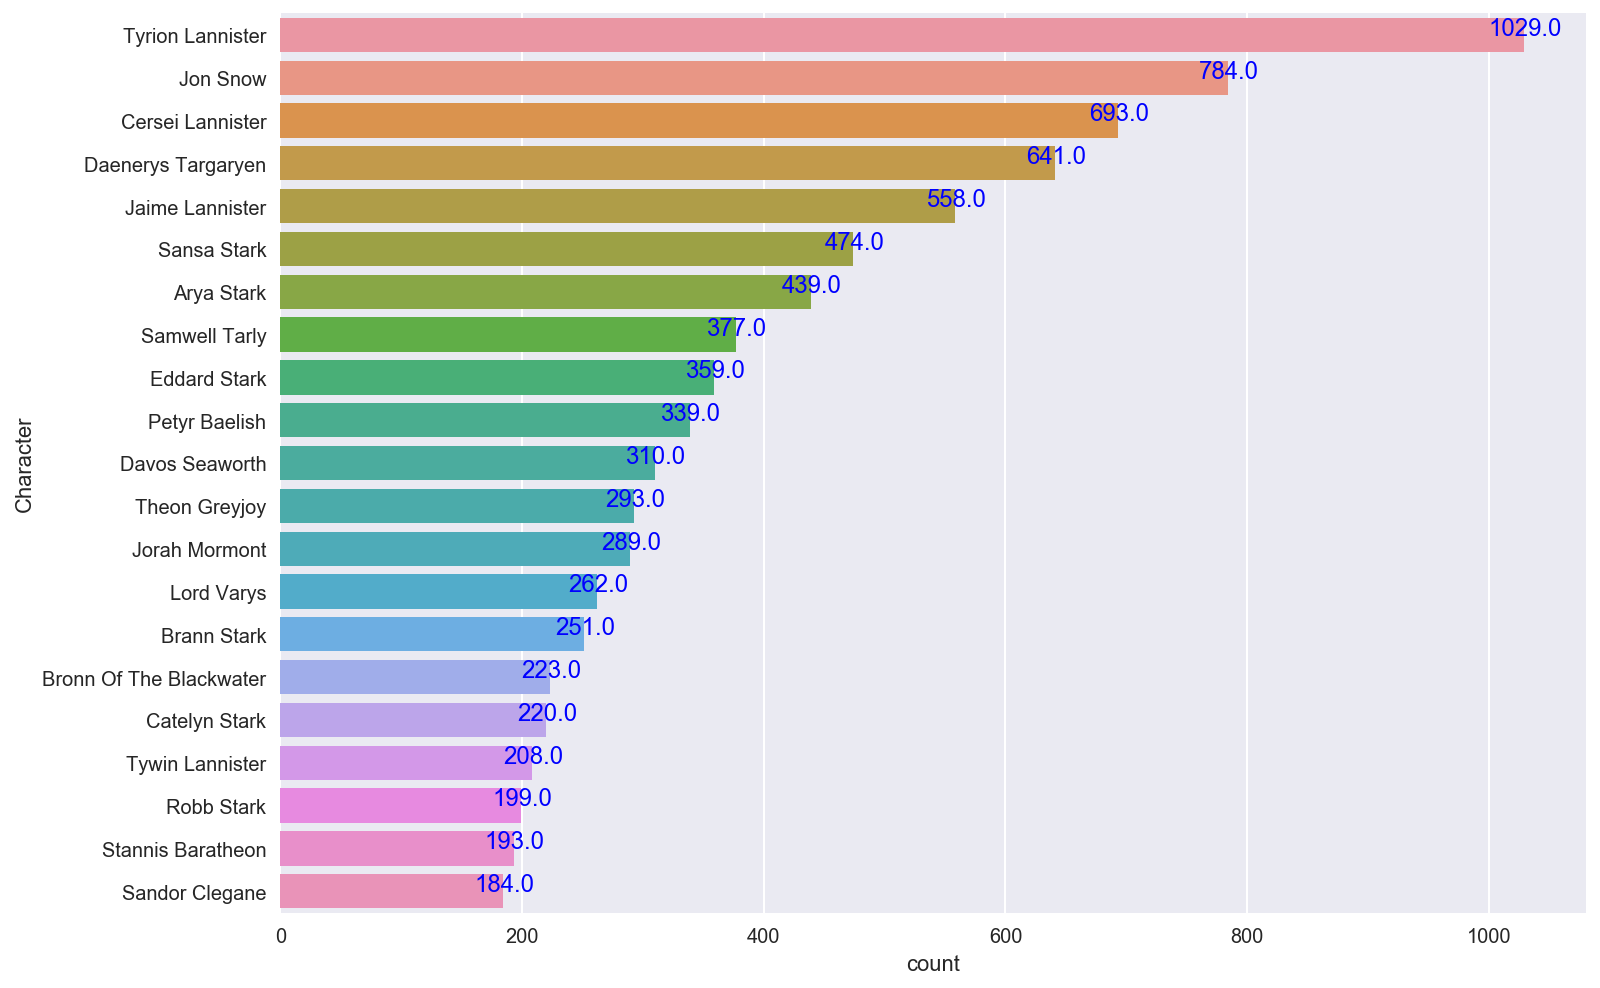

In [32]:
sns.countplot(data = df, y ='Character', order = order)
cat_counts = df['Character'].value_counts()[:21]
for i in range(len(cat_counts)):
    counts = cat_counts[i]

    pct_string = '{:0.1f}'.format(counts)

    # print the annotation just below the top of the bar
    plt.text(counts+1,i, pct_string, ha = 'center', color = 'b');

## Top 20 characters by dialogue proportion

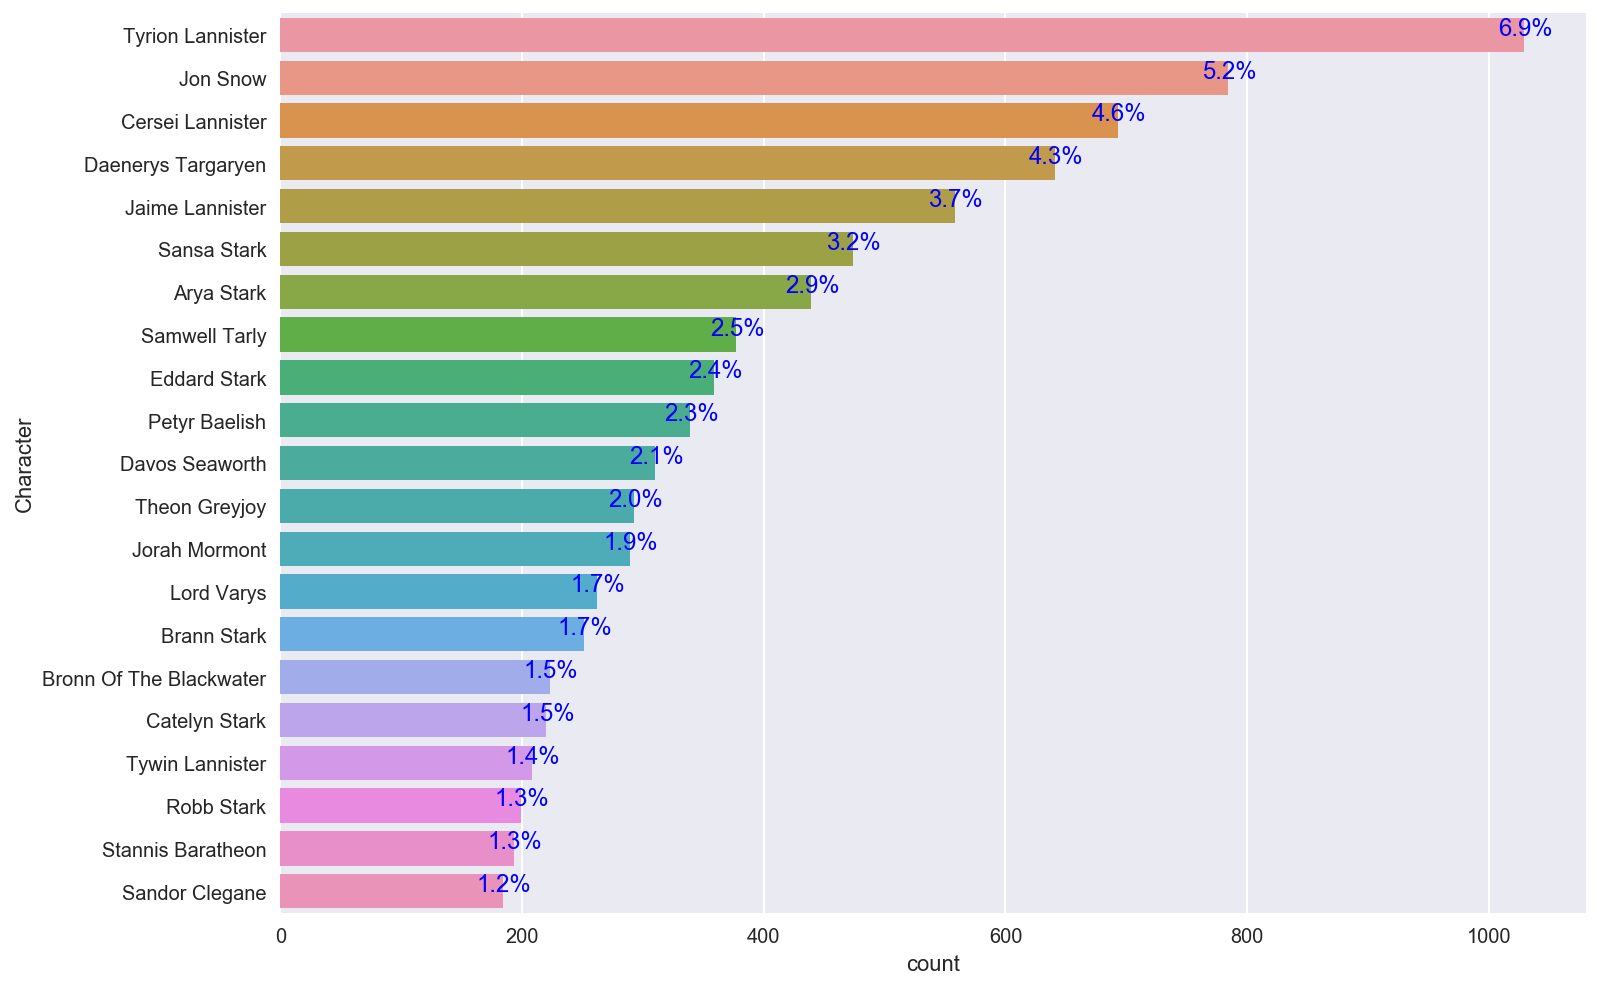

In [37]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

order = df.Character.value_counts()[:21].index


base_color = sns.color_palette()[0]
sns.countplot(data = df, y = 'Character',  order = order)


n_points = df.shape[0]
cat_counts = df['Character'].value_counts()[:21]
locs, labels = plt.yticks() 


for i in range(len(cat_counts)):
    counts = cat_counts[i]

    pct_string = '{:0.1f}%'.format(100*counts/n_points)

    
    plt.text(counts+1,i, pct_string, ha = 'center', color = 'b')

### Now let us check the number of words each character has spoken.

We will remove all punctuation from the dialogue by creating a new column and then count the number of words of that column value for each row

In [49]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
punct = set(string.punctuation)

#Free of punctiations dialogue
df['free_dialogue']= df['dialogue'].apply(lambda x :''.join(ch.lower() for ch in x if ch not in punct))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
#We create a tokenize variable of the free dialogue to count seoparate the words and count them
df['tokenized_sents'] = df.apply(lambda row: nltk.word_tokenize(row['free_dialogue']), axis=1)

In [51]:
#Get number of words per dialogue
df['number_of_words'] = df.tokenized_sents.apply(lambda x: len(x))

In [55]:
j = df.groupby('Character')['number_of_words'].sum().sort_values(ascending=False)[:21].to_frame()
j['char'] = j.index
j.head()

number_of_words                char
Character                                              
Tyrion Lannister              16579    Tyrion Lannister
Cersei Lannister              10299    Cersei Lannister
Jon Snow                       8931            Jon Snow
Daenerys Targaryen             7610  Daenerys Targaryen
Jaime Lannister                7579     Jaime Lannister

## Top 20 characters by spoken words


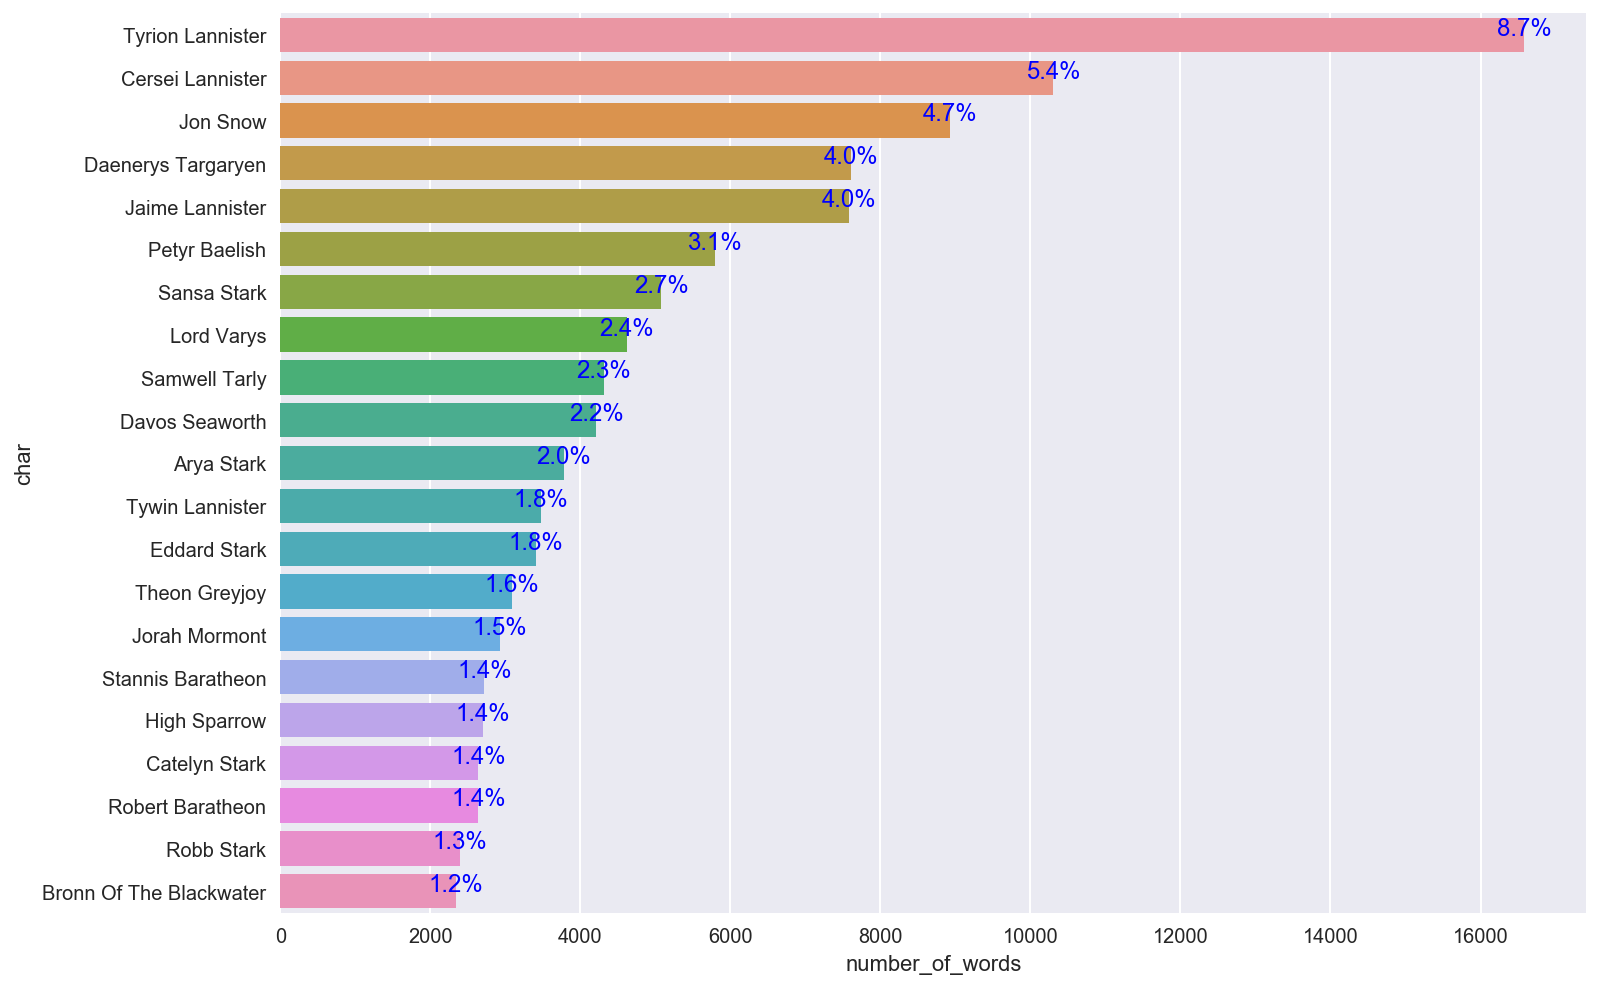

In [58]:
sns.barplot(data = j, x = 'number_of_words',y ='char' );
i = 0
for x, v in df.groupby('Character')['number_of_words'].sum().sort_values(ascending=False)[:21].items():
    counts = v 

    pct_string = '{:0.1f}%'.format(100*counts/df.number_of_words.sum())

    # print the annotation just below the top of the bar
    
    plt.text(counts+1,i, pct_string, ha = 'center', color = 'b')
    i += 1

## Words per dialogue violin plot top 5 Characters

The Lannister have longer dialogues as this plot will show us, it is also very interesting beacause we can see that Jaime has a extreamly long dialogue, wich actually turned out to be the longest uninterupted dialogue of the dataset

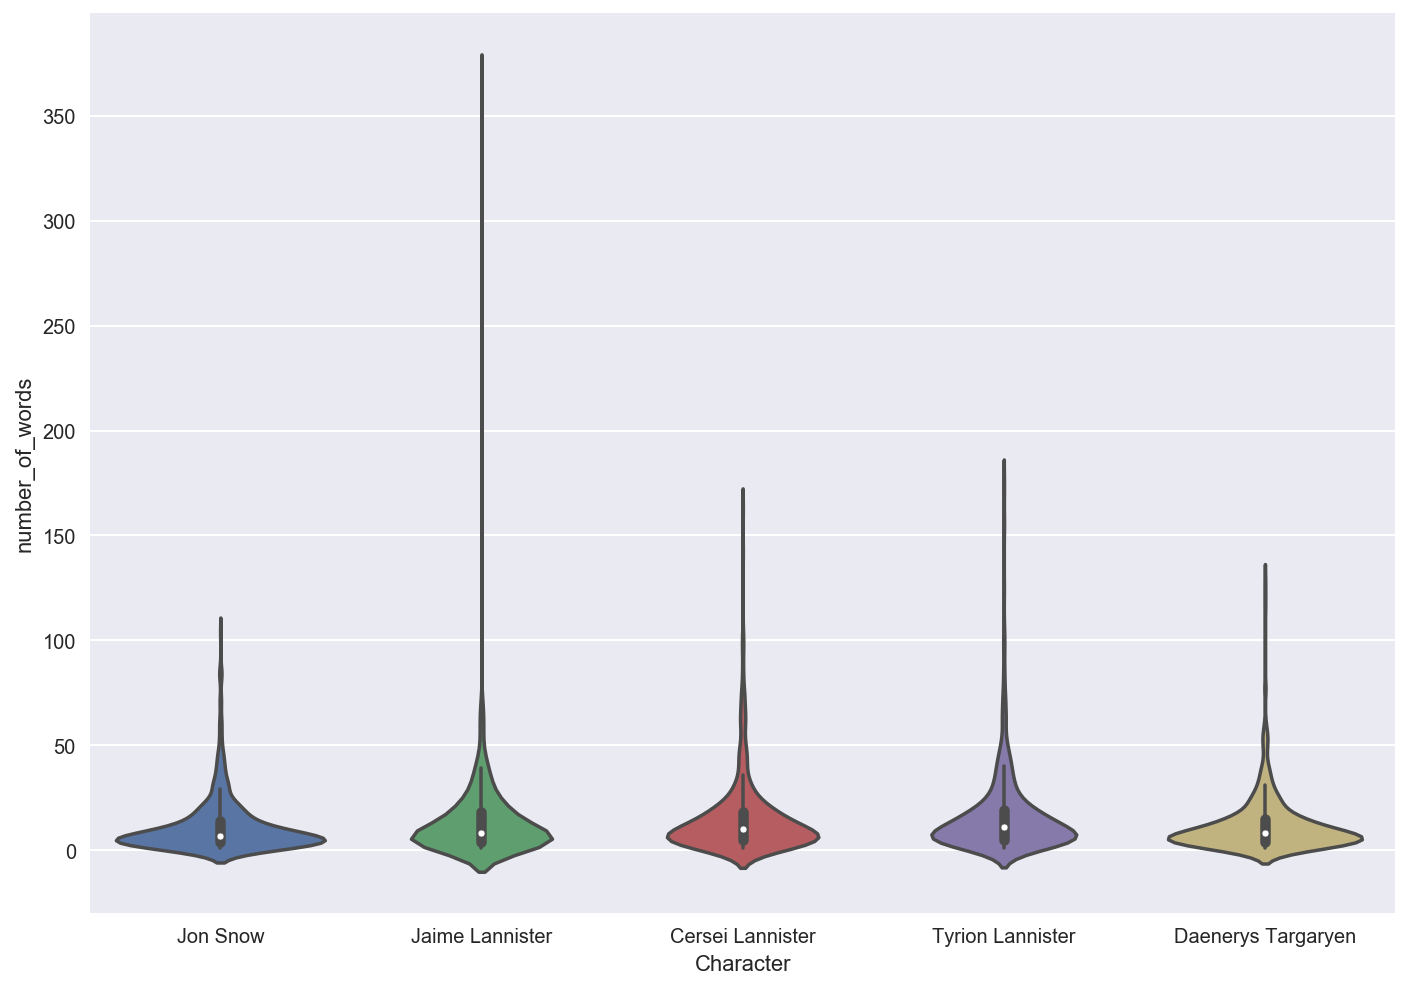

In [60]:
sns.violinplot(data = df.loc[df['Character'].isin(['Jon Snow','Tyrion Lannister','Cersei Lannister','Jaime Lannister', 'Daenerys Targaryen'])], 
              x = 'Character', y = 'number_of_words');

### Longest dialogue of the dataset

In [61]:
df.loc[df.number_of_words > 350,:]

Character                                           dialogue  \
4894  Jaime Lannister   The Mad King was obsessed with it. He loved t...   

      season  chapter                                      free_dialogue  \
4894       3        5   the mad king was obsessed with it he loved to...   

                                        tokenized_sents  number_of_words  
4894  [the, mad, king, was, obsessed, with, it, he, ...              368

In [65]:
df.loc[4894][1] #Index of the longest dialogue

" The Mad King was obsessed with it. He loved to watch people burn, the way their skin blackened and blistered and melted off their bones. He burned lords he didn't like. He burned Hands who disobeyed him. He burned anyone who was against him. Before long, half the country was against him. Aerys saw traitors everywhere. So he had his pyromancer place caches of wildfire all over the city. Beneath the Sept of Baelor and the slums of Flea Bottom. Under houses, stables, taverns. Even beneath the Red Keep itself. Finally, the day of reckoning came. Robert Baratheon marched on the capital after his victory at the Trident. But my father arrived first with the whole Lannister army at his back, promising to defend the city against the rebels. I knew my father better than that. He's never been one to pick the losing side. I told the Mad King as much. I urged him to surrender peacefully. But the king didn't listen to me. He didn't listen to Varys who tried to warn him. But he did listen to Grand 

# What our top Characters are actually saying?
To answear this question we need to eliminate some words that are not telling us anything, stopwords like 'and', 'I' , 'you' and words that we know are overly used by all the characters like 'lord', 'lady', etc. Then we will turn the reamining words to its most simple form using NLTK and finally we will plot our findings

In [66]:
#Let's create a list of stopwords (I added some myself)

stops = {'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'arent',
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'cant',
 'com',
 'could',
 'couldn',
 "couldn't",
 'couldnt',
 'd',
 'did',
 'didn',
 "didn't",
 'didnt',
 'do',
 'does',
 'doesn',
 "doesn't",
 'doesnt',
 'doing',
 'don',
 "don't",
 'dont',
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 'hadn',
 "hadn't",
 'hadnt',
 'has',
 'hasn',
 "hasn't",
 'hasnt',
 'have',
 'haven',
 "haven't",
 'havent',
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'hed',
 'hell',
 'hence',
 'her',
 'here',
 "here's",
 'heres',
 'hers',
 'herself',
 'hes',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'hows',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'id',
 'if',
 'ill',
 'im',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'isnt',
 'it',
 "it's",
 'its',
 'itself',
 'ive',
 'just',
 'k',
 "let's",
 'lets',
 'like',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'mightnt',
 'more',
 'most',
 'mustn',
 "mustn't",
 'mustnt',
 'my',
 'myself',
 'needn',
 "needn't",
 'neednt',
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',
 'ought',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r',
 're',
 's',
 'same',
 'shall',
 'shan',
 "shan't",
 'shant',
 'she',
 "she'd",
 "she'll",
 "she's",
 'shed',
 'shell',
 'shes',
 'should',
 "should've",
 'shouldn',
 "shouldn't",
 'shouldnt',
 'shouldve',
 'since',
 'so',
 'some',
 'such',
 't',
 'than',
 'that',
 "that'll",
 "that's",
 'thatll',
 'thats',
 'the',
 'their',
 'theirs',
 'them',
 'themselves',
 'then',
 'there',
 "there's",
 'therefore',
 'theres',
 'these',
 'they',
 "they'd",
 "they'll",
 "they're",
 "they've",
 'theyd',
 'theyll',
 'theyre',
 'theyve',
 'this',
 'those',
 'through',
 'to',
 'too',
 'under',
 'until',
 'up',
 've',
 'very',
 'was',
 'wasn',
 "wasn't",
 'wasnt',
 'we',
 "we'd",
 "we'll",
 "we're",
 "we've",
 'wed',
 'well',
 'were',
 'weren',
 "weren't",
 'werent',
 'weve',
 'what',
 "what's",
 'whats',
 'when',
 "when's",
 'whens',
 'where',
 "where's",
 'wheres',
 'which',
 'while',
 'who',
 "who's",
 'whom',
 'whos',
 'why',
 "why's",
 'whys',
 'will',
 'with',
 'won',
 "won't",
 'wont',
 'would',
 'wouldn',
 "wouldn't",
 'wouldnt',
 'www',
 'y',
 'you',
 "you'd",
 "you'll",
 "you're",
 "you've",
 'youd',
 'youll',
 'your',
 'youre',
 'yours',
 'yourself',
 'yourselves',
 'youve'}

In [67]:
#Let's add some others
stops.add('one')
stops.add('know')
stops.add('king')
stops.add('lord')
stops.add('man')
stops.add('men')
stops.add('grace')
stops.add('lady')



In [83]:
#And some other more

kilo = ['queen','hear','everyone','course','perhaps','and','thank','without','everything','better','name','gon','sorry','true','bring','sure','thank','saw','may','years','kings','always','came','believe','thought','still','seen','please','keep','away','something','girl','said','every','made','done','need','got','all','let','nothing','things','told','must','boy','got','oh','ser','two','never','going','l','lll','people','might','even','wanted','good','much','yes','back','many','enough',"time","person","year","way","day","thing","man","world","life","hand","part","child","eye","woman","place","work","week","case","point","government","company","number","group","problem","fact","be","have","do","say","get","make","go","know","take","see","come","think","look","want","give","use","find","tell","ask","work","seem","feel","try","leave","callgood","new","first","last","long","great","little","own","other","old","right","big","high","different","small","large","next","early","young","important","few","public","bad","same","able","to","of","in","for","on","with","at","by","from","up","about","into","over","afterthe","and","a","that","I","it","not","he","as","you","this","but","his","they","her","she","or","an","will","my","one","all","would","there","their","us"]

for i in kilo:
    stops.add(i)


In [84]:
#Stopwords free dialogue
df['tokenized_stopwords'] = df['tokenized_sents'].apply(lambda x: [item for item in x if item not in stops])

In [85]:
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

# Reduce words to their root form

df['lemmatize_words'] = df['tokenized_stopwords'].apply(lambda x: [WordNetLemmatizer().lemmatize(item,pos='v') for item in x])


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [86]:
#A function to plot

def plotter(name):
    '''
    Creates a word plot of the top 60 most used words by any given character. It assumes a pandas Dataframe with the needed data. 
    Input: Str. Character name
    Output: Wordcloud plot of the most common words in that character dialogues.
    '''
    kinoa = []
    for i, v in dp.lemmatize_words[dp.Character == name].items():
        kinoa.extend(v)
    kinoa_= Counter(kinoa)
    wc = WordCloud(max_words =60,background_color='white', scale =3 , stopwords=set('one')).generate_from_frequencies(kinoa_)
    plt.figure( figsize=(100,50) ).suptitle(name, fontsize=300)
    plt.imshow(wc);

## Top 5 character most used words
This was pretty insightfull, most characters have daddy issues, and only the Lannisters mention love, especially Cersei.

In [87]:
#Now lets plot for our top 5 Characters
for i in j.index[:5]:
    plotter(i)


#### Hodor

In [88]:
plotter('Hodor')

In [90]:
df.Character[5] = 'Waymar Royce'
df.Character[7] = 'Waymar Royce'
df.Character[9] = 'Waymar Royce'
df.Character[10] = 'Waymar Royce'
df.Character[13] = 'Waymar Royce'

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\chris\Anac

# PART III 

# Modeling the data. 

# Let's create a network graph between the characters

For this we need to check how many times a character is mention by another character in each dialogue and then count the intereactions.

In order to accomplish such goal, which is not given by the dialogue text I had access to I just created a new column called 'to' and put it the character name that was in the next row, as most of the time that dialogue was intended for the next character. Of course is not accuarate but it is the best approximation I could get, the final results are also pretty good.

In [2]:
#I am just gonna open this new csv without all the columns we created before, so is not as confusing. 
df = pd.read_csv('Got_01.csv')

Since it is the dialogue relationships that count we need to put the name of the character and the reciever in it. So I created a column with the same dialogue but character name and reciver name at the beggining. 

In [102]:
df.head()

Character                                           dialogue  season  \
0  Waymar Royce   What d'you expect? They're savages. One lot s...       1   
1          Will   I've never seen wildlings do a thing like thi...       1   
2  Waymar Royce                             How close did you get?       1   
3          Will                            Close as any man would.       1   
4         Gared                   We should head back to the wall.       1   

   chapter            to                                               ProD  
0        1          Will  Waymar Royce,Will, What d'you expect? They're ...  
1        1  Waymar Royce  Will,Waymar Royce, I've never seen wildlings d...  
2        1          Will          Waymar Royce,Will, How close did you get?  
3        1         Gared                Will,Gared, Close as any man would.  
4        1  Waymar Royce  Gared,Waymar Royce, We should head back to the...

In [103]:
#The function I will use to separate the dialogue, will do it by punctuation, since thise are alreayd separated by row there is no need
#So I will delete the separators to keed each dialogue row complete
df['ProD'] = df['ProD'].apply(lambda x : x.replace('.',''))
df['ProD'] = df['ProD'].apply(lambda x : x.replace('?',''))
df['ProD'] = df['ProD'].apply(lambda x : x.replace('!',''))
df['ProD'] = df['ProD'].apply(lambda x : x.replace('...',''))

In [104]:
#Lets create a list of sentences using NLTK sent
sentences = [nltk.sent_tokenize(dialogue) for dialogue in df.ProD]
sentences

[["Waymar Royce,Will, What d'you expect They're savages One lot steals a goat from another lot and before you know it, they're ripping each other to pieces"],
 ["Will,Waymar Royce, I've never seen wildlings do a thing like this I've never seen a thing like this, not ever in my life"],
 ['Waymar Royce,Will, How close did you get'],
 ['Will,Gared, Close as any man would'],
 ['Gared,Waymar Royce, We should head back to the wall'],
 ['Waymar Royce,Gared, Do the dead frighten you'],
 ["Gared,Waymar Royce, Our orders were to track the wildlings We tracked them They won't trouble us no more"],
 ["Waymar Royce,Will, You don't think he'll ask us how they died Get back on your horse"],
 ['Will,Waymar Royce, Whatever did it to them could do it to us They even killed the children'],
 ["Waymar Royce,Waymar Royce, It's a good thing we're not children You want to run away south, run away Of course, they will behead you as a deserter  If I don't catch you first Get back on your horse I won't say it ag

In [105]:
#Our next function needs them as a string, so we need to to a bit of preprocessing here
sent = []
for i in sentences:
    for j in i:
        sent.append(j)
#just a list of strings, and not a list of lists        
sent    

["Waymar Royce,Will, What d'you expect They're savages One lot steals a goat from another lot and before you know it, they're ripping each other to pieces",
 "Will,Waymar Royce, I've never seen wildlings do a thing like this I've never seen a thing like this, not ever in my life",
 'Waymar Royce,Will, How close did you get',
 'Will,Gared, Close as any man would',
 'Gared,Waymar Royce, We should head back to the wall',
 'Waymar Royce,Gared, Do the dead frighten you',
 "Gared,Waymar Royce, Our orders were to track the wildlings We tracked them They won't trouble us no more",
 "Waymar Royce,Will, You don't think he'll ask us how they died Get back on your horse",
 'Will,Waymar Royce, Whatever did it to them could do it to us They even killed the children',
 "Waymar Royce,Waymar Royce, It's a good thing we're not children You want to run away south, run away Of course, they will behead you as a deserter  If I don't catch you first Get back on your horse I won't say it again",
 'Waymar Royc

In [106]:
#We tokenize
tokenized_sentences = [nltk.word_tokenize(sentence) for sentence in sent]
tokenized_sentences

[['Waymar',
  'Royce',
  ',',
  'Will',
  ',',
  'What',
  "d'you",
  'expect',
  'They',
  "'re",
  'savages',
  'One',
  'lot',
  'steals',
  'a',
  'goat',
  'from',
  'another',
  'lot',
  'and',
  'before',
  'you',
  'know',
  'it',
  ',',
  'they',
  "'re",
  'ripping',
  'each',
  'other',
  'to',
  'pieces'],
 ['Will',
  ',',
  'Waymar',
  'Royce',
  ',',
  'I',
  "'ve",
  'never',
  'seen',
  'wildlings',
  'do',
  'a',
  'thing',
  'like',
  'this',
  'I',
  "'ve",
  'never',
  'seen',
  'a',
  'thing',
  'like',
  'this',
  ',',
  'not',
  'ever',
  'in',
  'my',
  'life'],
 ['Waymar', 'Royce', ',', 'Will', ',', 'How', 'close', 'did', 'you', 'get'],
 ['Will', ',', 'Gared', ',', 'Close', 'as', 'any', 'man', 'would'],
 ['Gared',
  ',',
  'Waymar',
  'Royce',
  ',',
  'We',
  'should',
  'head',
  'back',
  'to',
  'the',
  'wall'],
 ['Waymar',
  'Royce',
  ',',
  'Gared',
  ',',
  'Do',
  'the',
  'dead',
  'frighten',
  'you'],
 ['Gared',
  ',',
  'Waymar',
  'Royce',
  ',',

We have tro create a list of characters for our network, I picked the top 60 characters.

In [3]:
df.Character.value_counts()[:40]


Tyrion Lannister           1029
Jon Snow                    784
Cersei Lannister            693
Daenerys Targaryen          641
Jaime Lannister             558
Sansa Stark                 474
Arya Stark                  439
Samwell Tarly               377
Ned Stark                   359
Petyr Baelish               339
Davos Seaworth              310
Theon Greyjoy               293
Jorah Mormont               289
Lord Varys                  262
Brann Stark                 251
Bronn Of The Blackwater     223
Catelyn Stark               220
Tywin Lannister             208
Robb Stark                  199
Ramsay Bolton               197
Stannis Baratheon           193
Sandor Clegane              184
Brienne Of Tarth            182
Margaery Tyrell             155
High Sparrow                154
Joffrey Baratheon           139
Tormund Giantsbane          136
Roose Bolton                135
Robert Baratheon            131
Daario Naharis              125
Melisandre                  123
Olenna T

In [432]:
Namelist = ['Tyrion',
 'Jon',
 'Cersei',
 'Daenerys',
 'Jaime',
 'Sansa',
 'Arya',
 'Samwell',
 'Ned',
 'Petyr',
 'Davos',
 'Theon',
 'Jorah',
 'Brann',
 'Bronn',
 'Catelyn',
 'Tywin',
 'Robb',
 'Stannis',
 'Brienne',
 'Ramsay',
 'Margaery',
 'Joffrey',
 'Tormund',
 'Roose',
 'Robert',
 'Daario',
 'Melisandre',
 'Olenna',
 'Gilly',
 'Missandei',
 'Yara',
 'Tommen',
 'Walder',
 'Osha',
 'Jaqen',
 'Podrick',
 'Viserys',
 'Gendry',
 'Janos',
 'Alliser',
 'Oberyn',
 'Qyburn',
 'Barristan',
 'Jeor',
 'Loras',
 'Marwyn',
 'Edd',
 'Renly',
 'Meera',
 'Grenn',
 'Waif',
 'Euron',
 'Shae',
 'Pycelle',
 'Varys',
 'Sparrow',
 'Luwin',
 'Clegane',
 'Worm',
'Aemon','Hizdahr','Beric','Ygritte','Mance']



In [433]:
Names = Namelist
for name in enumerate(Names): print(name)

(0, 'Tyrion')
(1, 'Jon')
(2, 'Cersei')
(3, 'Daenerys')
(4, 'Jaime')
(5, 'Sansa')
(6, 'Arya')
(7, 'Samwell')
(8, 'Ned')
(9, 'Petyr')
(10, 'Davos')
(11, 'Theon')
(12, 'Jorah')
(13, 'Brann')
(14, 'Bronn')
(15, 'Catelyn')
(16, 'Tywin')
(17, 'Robb')
(18, 'Stannis')
(19, 'Brienne')
(20, 'Ramsay')
(21, 'Margaery')
(22, 'Joffrey')
(23, 'Tormund')
(24, 'Roose')
(25, 'Robert')
(26, 'Daario')
(27, 'Melisandre')
(28, 'Olenna')
(29, 'Gilly')
(30, 'Missandei')
(31, 'Yara')
(32, 'Tommen')
(33, 'Walder')
(34, 'Osha')
(35, 'Jaqen')
(36, 'Podrick')
(37, 'Viserys')
(38, 'Gendry')
(39, 'Janos')
(40, 'Alliser')
(41, 'Oberyn')
(42, 'Qyburn')
(43, 'Barristan')
(44, 'Jeor')
(45, 'Loras')
(46, 'Marwyn')
(47, 'Edd')
(48, 'Renly')
(49, 'Meera')
(50, 'Grenn')
(51, 'Waif')
(52, 'Euron')
(53, 'Shae')
(54, 'Pycelle')
(55, 'Varys')
(56, 'Sparrow')
(57, 'Luwin')
(58, 'Clegane')
(59, 'Worm')
(60, 'Aemon')
(61, 'Hizdahr')
(62, 'Beric')
(63, 'Ygritte')
(64, 'Mance')


In [434]:
#Compare sentences for interactions

def two_char_sentences(sentence_word_tokens,name1,name2,sentence_span=2):
    '''
    Quantifies the number of interactions between 2 characters in each sentence.
    Input:List of sentences, Str. 2 character names to compare.
    Output: List of sentences where the characters interact, number of interactions. 
    '''
    sentences = sentence_word_tokens

    two_char_sent = []
    last_sentences=[""]*(sentence_span-1)
    for sentence in sentences: 
        start = ""
        for sent in last_sentences:  start += sent + " " 

        n_sentences = start + " " + sentence

        if name1 in n_sentences and name2 in n_sentences:

            two_char_sent.append(n_sentences)
        last_sentences = last_sentences[1:sentence_span-1] + [sentence]
        #print(last_sentences)
    return two_char_sent,len(two_char_sent)

In [436]:
#only the strongest, for the d3 web map
interaction_map = []
done_names = []
for name1 in Namelist:
    done_names.append(name1)
    print("Names Completed:",done_names)
    for name2 in Namelist:
        if name2 not in done_names:
            text, num_interactions = two_char_sentences(sent,name1,name2)
            if num_interactions>39: 
                interaction_map.append([name1,name2,num_interactions])
                print("added:",[name1,name2,num_interactions])
            else: 
                print(name1,name2,num_interactions,"interactions, skipping")
            
        else: print("skipped, already did reciprocal relationship", name2)

Names Completed: ['Tyrion']
skipped, already did reciprocal relationship Tyrion
added: ['Tyrion', 'Jon', 168]
added: ['Tyrion', 'Cersei', 289]
added: ['Tyrion', 'Daenerys', 328]
added: ['Tyrion', 'Jaime', 183]
added: ['Tyrion', 'Sansa', 64]
Tyrion Arya 13 interactions, skipping
Tyrion Samwell 4 interactions, skipping
Tyrion Ned 35 interactions, skipping
Tyrion Petyr 17 interactions, skipping
added: ['Tyrion', 'Davos', 47]
Tyrion Theon 38 interactions, skipping
added: ['Tyrion', 'Jorah', 140]
Tyrion Brann 15 interactions, skipping
added: ['Tyrion', 'Bronn', 160]
added: ['Tyrion', 'Catelyn', 44]
added: ['Tyrion', 'Tywin', 205]
Tyrion Robb 28 interactions, skipping
Tyrion Stannis 32 interactions, skipping
Tyrion Brienne 6 interactions, skipping
Tyrion Ramsay 3 interactions, skipping
Tyrion Margaery 9 interactions, skipping
added: ['Tyrion', 'Joffrey', 140]
Tyrion Tormund 1 interactions, skipping
Tyrion Roose 29 interactions, skipping
Tyrion Robert 29 interactions, skipping
Tyrion Daario 3

Daenerys Joffrey 4 interactions, skipping
Daenerys Tormund 0 interactions, skipping
Daenerys Roose 2 interactions, skipping
Daenerys Robert 26 interactions, skipping
added: ['Daenerys', 'Daario', 131]
Daenerys Melisandre 19 interactions, skipping
Daenerys Olenna 10 interactions, skipping
Daenerys Gilly 0 interactions, skipping
added: ['Daenerys', 'Missandei', 66]
Daenerys Yara 23 interactions, skipping
Daenerys Tommen 0 interactions, skipping
Daenerys Walder 4 interactions, skipping
Daenerys Osha 4 interactions, skipping
Daenerys Jaqen 3 interactions, skipping
Daenerys Podrick 1 interactions, skipping
added: ['Daenerys', 'Viserys', 62]
Daenerys Gendry 0 interactions, skipping
Daenerys Janos 0 interactions, skipping
Daenerys Alliser 4 interactions, skipping
Daenerys Oberyn 5 interactions, skipping
Daenerys Qyburn 2 interactions, skipping
added: ['Daenerys', 'Barristan', 83]
Daenerys Jeor 1 interactions, skipping
Daenerys Loras 0 interactions, skipping
Daenerys Marwyn 2 interactions, ski

Arya Qyburn 0 interactions, skipping
Arya Barristan 0 interactions, skipping
Arya Jeor 0 interactions, skipping
Arya Loras 0 interactions, skipping
Arya Marwyn 0 interactions, skipping
Arya Edd 9 interactions, skipping
Arya Renly 0 interactions, skipping
Arya Meera 2 interactions, skipping
Arya Grenn 0 interactions, skipping
added: ['Arya', 'Waif', 74]
Arya Euron 0 interactions, skipping
Arya Shae 0 interactions, skipping
Arya Pycelle 1 interactions, skipping
Arya Varys 8 interactions, skipping
Arya Sparrow 1 interactions, skipping
Arya Luwin 0 interactions, skipping
added: ['Arya', 'Clegane', 103]
Arya Worm 0 interactions, skipping
Arya Aemon 0 interactions, skipping
Arya Hizdahr 0 interactions, skipping
Arya Beric 6 interactions, skipping
Arya Ygritte 2 interactions, skipping
Arya Mance 0 interactions, skipping
Names Completed: ['Tyrion', 'Jon', 'Cersei', 'Daenerys', 'Jaime', 'Sansa', 'Arya', 'Samwell']
skipped, already did reciprocal relationship Tyrion
skipped, already did reciproc

Davos Alliser 20 interactions, skipping
Davos Oberyn 2 interactions, skipping
Davos Qyburn 2 interactions, skipping
Davos Barristan 0 interactions, skipping
Davos Jeor 2 interactions, skipping
Davos Loras 0 interactions, skipping
Davos Marwyn 0 interactions, skipping
Davos Edd 19 interactions, skipping
Davos Renly 14 interactions, skipping
Davos Meera 0 interactions, skipping
Davos Grenn 0 interactions, skipping
Davos Waif 2 interactions, skipping
Davos Euron 1 interactions, skipping
Davos Shae 0 interactions, skipping
Davos Pycelle 0 interactions, skipping
Davos Varys 1 interactions, skipping
Davos Sparrow 0 interactions, skipping
Davos Luwin 0 interactions, skipping
Davos Clegane 2 interactions, skipping
Davos Worm 1 interactions, skipping
Davos Aemon 0 interactions, skipping
Davos Hizdahr 0 interactions, skipping
Davos Beric 3 interactions, skipping
Davos Ygritte 0 interactions, skipping
Davos Mance 9 interactions, skipping
Names Completed: ['Tyrion', 'Jon', 'Cersei', 'Daenerys', 'J

Bronn Missandei 0 interactions, skipping
Bronn Yara 0 interactions, skipping
Bronn Tommen 0 interactions, skipping
Bronn Walder 7 interactions, skipping
Bronn Osha 0 interactions, skipping
Bronn Jaqen 0 interactions, skipping
Bronn Podrick 16 interactions, skipping
Bronn Viserys 0 interactions, skipping
Bronn Gendry 1 interactions, skipping
Bronn Janos 5 interactions, skipping
Bronn Alliser 0 interactions, skipping
Bronn Oberyn 3 interactions, skipping
Bronn Qyburn 2 interactions, skipping
Bronn Barristan 0 interactions, skipping
Bronn Jeor 0 interactions, skipping
Bronn Loras 0 interactions, skipping
Bronn Marwyn 0 interactions, skipping
Bronn Edd 0 interactions, skipping
Bronn Renly 0 interactions, skipping
Bronn Meera 0 interactions, skipping
Bronn Grenn 0 interactions, skipping
Bronn Waif 0 interactions, skipping
Bronn Euron 0 interactions, skipping
Bronn Shae 23 interactions, skipping
Bronn Pycelle 0 interactions, skipping
Bronn Varys 2 interactions, skipping
Bronn Sparrow 2 inter

Robb Podrick 0 interactions, skipping
Robb Viserys 0 interactions, skipping
Robb Gendry 0 interactions, skipping
Robb Janos 0 interactions, skipping
Robb Alliser 0 interactions, skipping
Robb Oberyn 0 interactions, skipping
Robb Qyburn 0 interactions, skipping
Robb Barristan 2 interactions, skipping
Robb Jeor 0 interactions, skipping
Robb Loras 0 interactions, skipping
Robb Marwyn 0 interactions, skipping
Robb Edd 2 interactions, skipping
Robb Renly 16 interactions, skipping
Robb Meera 0 interactions, skipping
Robb Grenn 0 interactions, skipping
Robb Waif 0 interactions, skipping
Robb Euron 0 interactions, skipping
Robb Shae 2 interactions, skipping
Robb Pycelle 1 interactions, skipping
Robb Varys 10 interactions, skipping
Robb Sparrow 0 interactions, skipping
Robb Luwin 23 interactions, skipping
Robb Clegane 5 interactions, skipping
Robb Worm 0 interactions, skipping
Robb Aemon 5 interactions, skipping
Robb Hizdahr 0 interactions, skipping
Robb Beric 0 interactions, skipping
Robb Ygri

skipped, already did reciprocal relationship Arya
skipped, already did reciprocal relationship Samwell
skipped, already did reciprocal relationship Ned
skipped, already did reciprocal relationship Petyr
skipped, already did reciprocal relationship Davos
skipped, already did reciprocal relationship Theon
skipped, already did reciprocal relationship Jorah
skipped, already did reciprocal relationship Brann
skipped, already did reciprocal relationship Bronn
skipped, already did reciprocal relationship Catelyn
skipped, already did reciprocal relationship Tywin
skipped, already did reciprocal relationship Robb
skipped, already did reciprocal relationship Stannis
skipped, already did reciprocal relationship Brienne
skipped, already did reciprocal relationship Ramsay
skipped, already did reciprocal relationship Margaery
skipped, already did reciprocal relationship Joffrey
Joffrey Tormund 2 interactions, skipping
Joffrey Roose 3 interactions, skipping
Joffrey Robert 27 interactions, skipping
Jo

Daario Shae 0 interactions, skipping
Daario Pycelle 0 interactions, skipping
Daario Varys 5 interactions, skipping
Daario Sparrow 1 interactions, skipping
Daario Luwin 0 interactions, skipping
Daario Clegane 0 interactions, skipping
Daario Worm 21 interactions, skipping
Daario Aemon 0 interactions, skipping
Daario Hizdahr 29 interactions, skipping
Daario Beric 0 interactions, skipping
Daario Ygritte 0 interactions, skipping
Daario Mance 0 interactions, skipping
Names Completed: ['Tyrion', 'Jon', 'Cersei', 'Daenerys', 'Jaime', 'Sansa', 'Arya', 'Samwell', 'Ned', 'Petyr', 'Davos', 'Theon', 'Jorah', 'Brann', 'Bronn', 'Catelyn', 'Tywin', 'Robb', 'Stannis', 'Brienne', 'Ramsay', 'Margaery', 'Joffrey', 'Tormund', 'Roose', 'Robert', 'Daario', 'Melisandre']
skipped, already did reciprocal relationship Tyrion
skipped, already did reciprocal relationship Jon
skipped, already did reciprocal relationship Cersei
skipped, already did reciprocal relationship Daenerys
skipped, already did reciprocal rel

skipped, already did reciprocal relationship Margaery
skipped, already did reciprocal relationship Joffrey
skipped, already did reciprocal relationship Tormund
skipped, already did reciprocal relationship Roose
skipped, already did reciprocal relationship Robert
skipped, already did reciprocal relationship Daario
skipped, already did reciprocal relationship Melisandre
skipped, already did reciprocal relationship Olenna
skipped, already did reciprocal relationship Gilly
Gilly Missandei 0 interactions, skipping
Gilly Yara 0 interactions, skipping
Gilly Tommen 1 interactions, skipping
Gilly Walder 0 interactions, skipping
Gilly Osha 0 interactions, skipping
Gilly Jaqen 0 interactions, skipping
Gilly Podrick 0 interactions, skipping
Gilly Viserys 0 interactions, skipping
Gilly Gendry 0 interactions, skipping
Gilly Janos 2 interactions, skipping
Gilly Alliser 9 interactions, skipping
Gilly Oberyn 0 interactions, skipping
Gilly Qyburn 0 interactions, skipping
Gilly Barristan 1 interactions, 

Walder Hizdahr 0 interactions, skipping
Walder Beric 2 interactions, skipping
Walder Ygritte 0 interactions, skipping
Walder Mance 0 interactions, skipping
Names Completed: ['Tyrion', 'Jon', 'Cersei', 'Daenerys', 'Jaime', 'Sansa', 'Arya', 'Samwell', 'Ned', 'Petyr', 'Davos', 'Theon', 'Jorah', 'Brann', 'Bronn', 'Catelyn', 'Tywin', 'Robb', 'Stannis', 'Brienne', 'Ramsay', 'Margaery', 'Joffrey', 'Tormund', 'Roose', 'Robert', 'Daario', 'Melisandre', 'Olenna', 'Gilly', 'Missandei', 'Yara', 'Tommen', 'Walder', 'Osha']
skipped, already did reciprocal relationship Tyrion
skipped, already did reciprocal relationship Jon
skipped, already did reciprocal relationship Cersei
skipped, already did reciprocal relationship Daenerys
skipped, already did reciprocal relationship Jaime
skipped, already did reciprocal relationship Sansa
skipped, already did reciprocal relationship Arya
skipped, already did reciprocal relationship Samwell
skipped, already did reciprocal relationship Ned
skipped, already did re

Podrick Edd 0 interactions, skipping
Podrick Renly 7 interactions, skipping
Podrick Meera 0 interactions, skipping
Podrick Grenn 0 interactions, skipping
Podrick Waif 0 interactions, skipping
Podrick Euron 0 interactions, skipping
Podrick Shae 2 interactions, skipping
Podrick Pycelle 0 interactions, skipping
Podrick Varys 0 interactions, skipping
Podrick Sparrow 0 interactions, skipping
Podrick Luwin 0 interactions, skipping
Podrick Clegane 6 interactions, skipping
Podrick Worm 0 interactions, skipping
Podrick Aemon 0 interactions, skipping
Podrick Hizdahr 0 interactions, skipping
Podrick Beric 0 interactions, skipping
Podrick Ygritte 0 interactions, skipping
Podrick Mance 0 interactions, skipping
Names Completed: ['Tyrion', 'Jon', 'Cersei', 'Daenerys', 'Jaime', 'Sansa', 'Arya', 'Samwell', 'Ned', 'Petyr', 'Davos', 'Theon', 'Jorah', 'Brann', 'Bronn', 'Catelyn', 'Tywin', 'Robb', 'Stannis', 'Brienne', 'Ramsay', 'Margaery', 'Joffrey', 'Tormund', 'Roose', 'Robert', 'Daario', 'Melisandre', '

Janos Renly 5 interactions, skipping
Janos Meera 0 interactions, skipping
Janos Grenn 3 interactions, skipping
Janos Waif 0 interactions, skipping
Janos Euron 0 interactions, skipping
Janos Shae 0 interactions, skipping
Janos Pycelle 3 interactions, skipping
Janos Varys 7 interactions, skipping
Janos Sparrow 0 interactions, skipping
Janos Luwin 0 interactions, skipping
Janos Clegane 0 interactions, skipping
Janos Worm 0 interactions, skipping
Janos Aemon 9 interactions, skipping
Janos Hizdahr 0 interactions, skipping
Janos Beric 0 interactions, skipping
Janos Ygritte 0 interactions, skipping
Janos Mance 3 interactions, skipping
Names Completed: ['Tyrion', 'Jon', 'Cersei', 'Daenerys', 'Jaime', 'Sansa', 'Arya', 'Samwell', 'Ned', 'Petyr', 'Davos', 'Theon', 'Jorah', 'Brann', 'Bronn', 'Catelyn', 'Tywin', 'Robb', 'Stannis', 'Brienne', 'Ramsay', 'Margaery', 'Joffrey', 'Tormund', 'Roose', 'Robert', 'Daario', 'Melisandre', 'Olenna', 'Gilly', 'Missandei', 'Yara', 'Tommen', 'Walder', 'Osha', 'Jaq

Jeor Luwin 0 interactions, skipping
Jeor Clegane 0 interactions, skipping
Jeor Worm 0 interactions, skipping
Jeor Aemon 11 interactions, skipping
Jeor Hizdahr 0 interactions, skipping
Jeor Beric 0 interactions, skipping
Jeor Ygritte 0 interactions, skipping
Jeor Mance 4 interactions, skipping
Names Completed: ['Tyrion', 'Jon', 'Cersei', 'Daenerys', 'Jaime', 'Sansa', 'Arya', 'Samwell', 'Ned', 'Petyr', 'Davos', 'Theon', 'Jorah', 'Brann', 'Bronn', 'Catelyn', 'Tywin', 'Robb', 'Stannis', 'Brienne', 'Ramsay', 'Margaery', 'Joffrey', 'Tormund', 'Roose', 'Robert', 'Daario', 'Melisandre', 'Olenna', 'Gilly', 'Missandei', 'Yara', 'Tommen', 'Walder', 'Osha', 'Jaqen', 'Podrick', 'Viserys', 'Gendry', 'Janos', 'Alliser', 'Oberyn', 'Qyburn', 'Barristan', 'Jeor', 'Loras']
skipped, already did reciprocal relationship Tyrion
skipped, already did reciprocal relationship Jon
skipped, already did reciprocal relationship Cersei
skipped, already did reciprocal relationship Daenerys
skipped, already did recipro

skipped, already did reciprocal relationship Robert
skipped, already did reciprocal relationship Daario
skipped, already did reciprocal relationship Melisandre
skipped, already did reciprocal relationship Olenna
skipped, already did reciprocal relationship Gilly
skipped, already did reciprocal relationship Missandei
skipped, already did reciprocal relationship Yara
skipped, already did reciprocal relationship Tommen
skipped, already did reciprocal relationship Walder
skipped, already did reciprocal relationship Osha
skipped, already did reciprocal relationship Jaqen
skipped, already did reciprocal relationship Podrick
skipped, already did reciprocal relationship Viserys
skipped, already did reciprocal relationship Gendry
skipped, already did reciprocal relationship Janos
skipped, already did reciprocal relationship Alliser
skipped, already did reciprocal relationship Oberyn
skipped, already did reciprocal relationship Qyburn
skipped, already did reciprocal relationship Barristan
skippe

skipped, already did reciprocal relationship Yara
skipped, already did reciprocal relationship Tommen
skipped, already did reciprocal relationship Walder
skipped, already did reciprocal relationship Osha
skipped, already did reciprocal relationship Jaqen
skipped, already did reciprocal relationship Podrick
skipped, already did reciprocal relationship Viserys
skipped, already did reciprocal relationship Gendry
skipped, already did reciprocal relationship Janos
skipped, already did reciprocal relationship Alliser
skipped, already did reciprocal relationship Oberyn
skipped, already did reciprocal relationship Qyburn
skipped, already did reciprocal relationship Barristan
skipped, already did reciprocal relationship Jeor
skipped, already did reciprocal relationship Loras
skipped, already did reciprocal relationship Marwyn
skipped, already did reciprocal relationship Edd
skipped, already did reciprocal relationship Renly
skipped, already did reciprocal relationship Meera
skipped, already did

skipped, already did reciprocal relationship Edd
skipped, already did reciprocal relationship Renly
skipped, already did reciprocal relationship Meera
skipped, already did reciprocal relationship Grenn
skipped, already did reciprocal relationship Waif
skipped, already did reciprocal relationship Euron
skipped, already did reciprocal relationship Shae
skipped, already did reciprocal relationship Pycelle
Pycelle Varys 30 interactions, skipping
Pycelle Sparrow 4 interactions, skipping
Pycelle Luwin 0 interactions, skipping
Pycelle Clegane 7 interactions, skipping
Pycelle Worm 0 interactions, skipping
Pycelle Aemon 0 interactions, skipping
Pycelle Hizdahr 0 interactions, skipping
Pycelle Beric 2 interactions, skipping
Pycelle Ygritte 0 interactions, skipping
Pycelle Mance 0 interactions, skipping
Names Completed: ['Tyrion', 'Jon', 'Cersei', 'Daenerys', 'Jaime', 'Sansa', 'Arya', 'Samwell', 'Ned', 'Petyr', 'Davos', 'Theon', 'Jorah', 'Brann', 'Bronn', 'Catelyn', 'Tywin', 'Robb', 'Stannis', 'B

Names Completed: ['Tyrion', 'Jon', 'Cersei', 'Daenerys', 'Jaime', 'Sansa', 'Arya', 'Samwell', 'Ned', 'Petyr', 'Davos', 'Theon', 'Jorah', 'Brann', 'Bronn', 'Catelyn', 'Tywin', 'Robb', 'Stannis', 'Brienne', 'Ramsay', 'Margaery', 'Joffrey', 'Tormund', 'Roose', 'Robert', 'Daario', 'Melisandre', 'Olenna', 'Gilly', 'Missandei', 'Yara', 'Tommen', 'Walder', 'Osha', 'Jaqen', 'Podrick', 'Viserys', 'Gendry', 'Janos', 'Alliser', 'Oberyn', 'Qyburn', 'Barristan', 'Jeor', 'Loras', 'Marwyn', 'Edd', 'Renly', 'Meera', 'Grenn', 'Waif', 'Euron', 'Shae', 'Pycelle', 'Varys', 'Sparrow', 'Luwin', 'Clegane']
skipped, already did reciprocal relationship Tyrion
skipped, already did reciprocal relationship Jon
skipped, already did reciprocal relationship Cersei
skipped, already did reciprocal relationship Daenerys
skipped, already did reciprocal relationship Jaime
skipped, already did reciprocal relationship Sansa
skipped, already did reciprocal relationship Arya
skipped, already did reciprocal relationship Samwe

skipped, already did reciprocal relationship Viserys
skipped, already did reciprocal relationship Gendry
skipped, already did reciprocal relationship Janos
skipped, already did reciprocal relationship Alliser
skipped, already did reciprocal relationship Oberyn
skipped, already did reciprocal relationship Qyburn
skipped, already did reciprocal relationship Barristan
skipped, already did reciprocal relationship Jeor
skipped, already did reciprocal relationship Loras
skipped, already did reciprocal relationship Marwyn
skipped, already did reciprocal relationship Edd
skipped, already did reciprocal relationship Renly
skipped, already did reciprocal relationship Meera
skipped, already did reciprocal relationship Grenn
skipped, already did reciprocal relationship Waif
skipped, already did reciprocal relationship Euron
skipped, already did reciprocal relationship Shae
skipped, already did reciprocal relationship Pycelle
skipped, already did reciprocal relationship Varys
skipped, already did r

# word2vec

In [437]:
model = gensim.models.Word2Vec(tokenized_sentences, size=300, window=7, min_count=5, workers=7,sg=1)

In [438]:
character_vectors = []
for name in Namelist:
    character_vectors.append(model[name])
#character_vectors

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [439]:
character_vectors_df = pd.DataFrame(character_vectors)
#get rid of any NaN's in there
character_vectors_df.fillna(0,inplace=True) 
character_vectors_df.head(3)

0         1         2         3         4         5         6    \
0  0.301450 -0.153109  0.359411  0.035318 -0.204562  0.030617 -0.060789   
1 -0.046879  0.061706  0.049366  0.117450 -0.072333 -0.031665 -0.232230   
2  0.251294 -0.195382  0.218022 -0.061715 -0.224607 -0.152283  0.138726   

        7         8         9      ...          290       291       292  \
0 -0.378412  0.094917 -0.065175    ...    -0.046852  0.017417 -0.053976   
1 -0.591235  0.218473  0.263657    ...    -0.122106 -0.094017 -0.046552   
2 -0.645212  0.388377  0.120404    ...    -0.190777  0.052879  0.009070   

        293       294       295       296       297       298       299  
0 -0.093132  0.086098  0.187099  0.123105  0.041392 -0.022644 -0.093054  
1  0.036734  0.240686  0.348843 -0.105784 -0.121861  0.170563  0.069818  
2 -0.197671 -0.356739 -0.401545 -0.080368 -0.045645  0.117328  0.170525  

[3 rows x 300 columns]

In [440]:
#Standardize vectors:  IMPORTANT!! gives MUCH better results in 2d
character_vectors_df_std = (character_vectors_df-character_vectors_df.mean())/character_vectors_df.std()

In [441]:
SVD = TruncatedSVD(n_components=2, n_iter=10, random_state=None, tol=0.0)

In [442]:
character_vectors_2d = SVD.fit_transform(character_vectors_df_std)

In [443]:
charpoints = pd.DataFrame([
        (name, coords[0], coords[1])
        for name, coords in [
            #(name, all_word_vectors_matrix_2d[thrones2vec.vocab[word].index])
            (Namelist[i], character_vectors_2d[i])
            for i in range(len(Namelist))
        ]
    ],
    columns=["name", "x", "y"]
)
charpoints.head()

name          x          y
0    Tyrion   1.616270   5.492412
1       Jon  -7.628187   1.179263
2    Cersei  10.549972   1.631398
3  Daenerys  -2.937907  10.244272
4     Jaime   6.574527  -0.704874

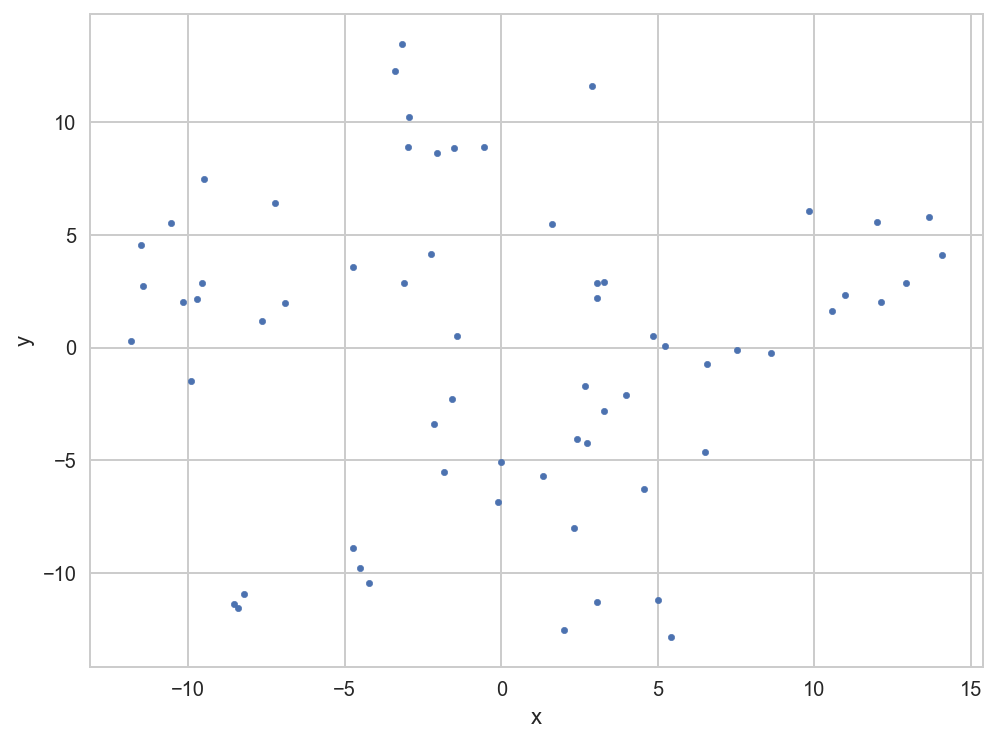

In [444]:
charpoints.plot.scatter("x", "y", s=10, figsize=(8, 6))
plt.show()

In [445]:
def plot_region(dataframe,x_bounds, y_bounds):
    slice = dataframe[
        (x_bounds[0] <= dataframe.x) &
        (dataframe.x <= x_bounds[1]) & 
        (y_bounds[0] <= dataframe.y) &
        (dataframe.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.010, point.y + 0.006, Namelist[point.name], fontsize=11)

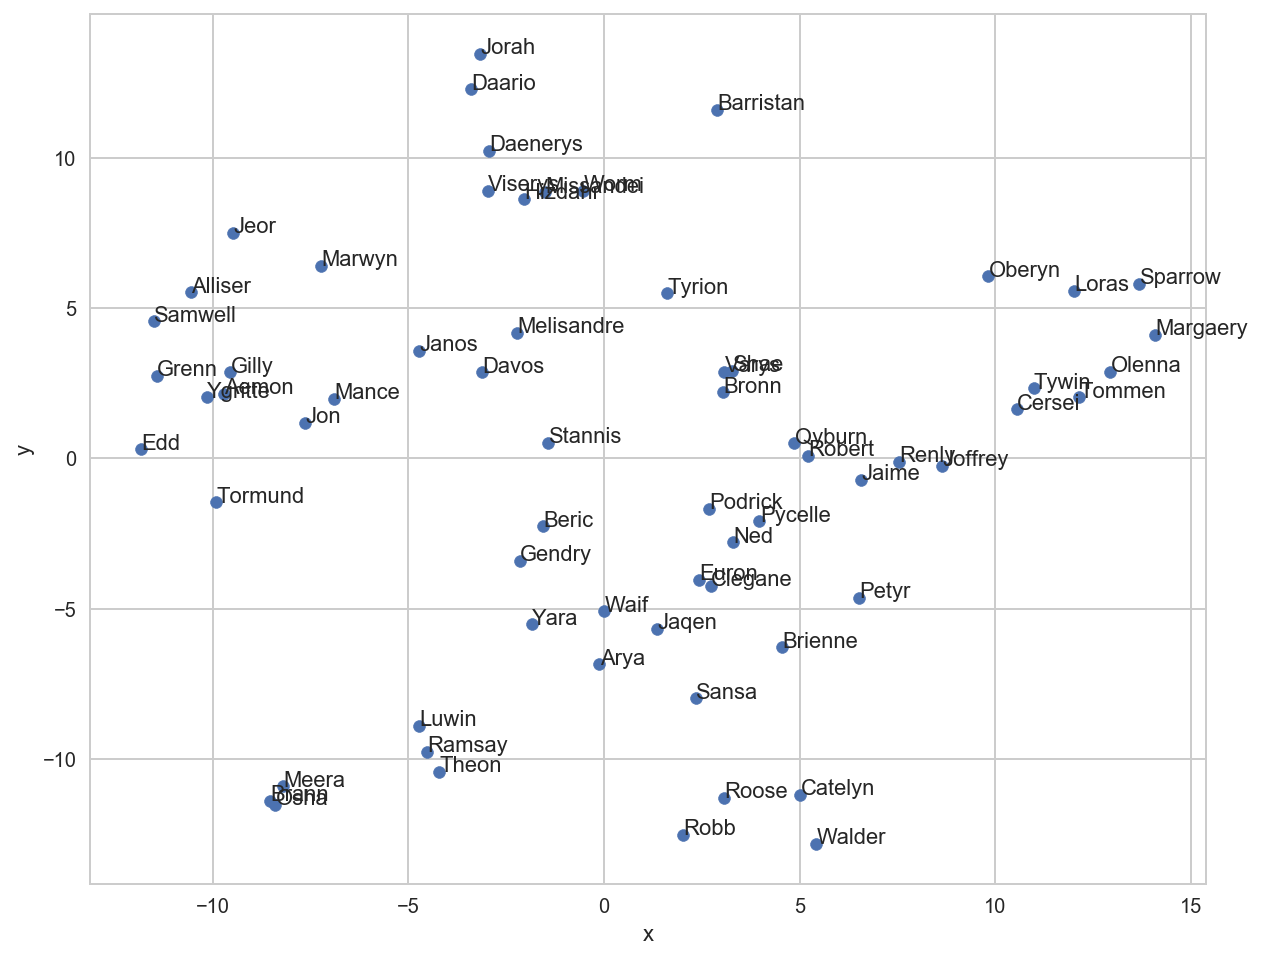

In [446]:
plot_region(charpoints, x_bounds=(-20,20), y_bounds=(-20,20))

In [447]:
# set up for plotting clusters
def plot_clusters(dataframe,clusters,x_bounds, y_bounds,colormap='rainbow'):
    slice = dataframe[
        (x_bounds[0] <= dataframe.x) &
        (dataframe.x <= x_bounds[1]) & 
        (y_bounds[0] <= dataframe.y) &
        (dataframe.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", c=clusters, colormap=colormap, s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.008, point.y + 0.006, Namelist[point.name], fontsize=11)

In [448]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering

In [449]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(155, 100), dpi=80, facecolor='w', edgecolor='k')

<Figure size 12400x8000 with 0 Axes>

<Figure size 12400x8000 with 0 Axes>

In [450]:
#accidently changed variable name in clustering, assocciating them here
Vectors = character_vectors
len(Vectors),len(Namelist)

(65, 65)

In [424]:
 KMeans?

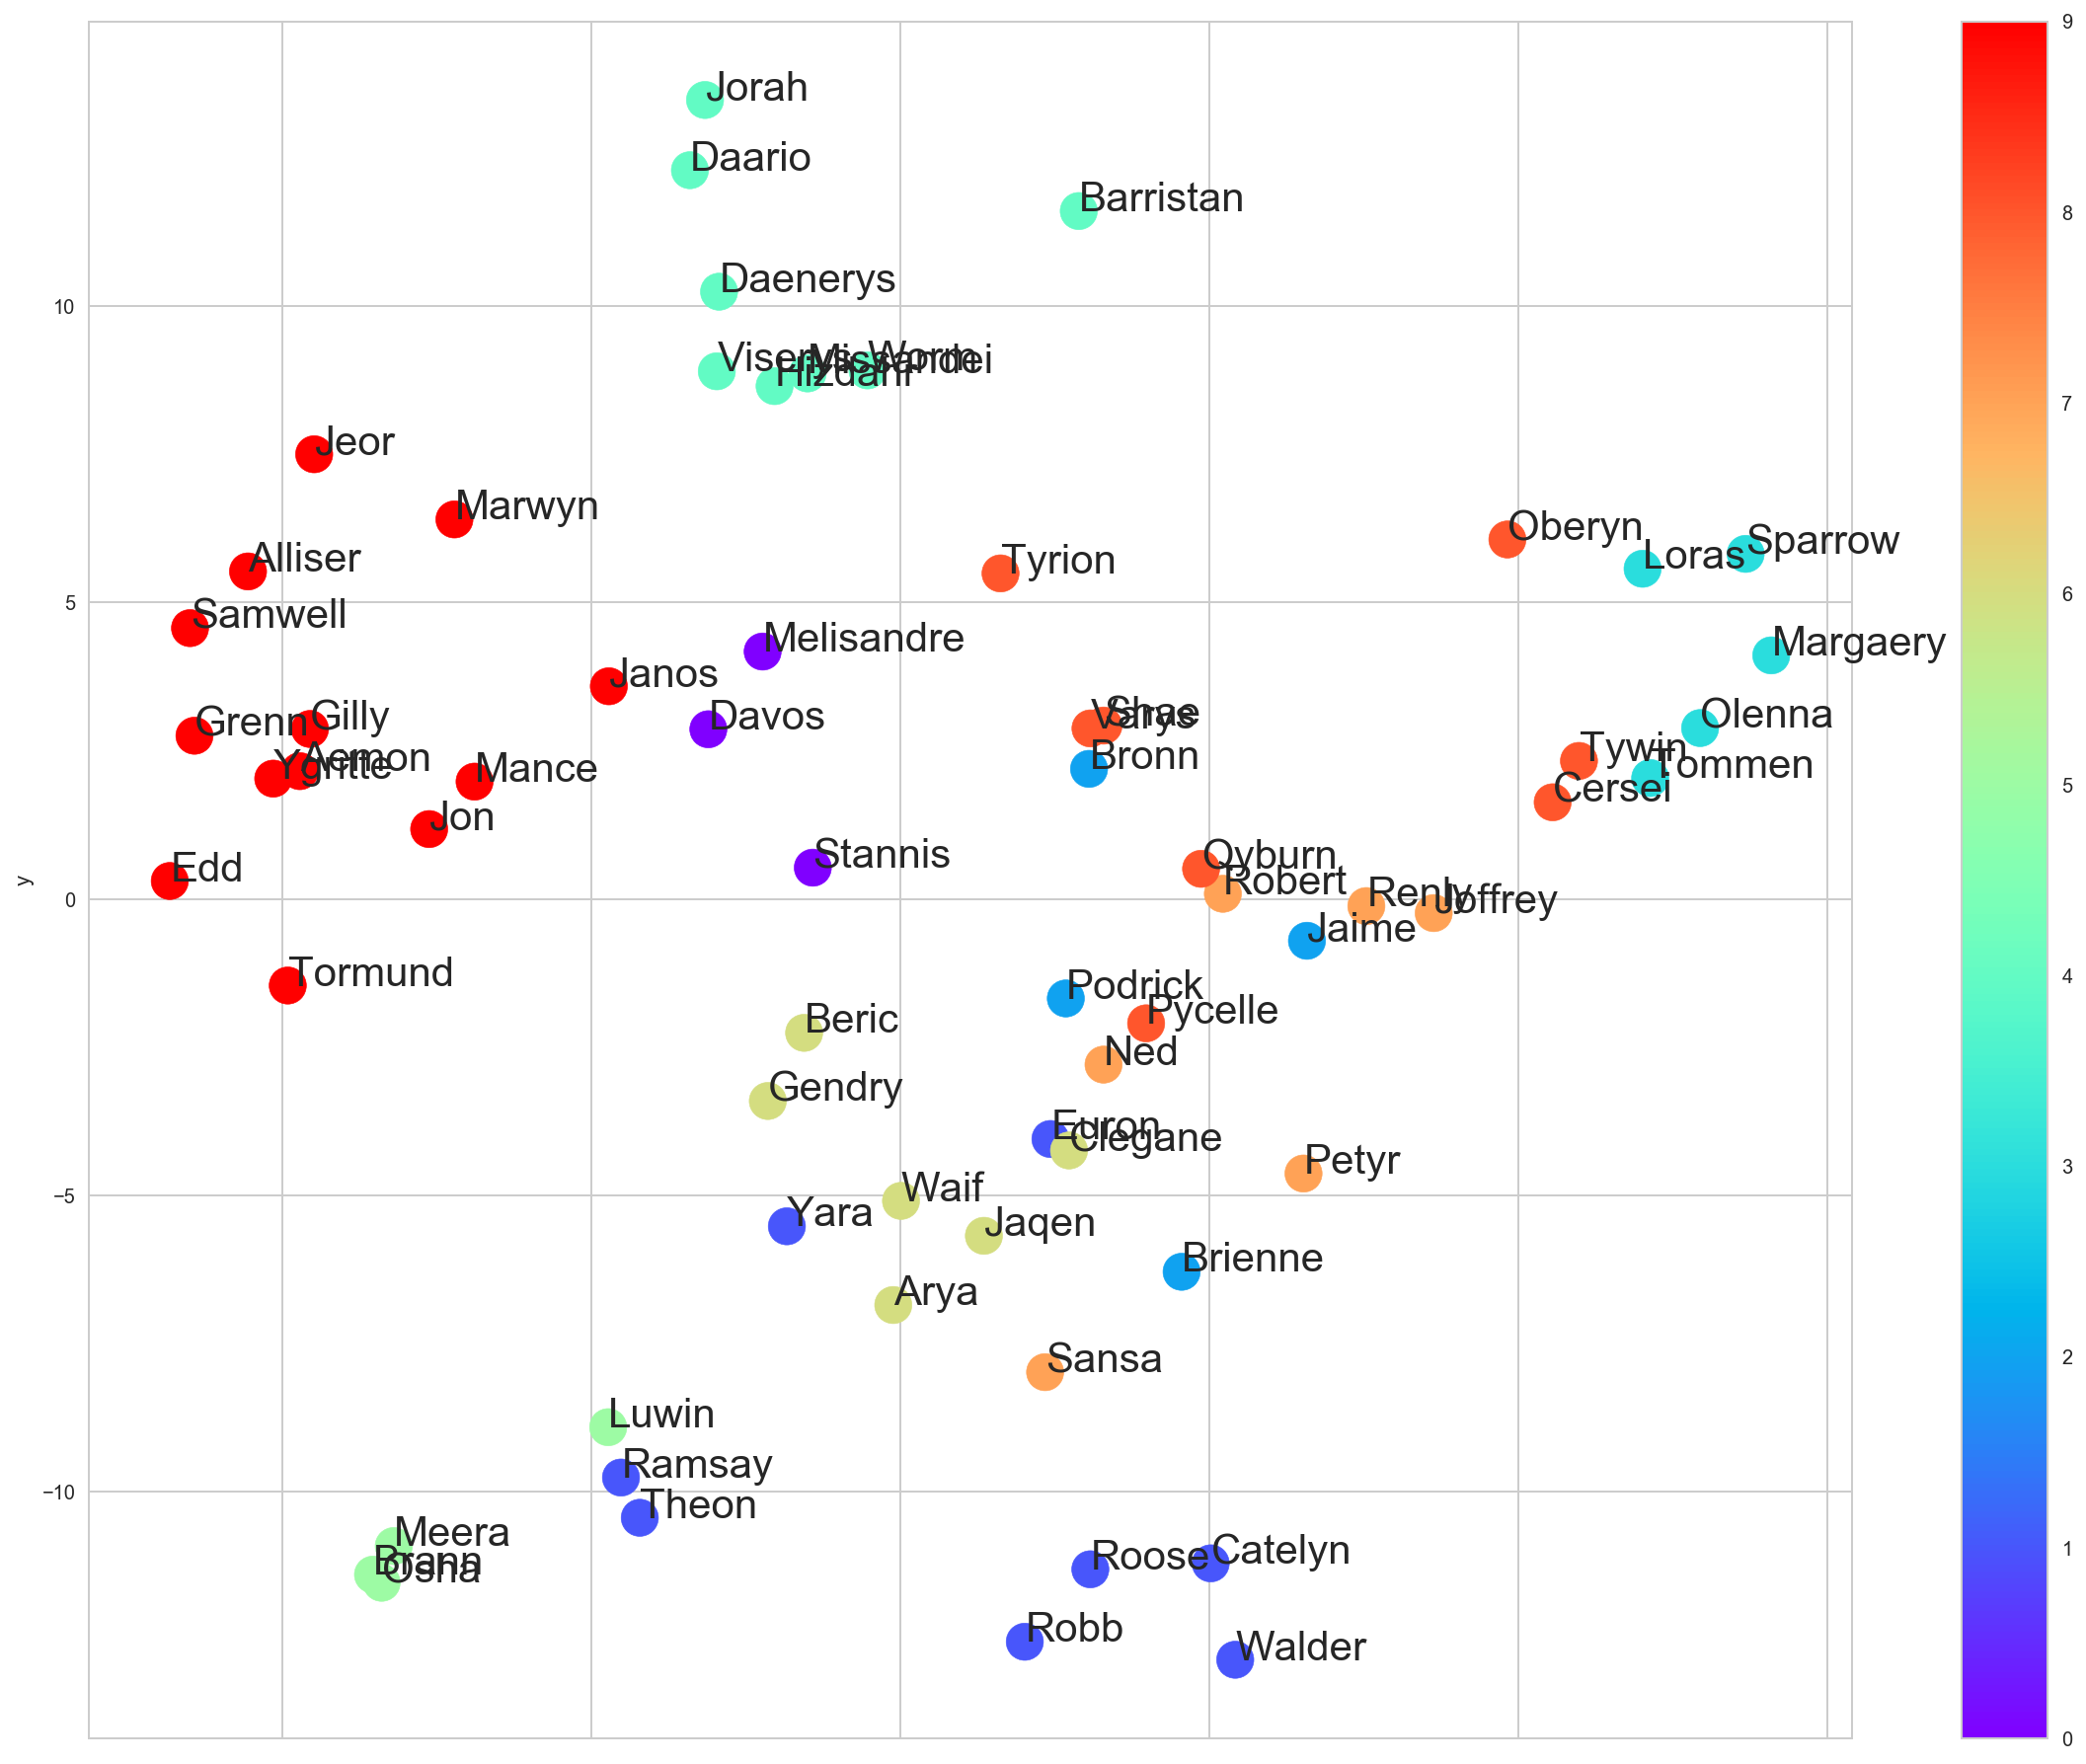

In [474]:
KM_model = KMeans(n_clusters= 10,n_jobs=-1, random_state = 42, max_iter = 100000)
clusters = KM_model.fit_predict(Vectors)
ii = np.argsort(clusters)
list(zip(np.array(Namelist)[ii],clusters[ii]))
x_bounds=(-530,530)
y_bounds=(-800,800)
slice = charpoints[
    (x_bounds[0] <= charpoints.x) &
    (charpoints.x <= x_bounds[1]) & 
    (y_bounds[0] <= charpoints.y) &
    (charpoints.y <= y_bounds[1])
]

ax = slice.plot.scatter("x", "y", c=list(clusters), colormap='rainbow', s=355, figsize=(20, 16))
for i, point in slice.iterrows():
    ax.text(point.x + 0.004, point.y + 0.003, Namelist[point.name], fontsize=21)

# Part IV

# Evaluate the Results

In [475]:
ii = np.argsort(clusters)
namegrouplist = list(zip(np.array(Namelist)[ii],clusters[ii]))
namegrouplist

[('Melisandre', 0),
 ('Stannis', 0),
 ('Davos', 0),
 ('Ramsay', 1),
 ('Robb', 1),
 ('Theon', 1),
 ('Catelyn', 1),
 ('Walder', 1),
 ('Euron', 1),
 ('Yara', 1),
 ('Roose', 1),
 ('Podrick', 2),
 ('Jaime', 2),
 ('Brienne', 2),
 ('Bronn', 2),
 ('Loras', 3),
 ('Margaery', 3),
 ('Tommen', 3),
 ('Olenna', 3),
 ('Sparrow', 3),
 ('Jorah', 4),
 ('Viserys', 4),
 ('Worm', 4),
 ('Barristan', 4),
 ('Daenerys', 4),
 ('Hizdahr', 4),
 ('Missandei', 4),
 ('Daario', 4),
 ('Osha', 5),
 ('Meera', 5),
 ('Luwin', 5),
 ('Brann', 5),
 ('Clegane', 6),
 ('Jaqen', 6),
 ('Gendry', 6),
 ('Arya', 6),
 ('Waif', 6),
 ('Beric', 6),
 ('Joffrey', 7),
 ('Petyr', 7),
 ('Ned', 7),
 ('Sansa', 7),
 ('Robert', 7),
 ('Renly', 7),
 ('Varys', 8),
 ('Pycelle', 8),
 ('Shae', 8),
 ('Tyrion', 8),
 ('Cersei', 8),
 ('Qyburn', 8),
 ('Oberyn', 8),
 ('Tywin', 8),
 ('Marwyn', 9),
 ('Jon', 9),
 ('Aemon', 9),
 ('Samwell', 9),
 ('Tormund', 9),
 ('Gilly', 9),
 ('Ygritte', 9),
 ('Janos', 9),
 ('Alliser', 9),
 ('Grenn', 9),
 ('Jeor', 9),
 ('Edd',

In [476]:
#the one is for the web d3
json = """{
  "nodes": [
"""

for name,group in namegrouplist:
    json = json + "    {\"id\": \"" + name + "\", \"group\": " + str(group) + "},\n"

json = json[:-2] + """   ],      
  "links": [ 
"""  #[:-2] leaves out ,\n on last line before adding square bracket

for line in interaction_map:
    if line[2]>=15:
        json = json + "    {\"source\": \"" + line[0] + "\", \"target\": \"" + line[1] + "\", \"value\": " + str(line[2]) + "},\n"

json = json[:-2] + """  ]
}"""

In [477]:
print(json)

{
  "nodes": [
    {"id": "Melisandre", "group": 0},
    {"id": "Stannis", "group": 0},
    {"id": "Davos", "group": 0},
    {"id": "Ramsay", "group": 1},
    {"id": "Robb", "group": 1},
    {"id": "Theon", "group": 1},
    {"id": "Catelyn", "group": 1},
    {"id": "Walder", "group": 1},
    {"id": "Euron", "group": 1},
    {"id": "Yara", "group": 1},
    {"id": "Roose", "group": 1},
    {"id": "Podrick", "group": 2},
    {"id": "Jaime", "group": 2},
    {"id": "Brienne", "group": 2},
    {"id": "Bronn", "group": 2},
    {"id": "Loras", "group": 3},
    {"id": "Margaery", "group": 3},
    {"id": "Tommen", "group": 3},
    {"id": "Olenna", "group": 3},
    {"id": "Sparrow", "group": 3},
    {"id": "Jorah", "group": 4},
    {"id": "Viserys", "group": 4},
    {"id": "Worm", "group": 4},
    {"id": "Barristan", "group": 4},
    {"id": "Daenerys", "group": 4},
    {"id": "Hizdahr", "group": 4},
    {"id": "Missandei", "group": 4},
    {"id": "Daario", "group": 4},
    {"id": "Osha", "group"

## Measure centrality

In [487]:
import networkx as nx
from networkx.readwrite import json_graph

In [493]:
H = json_graph.node_link_graph(({
  "nodes": [
    {"id": "Melisandre", "group": 0},
    {"id": "Stannis", "group": 0},
    {"id": "Davos", "group": 0},
    {"id": "Ramsay", "group": 1},
    {"id": "Robb", "group": 1},
    {"id": "Theon", "group": 1},
    {"id": "Catelyn", "group": 1},
    {"id": "Walder", "group": 1},
    {"id": "Euron", "group": 1},
    {"id": "Yara", "group": 1},
    {"id": "Roose", "group": 1},
    {"id": "Podrick", "group": 2},
    {"id": "Jaime", "group": 2},
    {"id": "Brienne", "group": 2},
    {"id": "Bronn", "group": 2},
    {"id": "Loras", "group": 3},
    {"id": "Margaery", "group": 3},
    {"id": "Tommen", "group": 3},
    {"id": "Olenna", "group": 3},
    {"id": "Sparrow", "group": 3},
    {"id": "Jorah", "group": 4},
    {"id": "Viserys", "group": 4},
    {"id": "Worm", "group": 4},
    {"id": "Barristan", "group": 4},
    {"id": "Daenerys", "group": 4},
    {"id": "Hizdahr", "group": 4},
    {"id": "Missandei", "group": 4},
    {"id": "Daario", "group": 4},
    {"id": "Osha", "group": 5},
    {"id": "Meera", "group": 5},
    {"id": "Luwin", "group": 5},
    {"id": "Brann", "group": 5},
    {"id": "Clegane", "group": 6},
    {"id": "Jaqen", "group": 6},
    {"id": "Gendry", "group": 6},
    {"id": "Arya", "group": 6},
    {"id": "Waif", "group": 6},
    {"id": "Beric", "group": 6},
    {"id": "Joffrey", "group": 7},
    {"id": "Petyr", "group": 7},
    {"id": "Ned", "group": 7},
    {"id": "Sansa", "group": 7},
    {"id": "Robert", "group": 7},
    {"id": "Renly", "group": 7},
    {"id": "Varys", "group": 8},
    {"id": "Pycelle", "group": 8},
    {"id": "Shae", "group": 8},
    {"id": "Tyrion", "group": 8},
    {"id": "Cersei", "group": 8},
    {"id": "Qyburn", "group": 8},
    {"id": "Oberyn", "group": 8},
    {"id": "Tywin", "group": 8},
    {"id": "Marwyn", "group": 9},
    {"id": "Jon", "group": 9},
    {"id": "Aemon", "group": 9},
    {"id": "Samwell", "group": 9},
    {"id": "Tormund", "group": 9},
    {"id": "Gilly", "group": 9},
    {"id": "Ygritte", "group": 9},
    {"id": "Janos", "group": 9},
    {"id": "Alliser", "group": 9},
    {"id": "Grenn", "group": 9},
    {"id": "Jeor", "group": 9},
    {"id": "Edd", "group": 9},
    {"id": "Mance", "group": 9}   ],      
  "links": [ 
    {"source": "Tyrion", "target": "Jon", "value": 168},
    {"source": "Tyrion", "target": "Cersei", "value": 289},
    {"source": "Tyrion", "target": "Daenerys", "value": 328},
    {"source": "Tyrion", "target": "Jaime", "value": 183},
    {"source": "Tyrion", "target": "Sansa", "value": 64},
    {"source": "Tyrion", "target": "Davos", "value": 47},
    {"source": "Tyrion", "target": "Jorah", "value": 140},
    {"source": "Tyrion", "target": "Bronn", "value": 160},
    {"source": "Tyrion", "target": "Catelyn", "value": 44},
    {"source": "Tyrion", "target": "Tywin", "value": 205},
    {"source": "Tyrion", "target": "Joffrey", "value": 140},
    {"source": "Tyrion", "target": "Missandei", "value": 92},
    {"source": "Tyrion", "target": "Janos", "value": 44},
    {"source": "Tyrion", "target": "Oberyn", "value": 60},
    {"source": "Tyrion", "target": "Shae", "value": 105},
    {"source": "Tyrion", "target": "Varys", "value": 278},
    {"source": "Tyrion", "target": "Worm", "value": 78},
    {"source": "Jon", "target": "Cersei", "value": 51},
    {"source": "Jon", "target": "Daenerys", "value": 185},
    {"source": "Jon", "target": "Sansa", "value": 230},
    {"source": "Jon", "target": "Arya", "value": 59},
    {"source": "Jon", "target": "Samwell", "value": 291},
    {"source": "Jon", "target": "Ned", "value": 89},
    {"source": "Jon", "target": "Davos", "value": 198},
    {"source": "Jon", "target": "Jorah", "value": 41},
    {"source": "Jon", "target": "Robb", "value": 41},
    {"source": "Jon", "target": "Stannis", "value": 132},
    {"source": "Jon", "target": "Ramsay", "value": 76},
    {"source": "Jon", "target": "Tormund", "value": 173},
    {"source": "Jon", "target": "Robert", "value": 46},
    {"source": "Jon", "target": "Melisandre", "value": 69},
    {"source": "Jon", "target": "Janos", "value": 44},
    {"source": "Jon", "target": "Alliser", "value": 81},
    {"source": "Jon", "target": "Jeor", "value": 60},
    {"source": "Jon", "target": "Edd", "value": 74},
    {"source": "Jon", "target": "Grenn", "value": 71},
    {"source": "Jon", "target": "Aemon", "value": 64},
    {"source": "Jon", "target": "Ygritte", "value": 60},
    {"source": "Jon", "target": "Mance", "value": 103},
    {"source": "Cersei", "target": "Daenerys", "value": 61},
    {"source": "Cersei", "target": "Jaime", "value": 360},
    {"source": "Cersei", "target": "Sansa", "value": 77},
    {"source": "Cersei", "target": "Ned", "value": 122},
    {"source": "Cersei", "target": "Petyr", "value": 83},
    {"source": "Cersei", "target": "Tywin", "value": 106},
    {"source": "Cersei", "target": "Margaery", "value": 110},
    {"source": "Cersei", "target": "Joffrey", "value": 125},
    {"source": "Cersei", "target": "Robert", "value": 109},
    {"source": "Cersei", "target": "Olenna", "value": 82},
    {"source": "Cersei", "target": "Tommen", "value": 96},
    {"source": "Cersei", "target": "Qyburn", "value": 91},
    {"source": "Cersei", "target": "Loras", "value": 44},
    {"source": "Cersei", "target": "Pycelle", "value": 46},
    {"source": "Cersei", "target": "Varys", "value": 62},
    {"source": "Cersei", "target": "Sparrow", "value": 144},
    {"source": "Daenerys", "target": "Jorah", "value": 312},
    {"source": "Daenerys", "target": "Daario", "value": 131},
    {"source": "Daenerys", "target": "Missandei", "value": 66},
    {"source": "Daenerys", "target": "Viserys", "value": 62},
    {"source": "Daenerys", "target": "Barristan", "value": 83},
    {"source": "Daenerys", "target": "Varys", "value": 89},
    {"source": "Daenerys", "target": "Hizdahr", "value": 76},
    {"source": "Jaime", "target": "Ned", "value": 71},
    {"source": "Jaime", "target": "Bronn", "value": 231},
    {"source": "Jaime", "target": "Catelyn", "value": 59},
    {"source": "Jaime", "target": "Tywin", "value": 75},
    {"source": "Jaime", "target": "Robb", "value": 51},
    {"source": "Jaime", "target": "Brienne", "value": 106},
    {"source": "Jaime", "target": "Robert", "value": 40},
    {"source": "Jaime", "target": "Olenna", "value": 52},
    {"source": "Jaime", "target": "Tommen", "value": 48},
    {"source": "Jaime", "target": "Sparrow", "value": 41},
    {"source": "Sansa", "target": "Arya", "value": 197},
    {"source": "Sansa", "target": "Ned", "value": 73},
    {"source": "Sansa", "target": "Petyr", "value": 246},
    {"source": "Sansa", "target": "Davos", "value": 48},
    {"source": "Sansa", "target": "Theon", "value": 85},
    {"source": "Sansa", "target": "Brann", "value": 43},
    {"source": "Sansa", "target": "Brienne", "value": 86},
    {"source": "Sansa", "target": "Ramsay", "value": 121},
    {"source": "Sansa", "target": "Joffrey", "value": 143},
    {"source": "Sansa", "target": "Roose", "value": 40},
    {"source": "Arya", "target": "Ned", "value": 104},
    {"source": "Arya", "target": "Brienne", "value": 60},
    {"source": "Arya", "target": "Joffrey", "value": 48},
    {"source": "Arya", "target": "Jaqen", "value": 123},
    {"source": "Arya", "target": "Gendry", "value": 50},
    {"source": "Arya", "target": "Waif", "value": 74},
    {"source": "Arya", "target": "Clegane", "value": 103},
    {"source": "Samwell", "target": "Gilly", "value": 224},
    {"source": "Samwell", "target": "Alliser", "value": 47},
    {"source": "Samwell", "target": "Marwyn", "value": 80},
    {"source": "Samwell", "target": "Grenn", "value": 55},
    {"source": "Samwell", "target": "Aemon", "value": 57},
    {"source": "Ned", "target": "Petyr", "value": 128},
    {"source": "Ned", "target": "Catelyn", "value": 84},
    {"source": "Ned", "target": "Robert", "value": 205},
    {"source": "Ned", "target": "Pycelle", "value": 65},
    {"source": "Ned", "target": "Varys", "value": 97},
    {"source": "Petyr", "target": "Catelyn", "value": 40},
    {"source": "Petyr", "target": "Roose", "value": 46},
    {"source": "Petyr", "target": "Varys", "value": 87},
    {"source": "Davos", "target": "Stannis", "value": 212},
    {"source": "Davos", "target": "Tormund", "value": 41},
    {"source": "Davos", "target": "Melisandre", "value": 84},
    {"source": "Davos", "target": "Gendry", "value": 44},
    {"source": "Theon", "target": "Brann", "value": 51},
    {"source": "Theon", "target": "Robb", "value": 101},
    {"source": "Theon", "target": "Ramsay", "value": 110},
    {"source": "Theon", "target": "Roose", "value": 65},
    {"source": "Theon", "target": "Yara", "value": 122},
    {"source": "Theon", "target": "Luwin", "value": 43},
    {"source": "Jorah", "target": "Daario", "value": 92},
    {"source": "Jorah", "target": "Viserys", "value": 57},
    {"source": "Brann", "target": "Robb", "value": 58},
    {"source": "Brann", "target": "Osha", "value": 87},
    {"source": "Brann", "target": "Meera", "value": 52},
    {"source": "Brann", "target": "Luwin", "value": 72},
    {"source": "Catelyn", "target": "Robb", "value": 156},
    {"source": "Catelyn", "target": "Walder", "value": 60},
    {"source": "Tywin", "target": "Joffrey", "value": 62},
    {"source": "Tywin", "target": "Oberyn", "value": 50},
    {"source": "Robb", "target": "Roose", "value": 44},
    {"source": "Robb", "target": "Walder", "value": 53},
    {"source": "Stannis", "target": "Melisandre", "value": 107},
    {"source": "Stannis", "target": "Renly", "value": 55},
    {"source": "Brienne", "target": "Podrick", "value": 111},
    {"source": "Ramsay", "target": "Roose", "value": 111},
    {"source": "Margaery", "target": "Olenna", "value": 71},
    {"source": "Margaery", "target": "Tommen", "value": 107},
    {"source": "Margaery", "target": "Loras", "value": 58},
    {"source": "Margaery", "target": "Sparrow", "value": 101},
    {"source": "Olenna", "target": "Sparrow", "value": 48},
    {"source": "Missandei", "target": "Worm", "value": 90},
    {"source": "Tommen", "target": "Sparrow", "value": 64},
    {"source": "Loras", "target": "Renly", "value": 59},
    {"source": "Loras", "target": "Sparrow", "value": 53},
    {"source": "Clegane", "target": "Beric", "value": 76}  ]
}))

In [500]:
nx.degree_centrality(H)
sorted(nx.degree_centrality(H).items(), key=lambda x: x[1], reverse = True)[:11]

[('Jon', 0.359375),
 ('Cersei', 0.28125),
 ('Tyrion', 0.265625),
 ('Sansa', 0.203125),
 ('Jaime', 0.1875),
 ('Daenerys', 0.15625),
 ('Ned', 0.15625),
 ('Arya', 0.140625),
 ('Davos', 0.109375),
 ('Robb', 0.109375),
 ('Theon', 0.109375)]